In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, ScalarFormatter
import seaborn as sns
from scipy.interpolate import make_interp_spline, make_lsq_spline, BSpline

from tensorflow import keras
import keras.backend as K

import ModelBuilder

In [2]:
def flatten(t):
    return np.array([item for sublist in t for item in sublist])

In [4]:
EPOCHS = 30   # 1e3
REF    = 200  # 1e3
BKG    = 3    # 1e3
WCLIP  = 4
NTOYS  = 40

RUNS = [1253, 1265, 1242]
TEST = 4

t_lists = []
t_histories = []

DATA_FOLDER = f"/lustre/cmswork/nlai/DRIFT_TIME/model_testing/"
# FOLDER_0 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[0]}"
# FOLDER_1 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[1]}_test{TEST}"
# FOLDER_2 = f"shot_E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[2]}_test{TEST}"
FOLDER_0 = f"E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[0]}"
FOLDER_1 = f"E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[1]}"
FOLDER_2 = f"E{EPOCHS}kR{REF}kB{BKG}kW{WCLIP}_{RUNS[2]}"
OUT_PATH_0 = DATA_FOLDER + FOLDER_0
OUT_PATH_1 = DATA_FOLDER + FOLDER_1
OUT_PATH_2 = DATA_FOLDER + FOLDER_2

# REFERENCE
path = "/lustre/cmswork/nlai/thesis/DATA/"
name = "t_reference.txt"
t_list_ref = np.loadtxt(fname=path+name)

In [5]:
distributions_path = "/lustre/cmswork/nlai/thesis/FALKON/data/"

df_ref    = pd.read_csv(distributions_path+ "RUN1252.txt")
df_data_0 = pd.read_csv(distributions_path+f"RUN{RUNS[0]}.txt")
df_data_1 = pd.read_csv(distributions_path+f"RUN{RUNS[1]}.txt")
df_data_2 = pd.read_csv(distributions_path+f"RUN{RUNS[2]}.txt")

In [6]:
w_ref    = flatten(np.ones_like(df_ref))
w_data_0 = flatten(np.ones_like(df_data_0))
w_data_1 = flatten(np.ones_like(df_data_1))
w_data_2 = flatten(np.ones_like(df_data_2))

w_ref_0  = w_ref*df_data_0.shape[0]/df_ref.shape[0]
w_ref_1  = w_ref*df_data_1.shape[0]/df_ref.shape[0]
w_ref_2  = w_ref*df_data_2.shape[0]/df_ref.shape[0]

bins = np.linspace(-190, 590, 90)

In [7]:
data_df    = [df_data_0,    df_data_1,    df_data_2   ]
w_data     = [w_data_0,     w_data_1,     w_data_2    ]
w_refs     = [w_ref_0,      w_ref_1,      w_ref_2     ]

FileNotFoundError: [Errno 2] No such file or directory: '/lustre/cmswork/nlai/FALKON/plots/distributions.pdf'

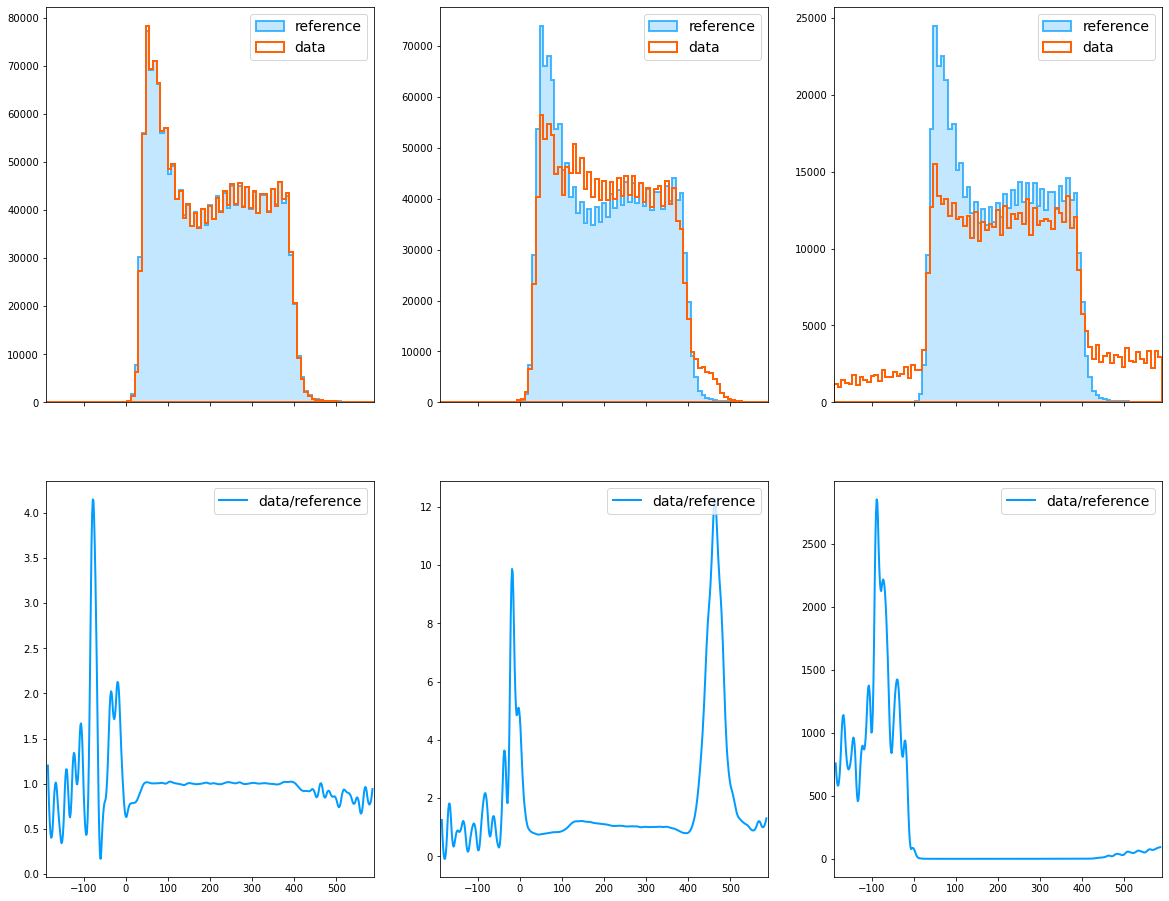

In [8]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,16), sharex="all")

ax[0][0].set_xlim(-190,590)
x = 0.5*(bins[1:]+bins[:-1])
x_smooth = np.linspace(x.min(), x.max(), 500)

for i in [0, 1, 2]:
    
    # reference distribution
    ref_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=w_refs[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#009cff", 
        facecolor="#aadeff", 
        alpha=.7, 
        label="reference"
    )
    
    # data distribution
    data_hist = ax[0][i].hist(
        data_df[i]["drift_time"], 
        bins=bins, 
        weights=w_data[i],
        density=False,
        histtype="stepfilled", 
        linewidth=2,
        edgecolor="#FF6104", 
        facecolor="none", 
        alpha=1, 
        label="data"
    )
    
    ax[0][i].legend(loc="upper right", fontsize=14)
    
    # data/ref ratio
    spl = make_interp_spline(x, (data_hist[0])/(ref_hist[0]), k=2)
    ratio_smooth = spl(x_smooth)
    
    ax[1][i].plot(
#         x,
        x_smooth, 
#         (data_hist[0])/(ref_hist[0]),
        ratio_smooth,
        linewidth=2,
        color="#009cff", 
        alpha=1, 
        label="data/reference"
    )
    

    
    ax[1][i].legend(loc="upper right", fontsize=14)

plot_name = "distributions"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/thesis/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)   
plt.show()

In [9]:
NPLModel = ModelBuilder.ModelBuilder(
            n_input=1,
            latentsize=3,
            layers=1,
            weight_clipping=WCLIP,
            internal_activation="tanh",        
            batch_norm_bool=True,              
            more_batch_norm_bool=True,         
            custom_activation_bool=True,      
            custom_const=1                    
        )

In [10]:
MAIN_PATH  = "/lustre/cmswork/nlai/thesis/DRIFT_TIME/model_testing/"
TOY_FOLDER = f"E{int(EPOCHS*1e3)}_latent{3}_layers{1}_wclip{float(WCLIP)}_ntoy{NTOYS}_ref{int(REF*1e3)}_bkg{int(BKG*1e3)}_sig{0}_patience{1000}/"

WEIGHTS_PATH_0 = MAIN_PATH+FOLDER_0+f"/{24}/"+TOY_FOLDER
WEIGHTS_PATH_1 = MAIN_PATH+FOLDER_1+f"/{19}/"+TOY_FOLDER
WEIGHTS_PATH_2 = MAIN_PATH+FOLDER_2+f"/{24}/"+TOY_FOLDER

weights_paths  = [WEIGHTS_PATH_0, WEIGHTS_PATH_1, WEIGHTS_PATH_2]

weights_files  = [] 
norm_files     = []
for w_path in weights_paths:
    
    weights_files.append(
        [a for a in os.listdir(w_path) if "_weights.h5" in a][0]
    )
    
    norm_files.append(
        [a for a in os.listdir(w_path) if "_normWalization.txt" in a][0]
    )
    
means = []
stds  = []
for i in [0, 1, 2]:
    with open(weights_paths[i]+norm_files[i], "r") as f_0:
        normalizzazione_0 = f_0.readline()
    means.append(
        float(normalizzazione_0.split("Mean: ")[1].split(", ")[0])
    )
    stds.append(
        float(normalizzazione_0.split("Std: " )[1])
    )

In [11]:
model_0 = NPLModel()
model_1 = NPLModel()
model_2 = NPLModel()
model_0.load_weights(weights_paths[0]+weights_files[0])
model_1.load_weights(weights_paths[1]+weights_files[1])
model_2.load_weights(weights_paths[2]+weights_files[2])

models = [model_0, model_1, model_2]

In [12]:
pred_weights_0 = np.abs(flatten(np.exp(models[0].predict((df_ref-means[0])/stds[0], batch_size=df_ref.shape[0]))))
pred_weights_1 = np.abs(flatten(np.exp(models[1].predict((df_ref-means[1])/stds[1], batch_size=df_ref.shape[0]))))
pred_weights_2 = np.abs(flatten(np.exp(models[2].predict((df_ref-means[2])/stds[2], batch_size=df_ref.shape[0]))))

nn_weights = [pred_weights_0, pred_weights_1, pred_weights_2]

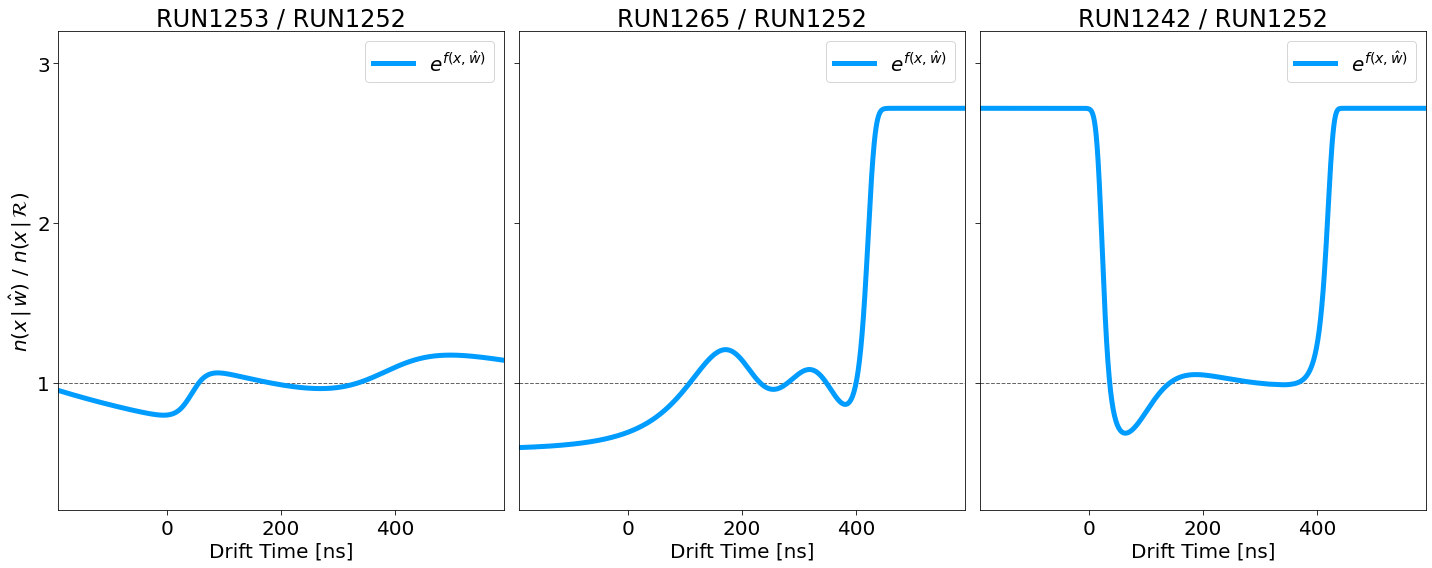

In [13]:
xgrid = np.linspace(-190, 590, 1000)

fig, ax = plt.subplots(ncols=3, figsize=(20,8), sharex="all", sharey="all")

# fig.suptitle("Predicted density ratio", fontsize=32)

ax[0].set_xlim(-190,590)
ax[0].set_ylim(0.2,3.2)

titles = ["RUN1253 / RUN1252", "RUN1265 / RUN1252", "RUN1242 / RUN1252"]
for i in [0, 1, 2]:
    
    ax[i].axhline(y=1, c="black", ls="--", lw=1, alpha=.6)
    
    sns.lineplot(
        x=xgrid,
        y=flatten(np.exp( models[i]((xgrid-means[i]) / stds[i]) )),
        linewidth=5,
        color="#009cff", 
        ax=ax[i],
        label=r"$e^{f(x, \hat{w})}$"
    )
    ax[i].set_title(titles[i], fontsize=24)
    ax[i].set_xlabel('Drift Time [ns]', fontsize = 20)
    ax[i].set_ylabel(r'$n(x\,|\,\hat{w})\,\,/\,\,n(x\,|\,\mathcal{R})$', fontsize = 20)
    ax[i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[i].tick_params(axis = 'both', which = 'major', labelsize = 20, direction = 'out', length = 5)
    ax[i].legend(loc="upper right", fontsize=20)

fig.tight_layout()
plot_name = "predicted_ratio"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/thesis/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)     
plt.show()

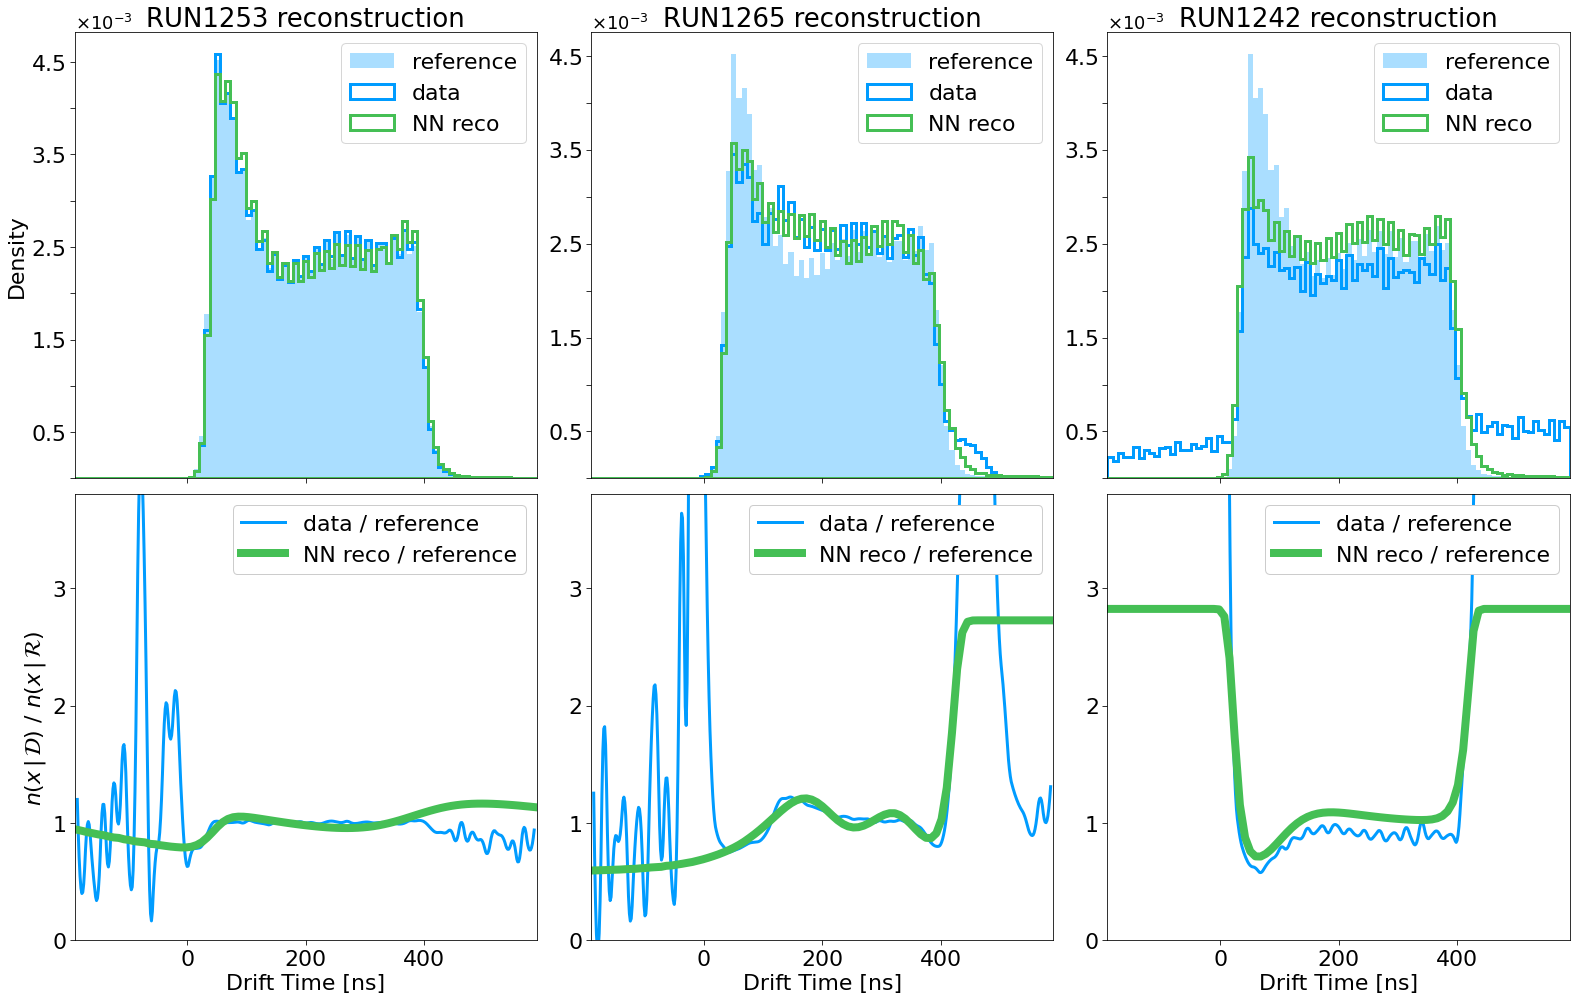

In [27]:
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(22,14), sharex="all")

ax[0][0].set_xlim(-190, 590)

x = 0.5*(bins[1:]+bins[:-1])

titles = ["RUN1253 reconstruction", "RUN1265 reconstruction", "RUN1242 reconstruction"]

for i in [0, 1, 2]:

    
    # reference distribution
    ref_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=w_refs[i],
        density=True,
        histtype="stepfilled", 
        linewidth=3,
        edgecolor="none", 
        facecolor="#aadeff", 
        alpha=1, 
        label="reference"
    )
    
    # data distribution
    data_hist = ax[0][i].hist(
        data_df[i]["drift_time"], 
        bins=bins, 
        weights=w_data[i],
        density=True,
        histtype="stepfilled", 
        linewidth=3,
#         edgecolor="#FF6104", 
        edgecolor="#009cff",
        facecolor="none", 
        alpha=1, 
        label="data"
    )
    
    # NN reco
    nn_hist = ax[0][i].hist(
        df_ref["drift_time"], 
        bins=bins, 
        weights=nn_weights[i]*w_refs[i],
        density=True,
        histtype="stepfilled", 
        linewidth=3,
        edgecolor="#45bf55", 
        facecolor="none", 
        alpha=1, 
        label="NN reco"
    )
    
        
    ax[0][i].set_title(titles[i], fontsize=26)
#     ax[0][i].set_xlabel('Drift Time [ns]', fontsize = 20)
    ax[0][0].set_ylabel("Density", fontsize = 22)
    ax[0][i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0][i].tick_params(axis = 'both', which = 'major', labelsize = 22, direction = 'out', length = 5)
    plt.setp(ax[0][i].get_yticklabels()[0::2], visible=False)
    ax[0][i].yaxis.get_offset_text().set_fontsize(18)
    ax[0][i].yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax[0][i].ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
    ax[0][i].legend(loc="upper right", fontsize=22)
    
    
    # data/ref ratio
    spl = make_interp_spline(x, (data_hist[0])/(ref_hist[0]), k=2)
    ratio_smooth = spl(x_smooth)
    
    ax[1][i].plot(
#         x,
        x_smooth, 
#         (data_hist[0])/(ref_hist[0]),
        ratio_smooth,
        linewidth=3,
        color="#009cff", 
        alpha=1, 
        label="data / reference"
    )
    
    # NN_reco/ref ratio
    ax[1][i].plot(
        x, 
        (nn_hist[0])/(ref_hist[0]),
        linewidth=8,
        color="#45bf55", 
        alpha=1, 
        label="NN reco / reference"
    )
    ax[1][i].set_ylim(0.0, 3.8)
    
#     ax[1][i].set_title(titles[i], fontsize=24)
    ax[1][i].set_xlabel('Drift Time [ns]', fontsize = 22)
    ax[1][0].set_ylabel(r'$n(x\,|\,\mathcal{D})\,\,/\,\,n(x\,|\,\mathcal{R})$', fontsize = 22)
    ax[1][i].yaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1][i].tick_params(axis = 'both', which = 'major', labelsize = 22, direction = 'out', length = 5)
    ax[1][i].legend(loc="upper right", fontsize=22, framealpha=1)

fig.tight_layout()
plot_name = "nn_reco"
ext = "pdf"
fig.savefig(
    f"/lustre/cmswork/nlai/thesis/FALKON/plots/{plot_name}.{ext}",
    facecolor="white"
)     
plt.show()

In [10]:
NPLModel = ModelBuilder.ModelBuilder(
            n_input=1,
            latentsize=3,
            layers=1,
            weight_clipping=WCLIP,
            internal_activation="tanh",        
            batch_norm_bool=True,              
            more_batch_norm_bool=True,         
            custom_activation_bool=True,      
            custom_const=1                    
        )

SAMPLE N: 0


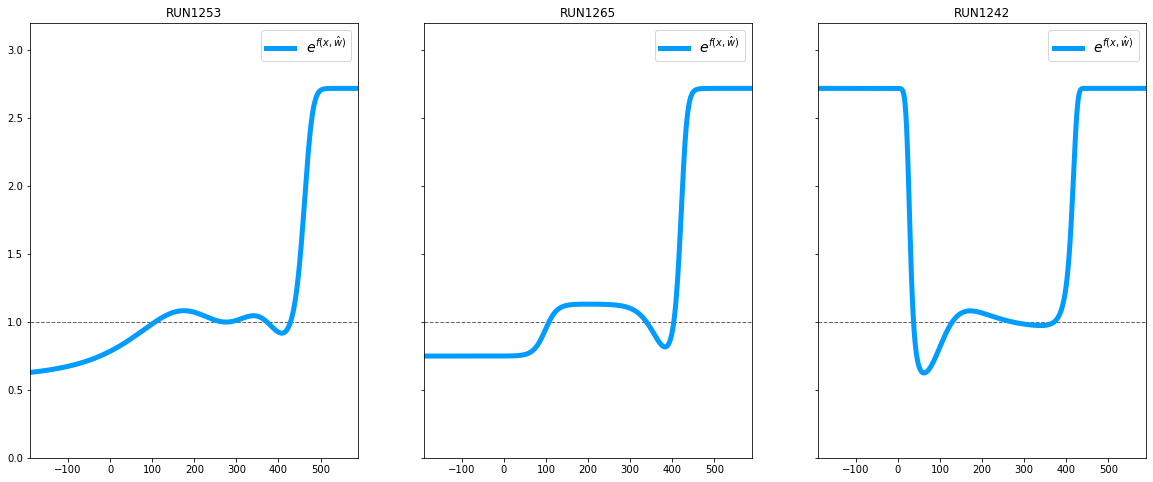

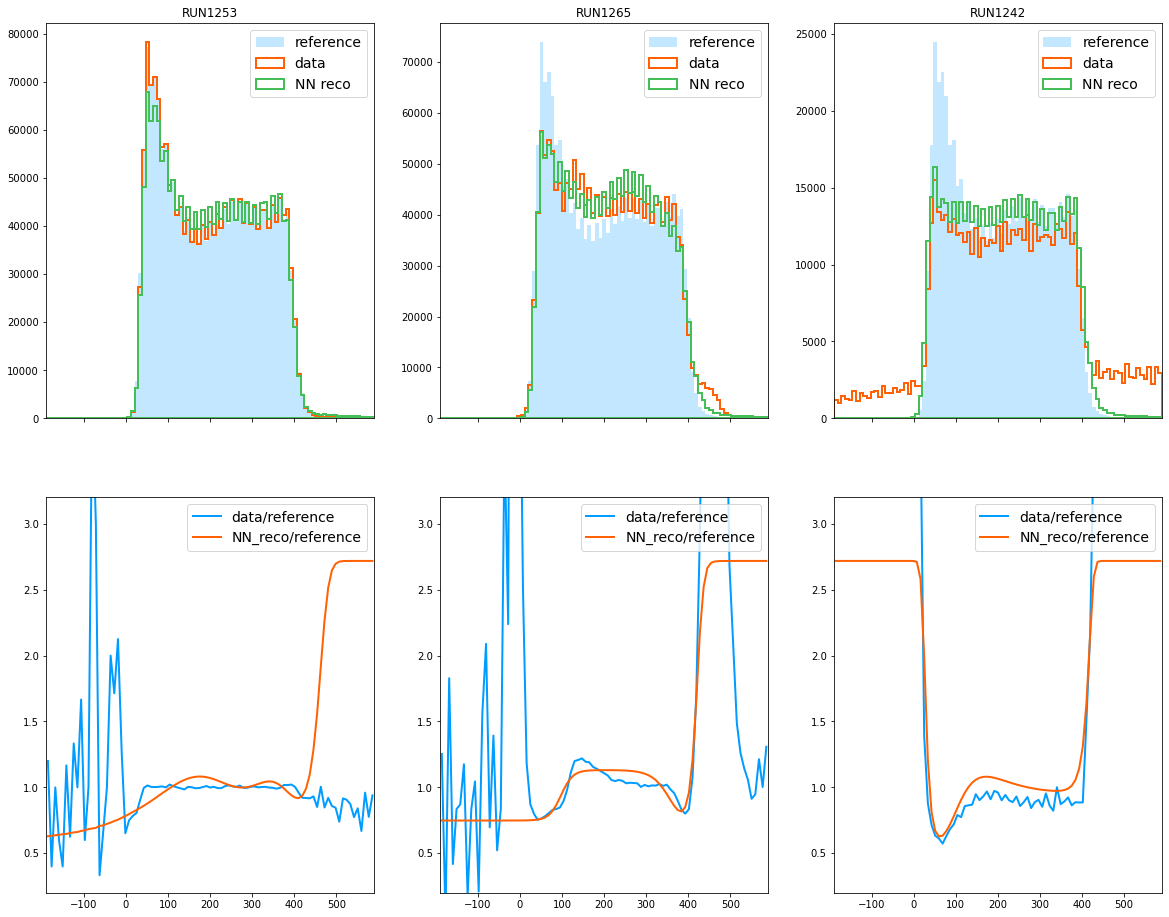

SAMPLE N: 1


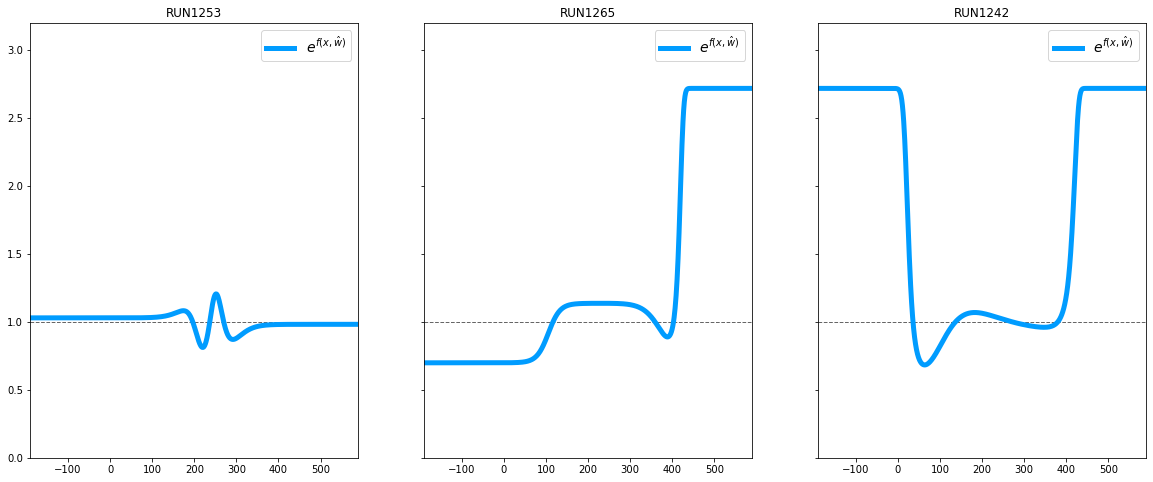

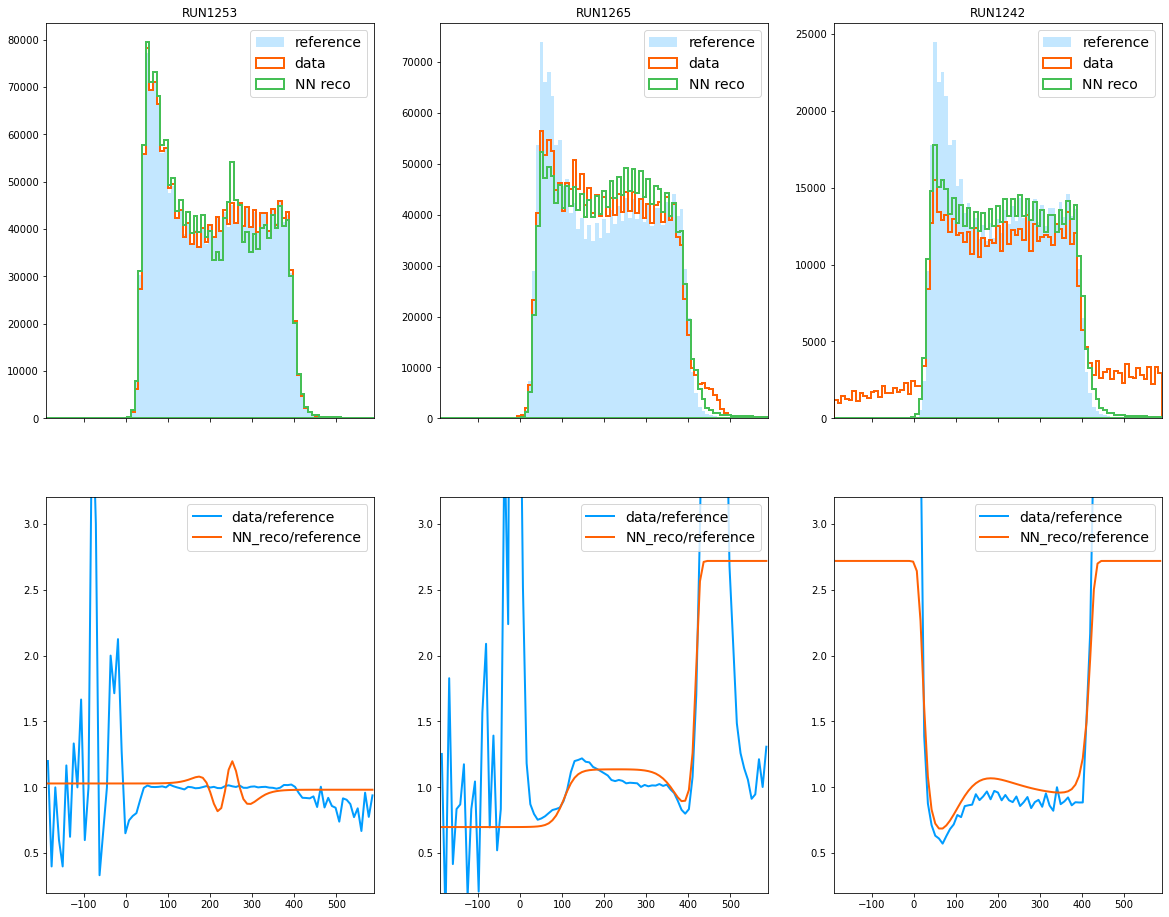

SAMPLE N: 2


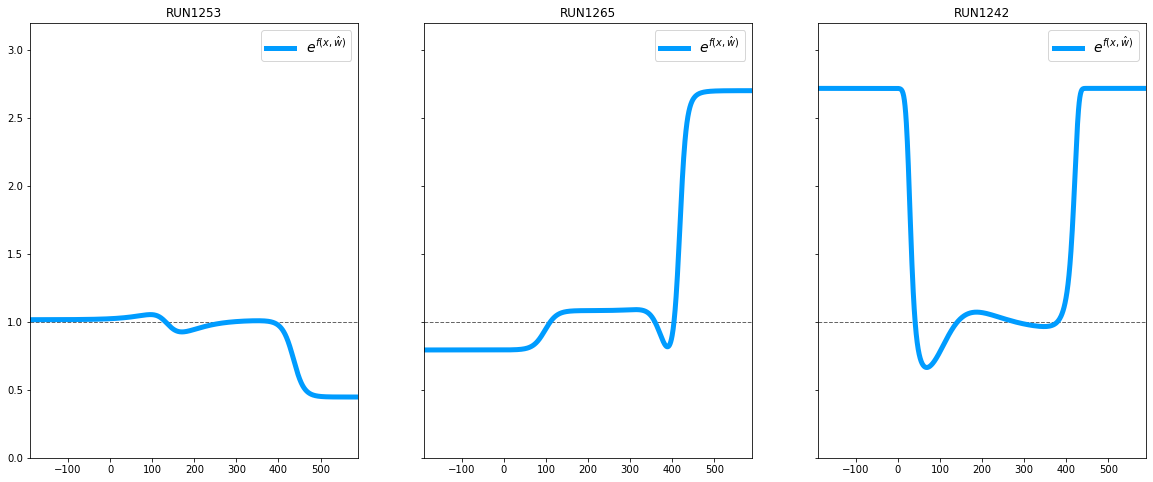

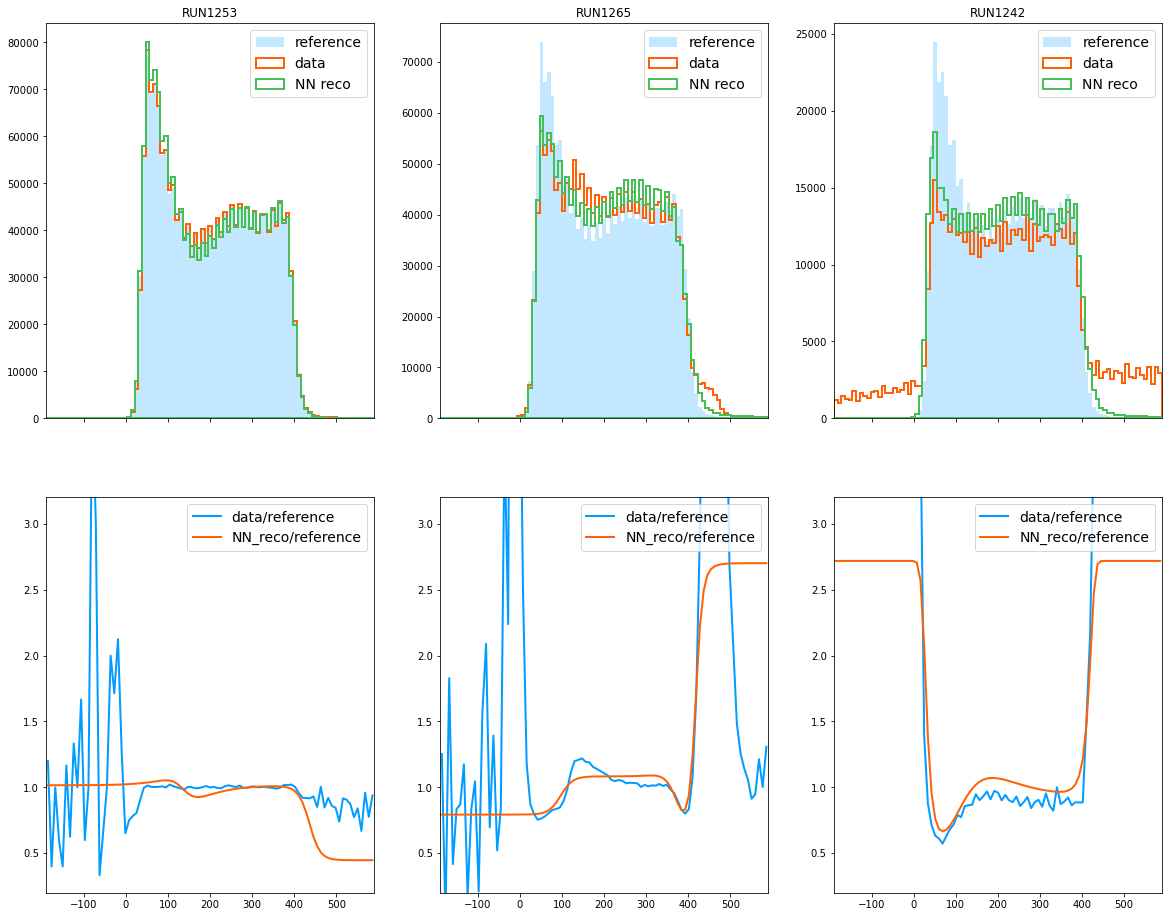

SAMPLE N: 3


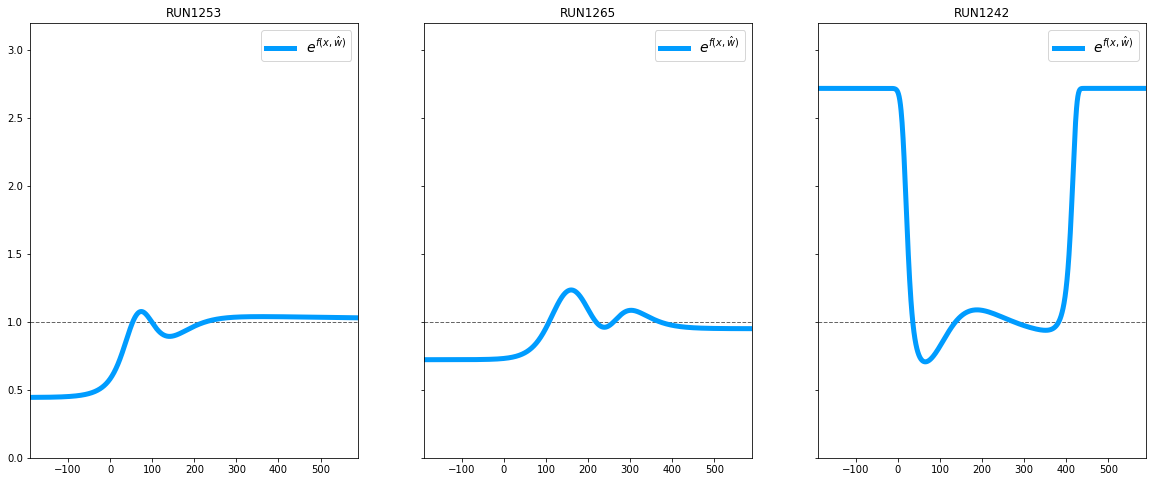

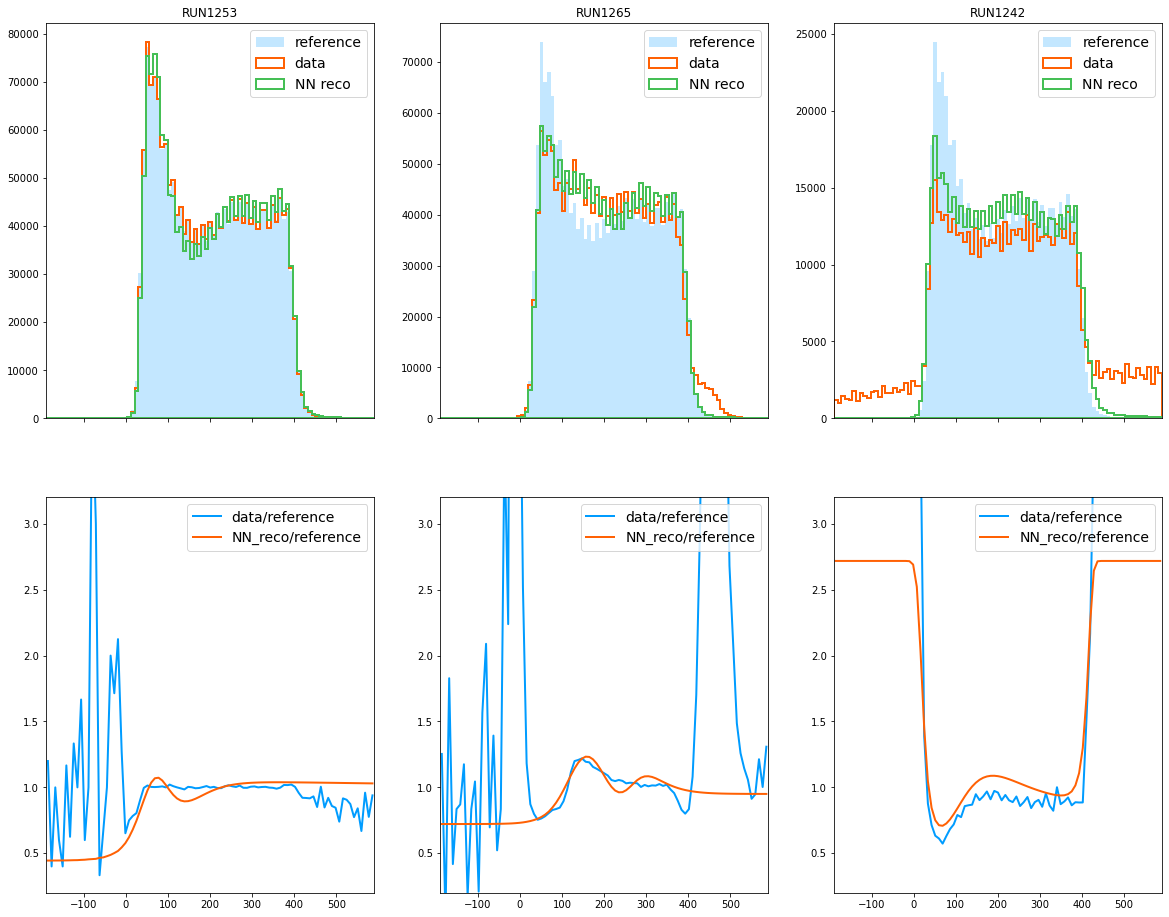

SAMPLE N: 4


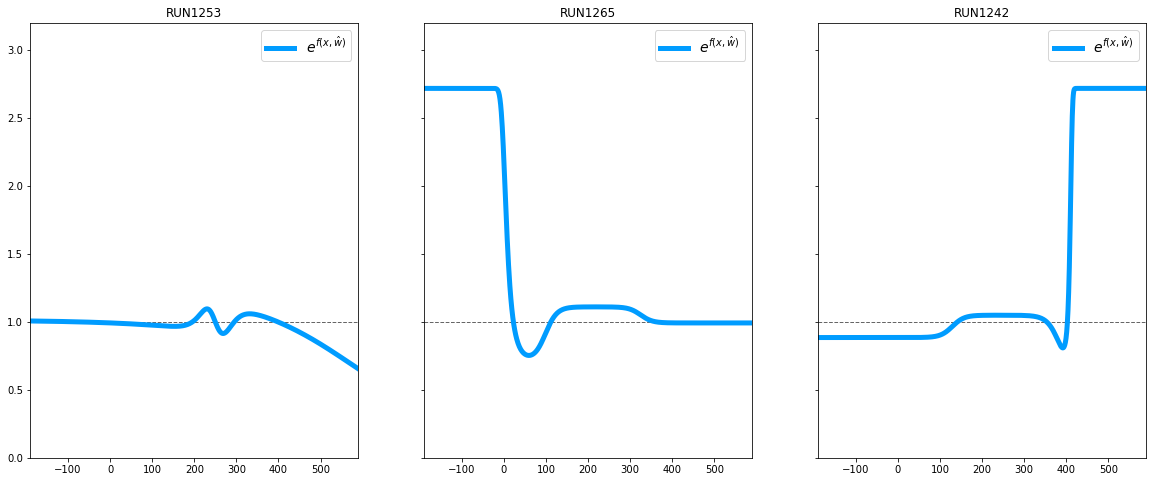

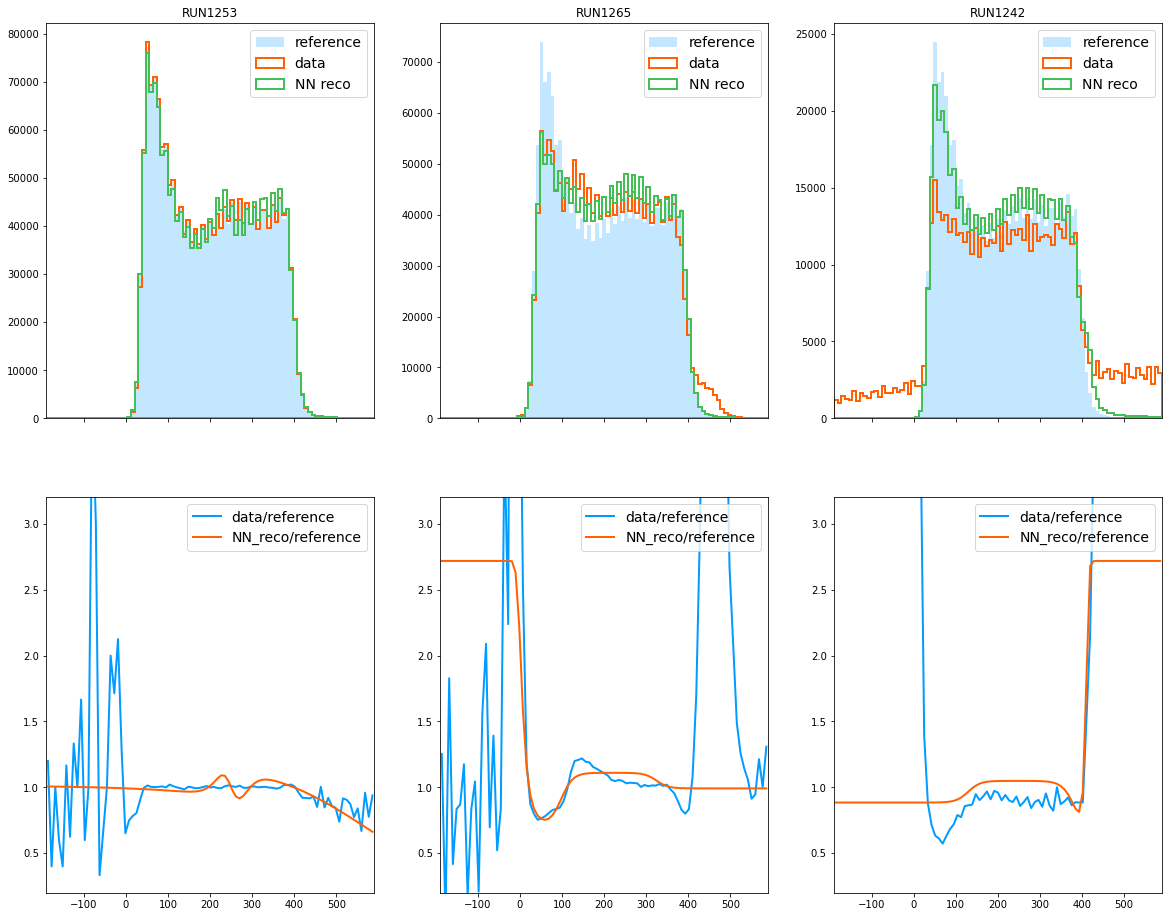

SAMPLE N: 5


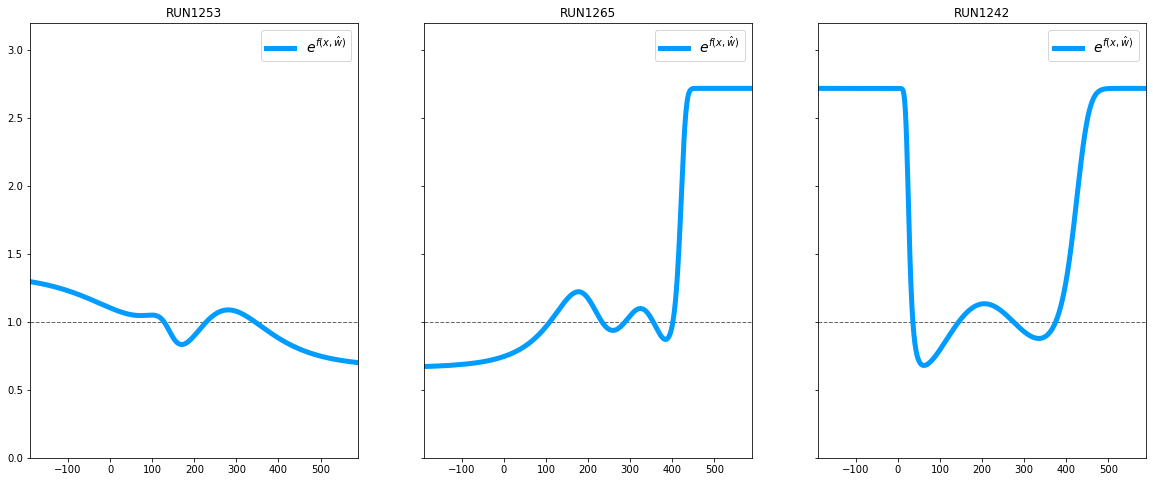

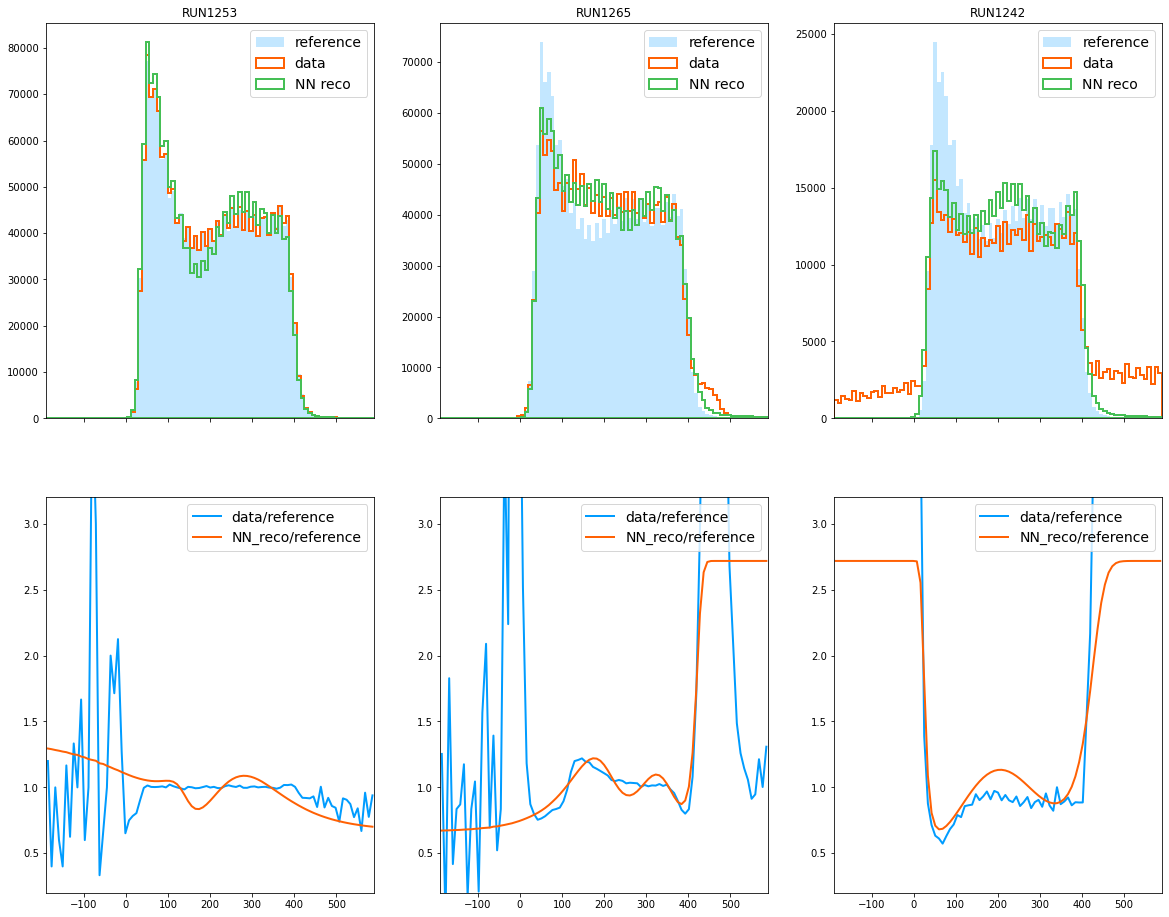

SAMPLE N: 6


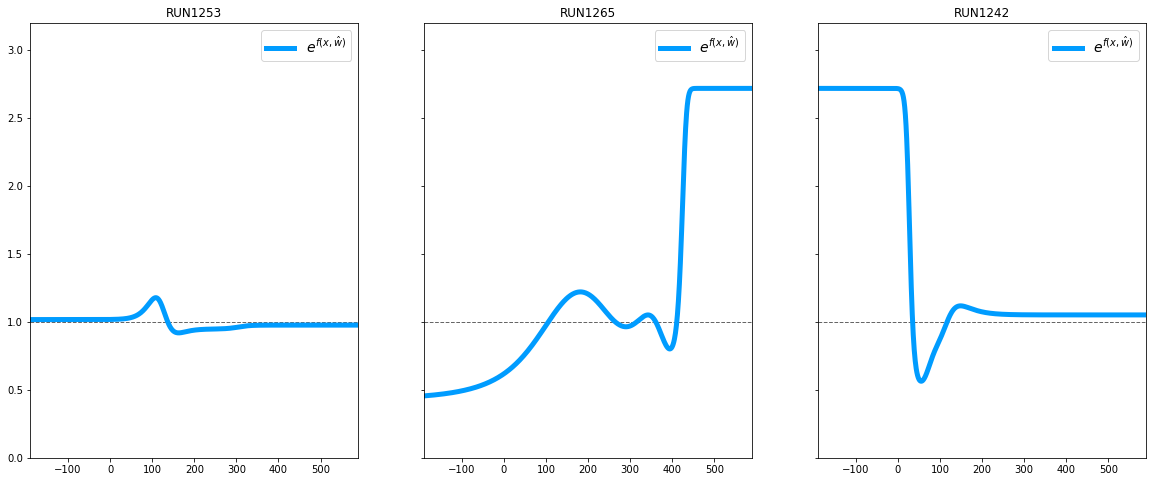

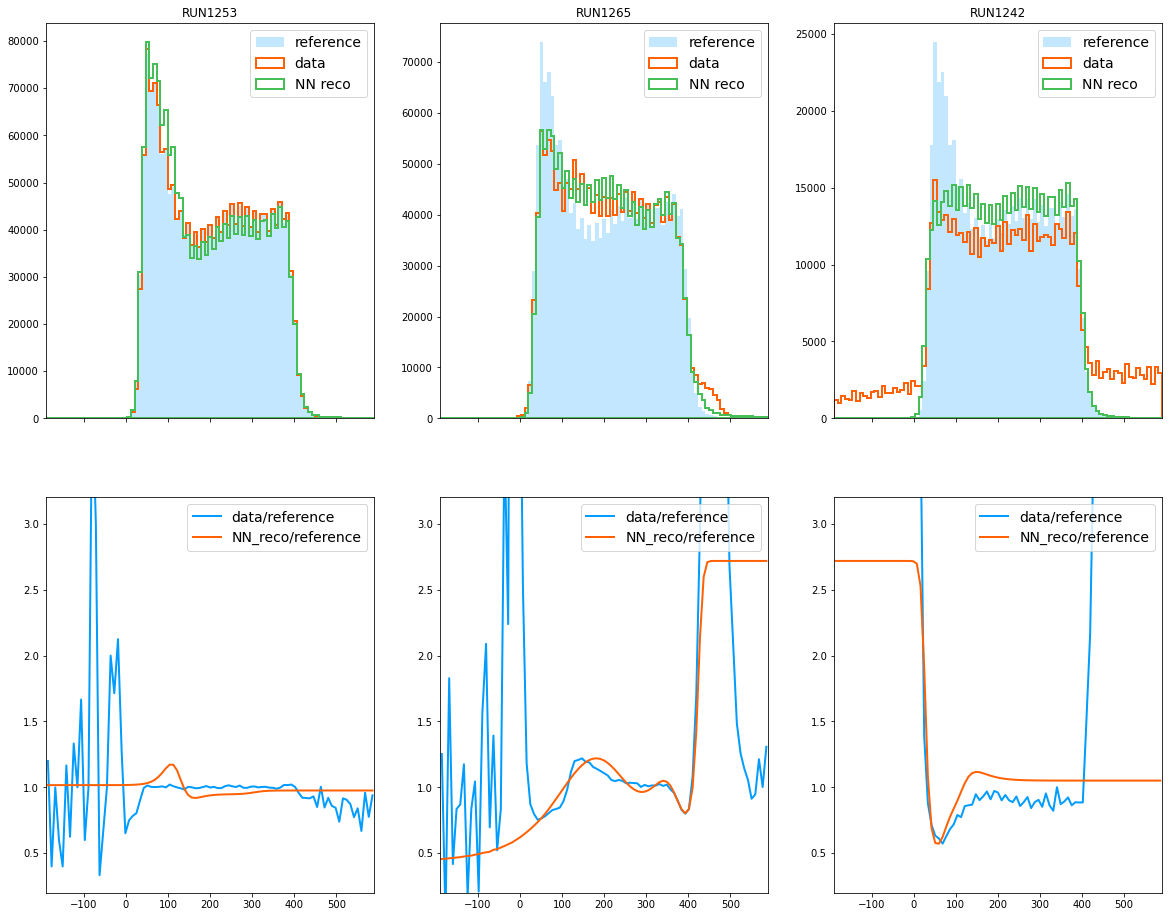

SAMPLE N: 7


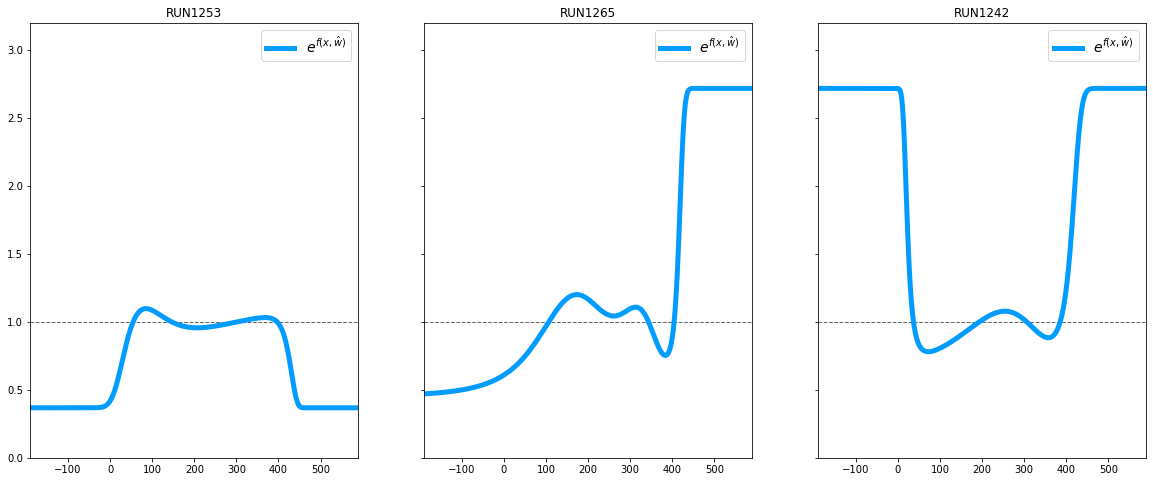

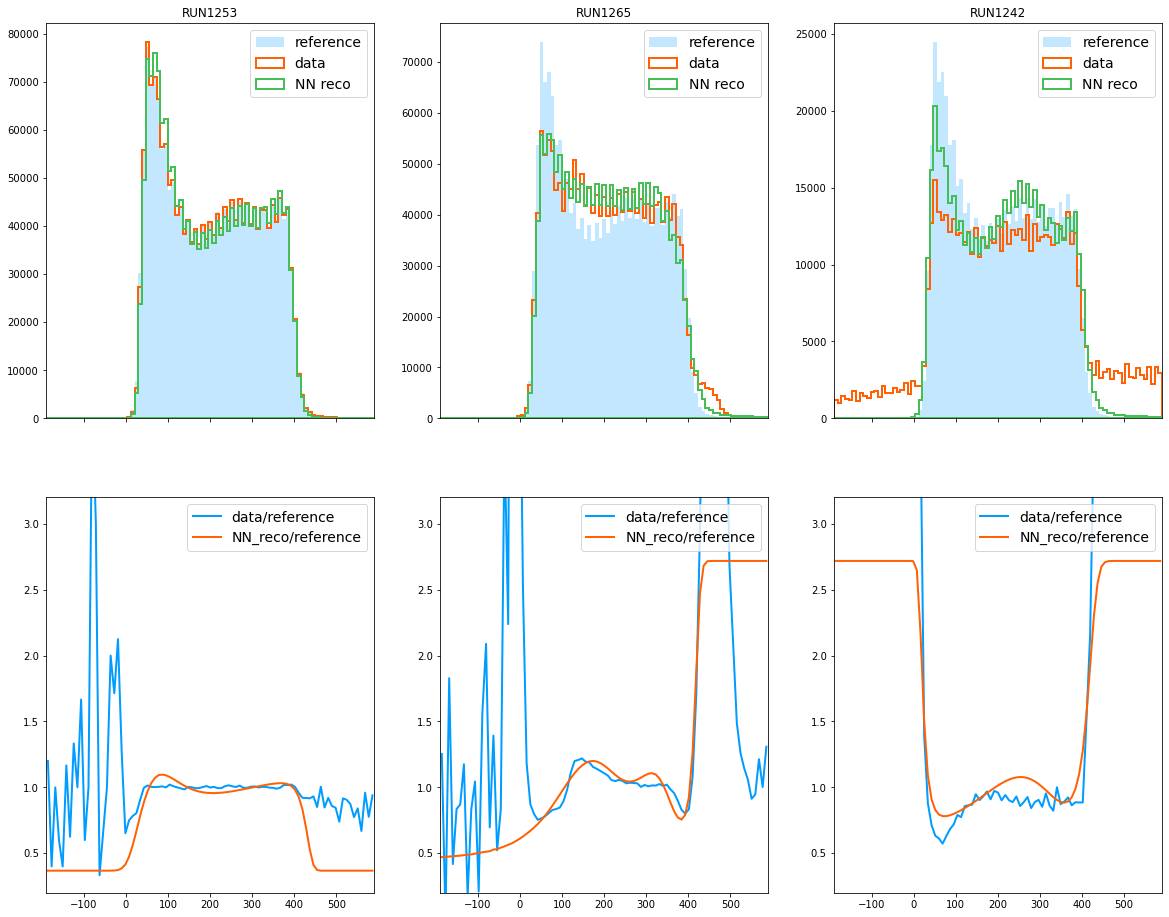

SAMPLE N: 8


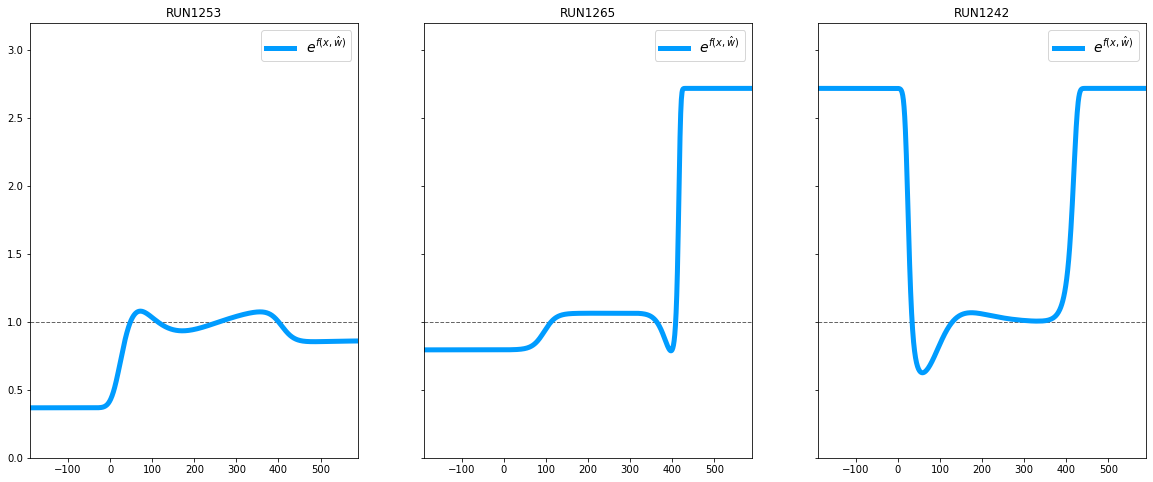

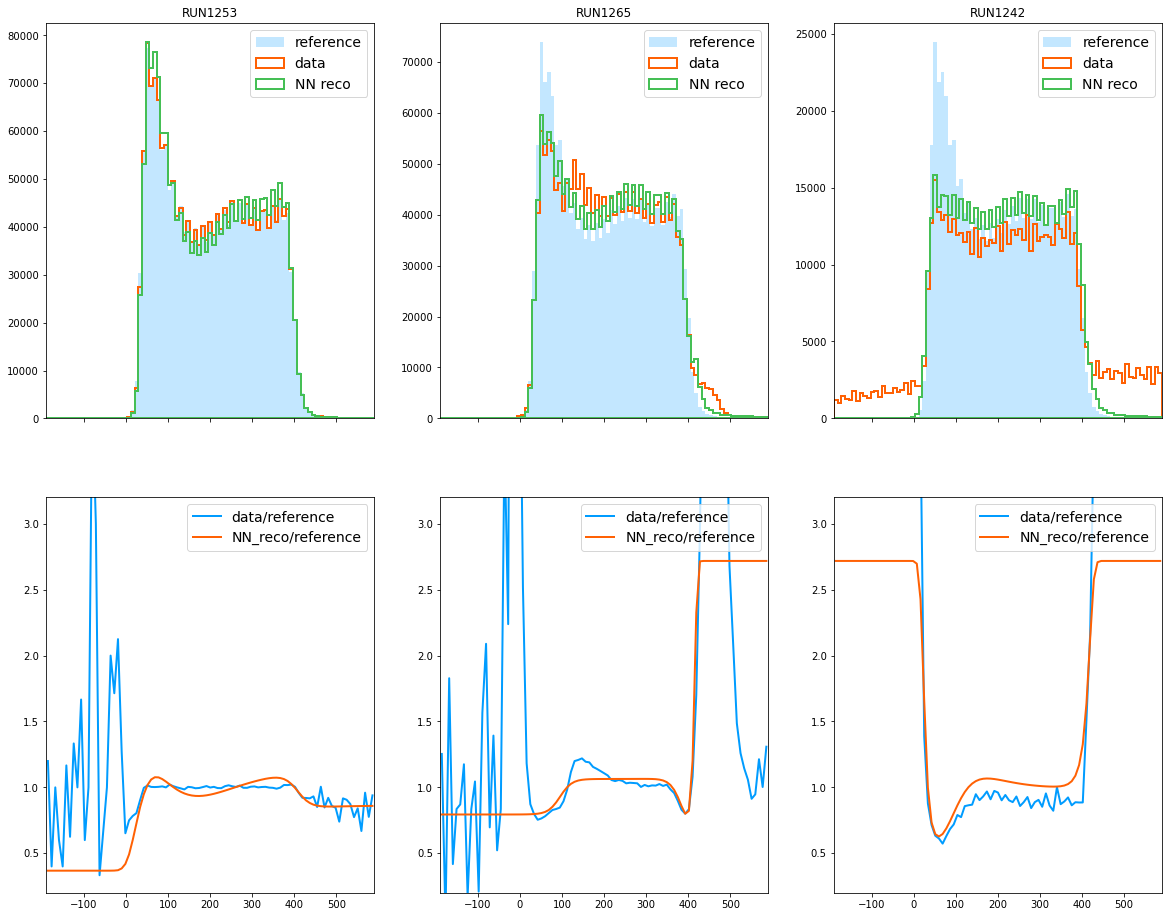

SAMPLE N: 9


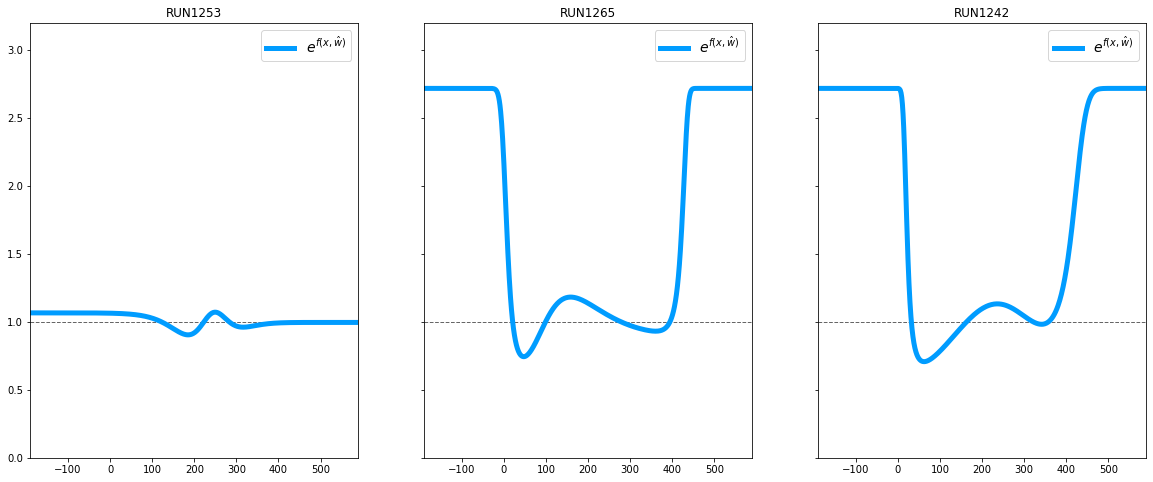

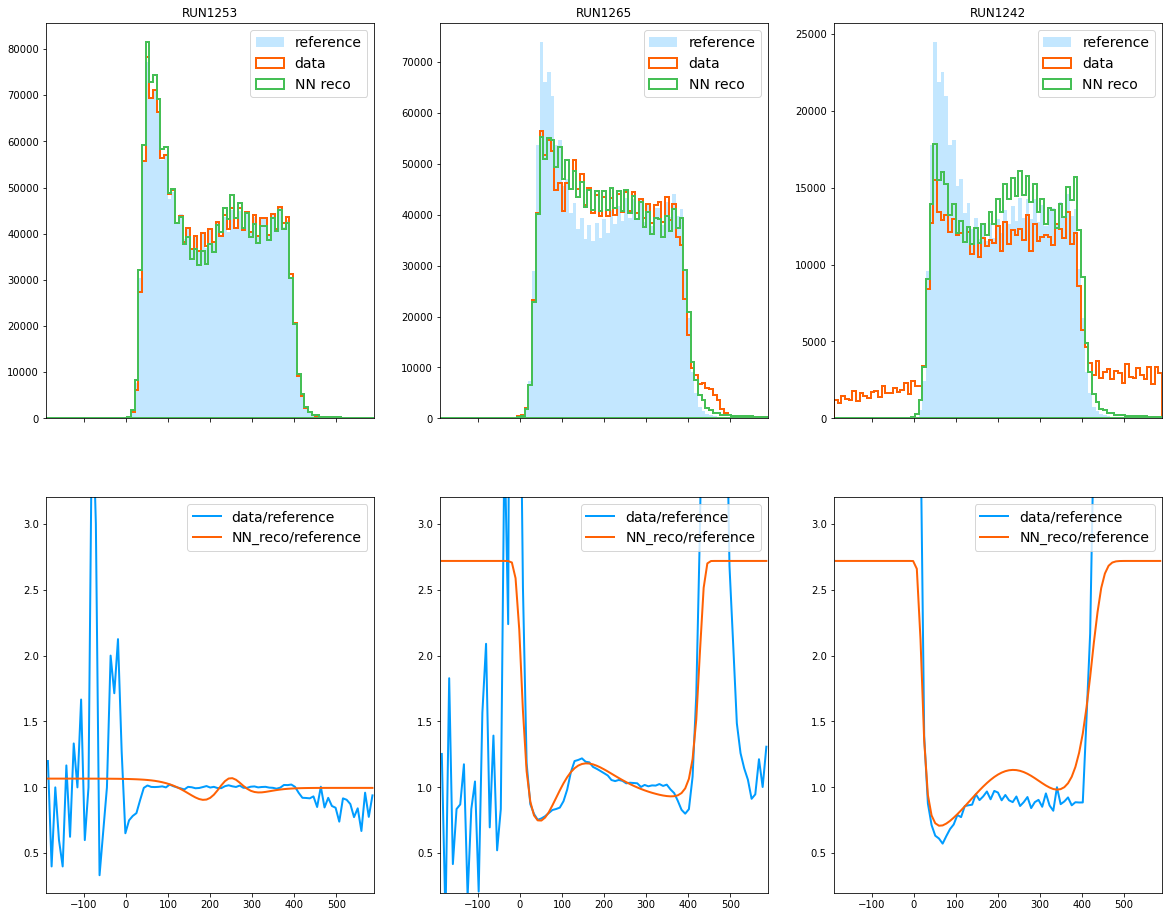

SAMPLE N: 10


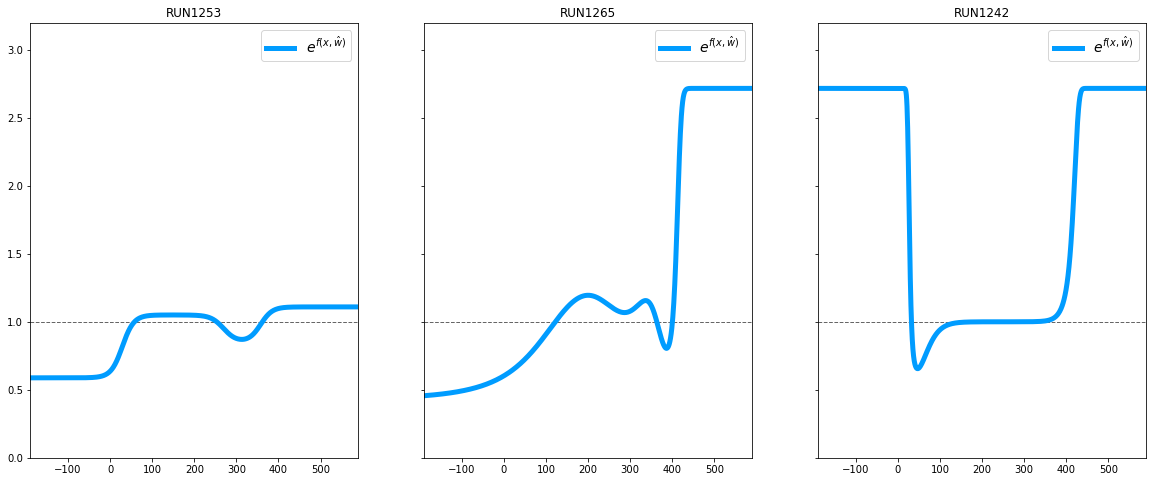

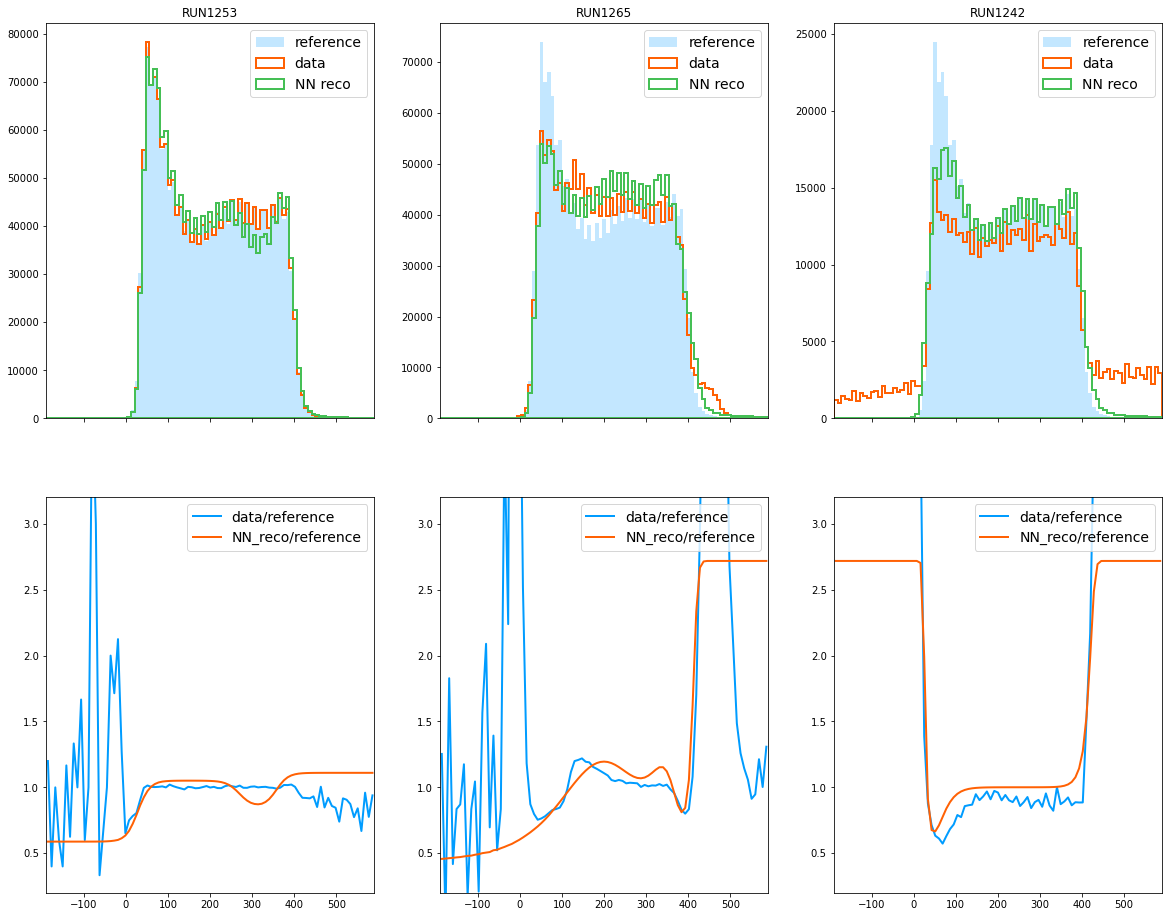

SAMPLE N: 11


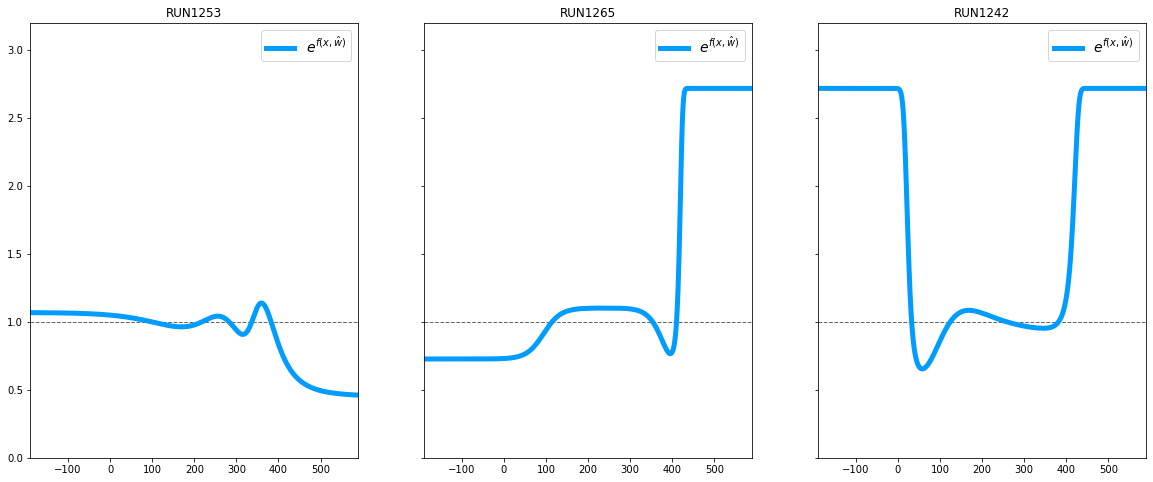

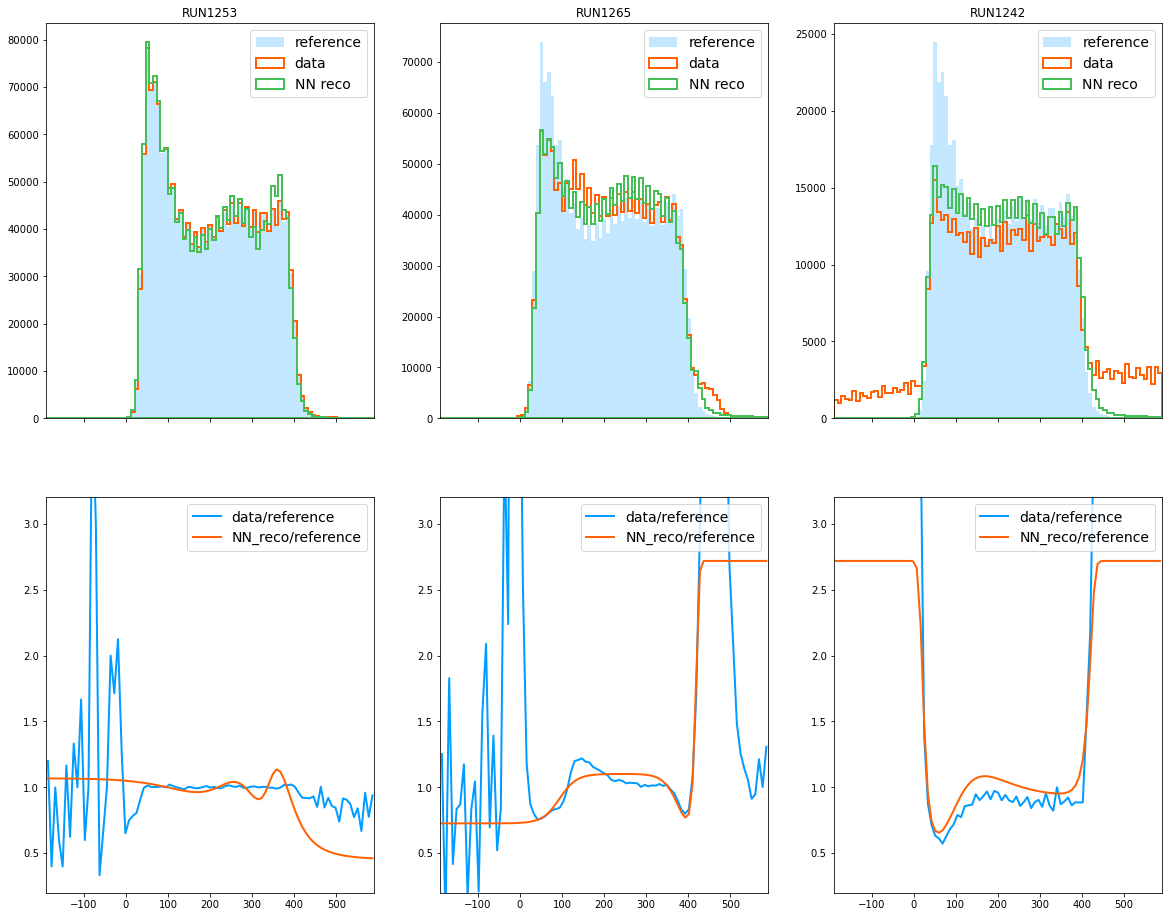

SAMPLE N: 12


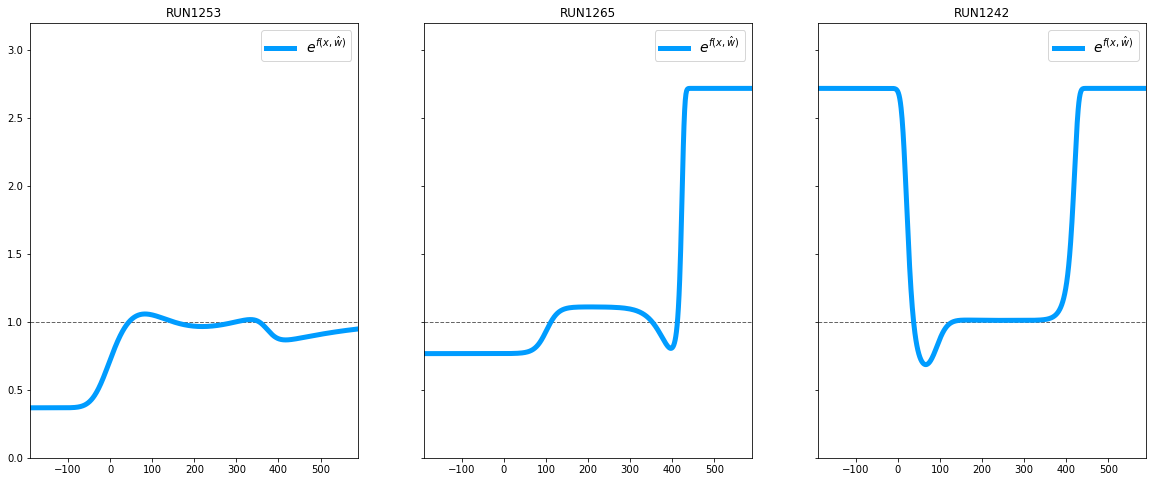

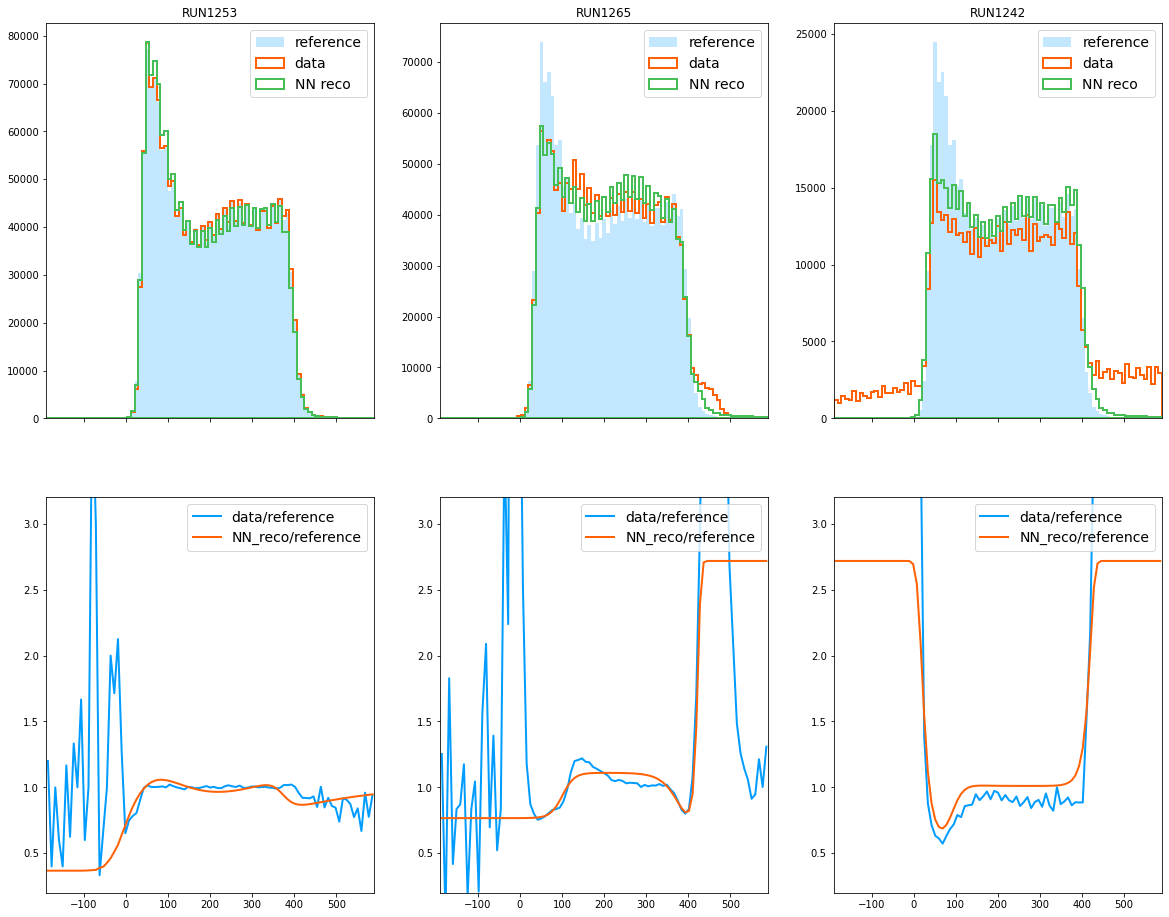

SAMPLE N: 13


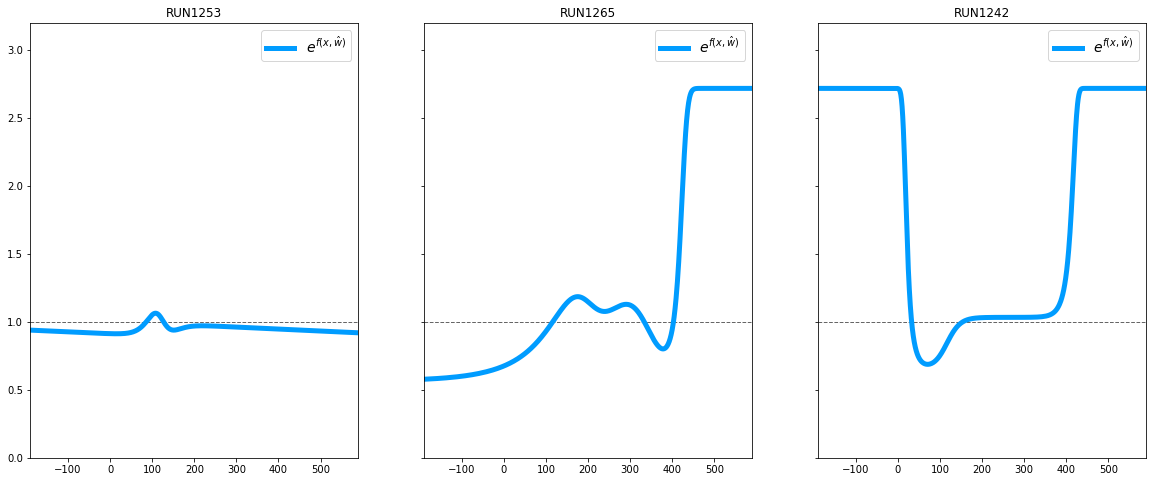

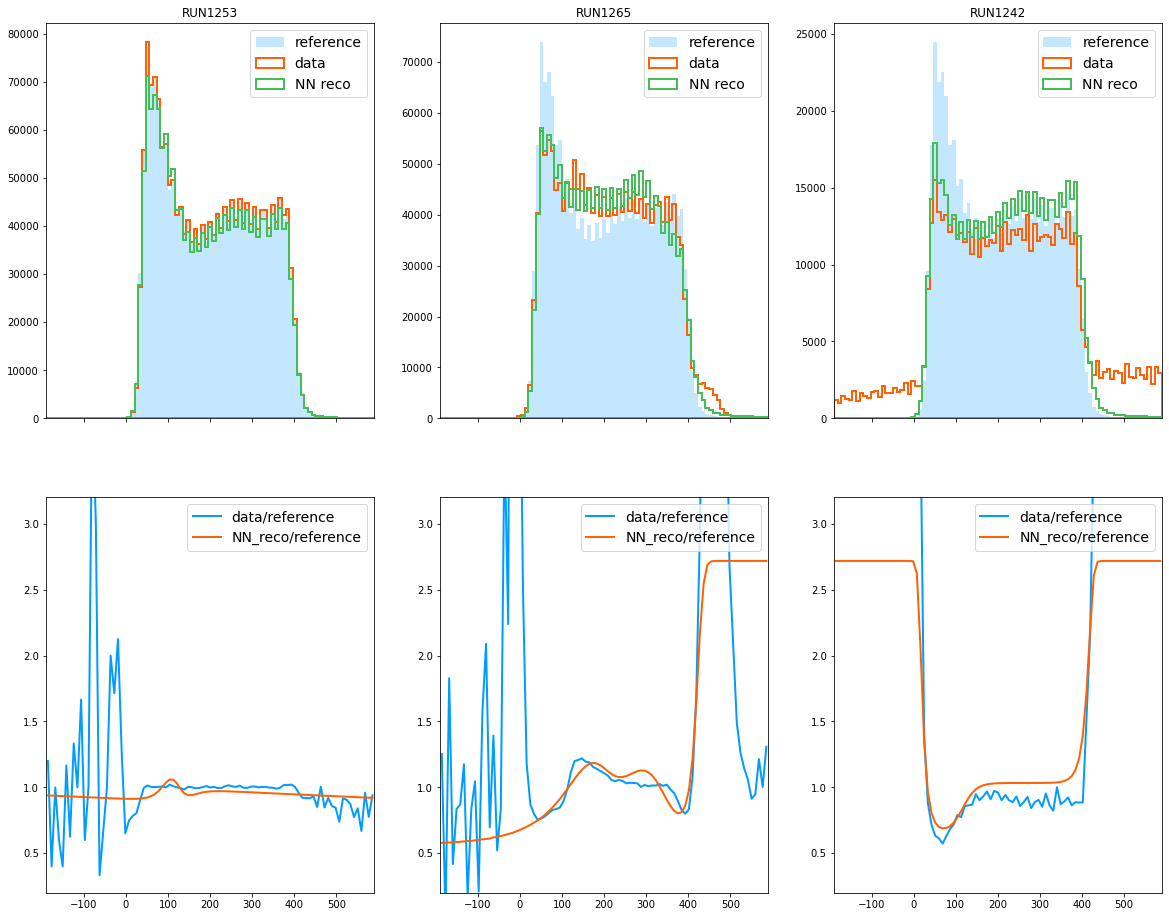

SAMPLE N: 14


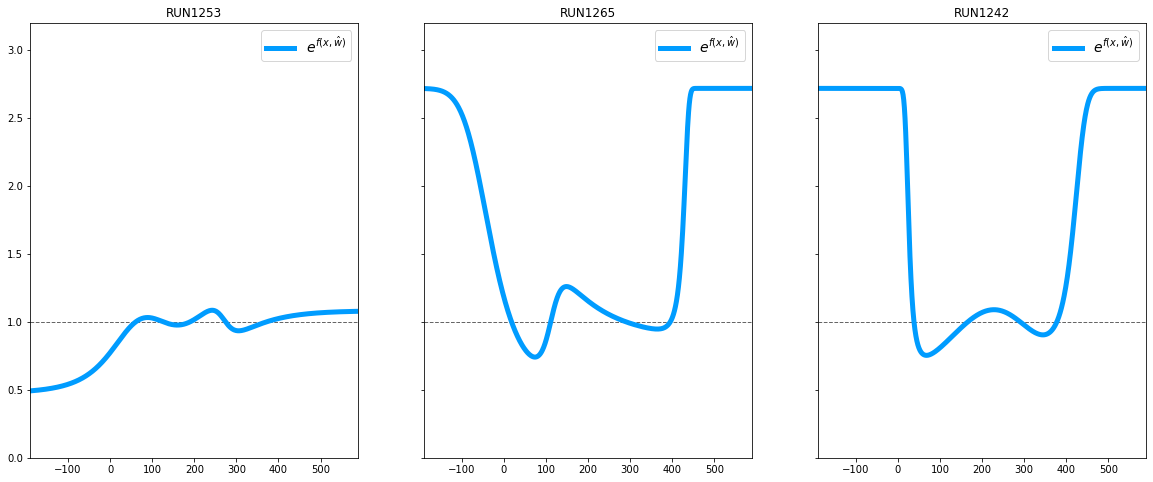

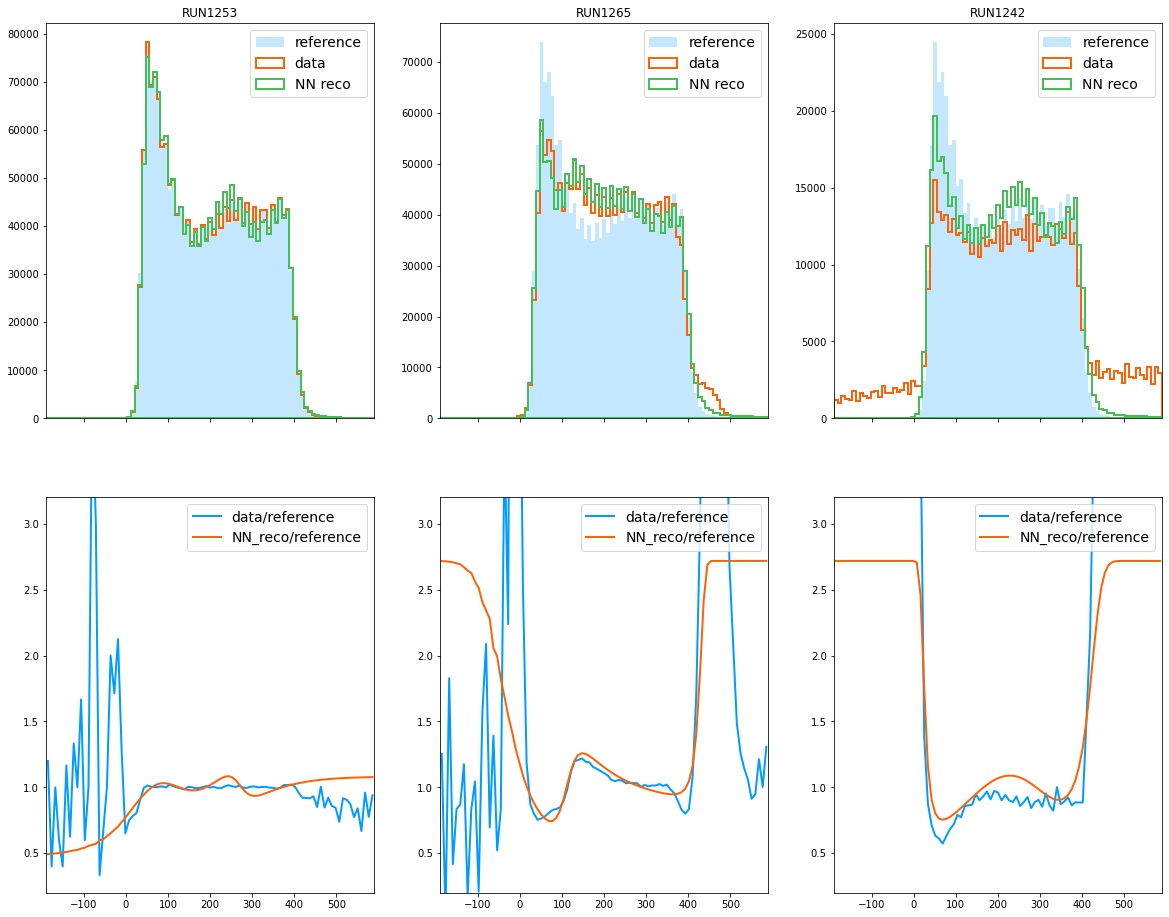

SAMPLE N: 15


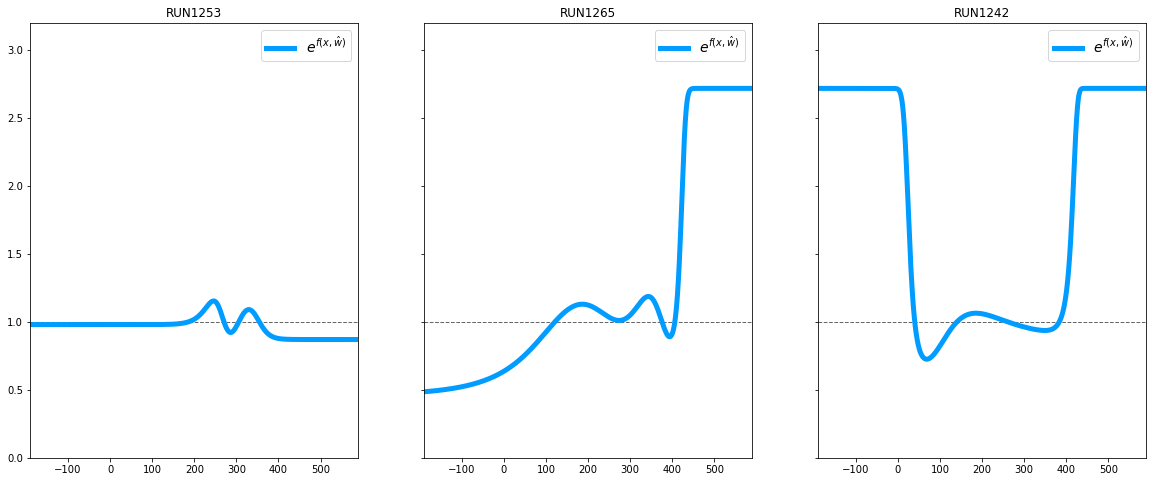

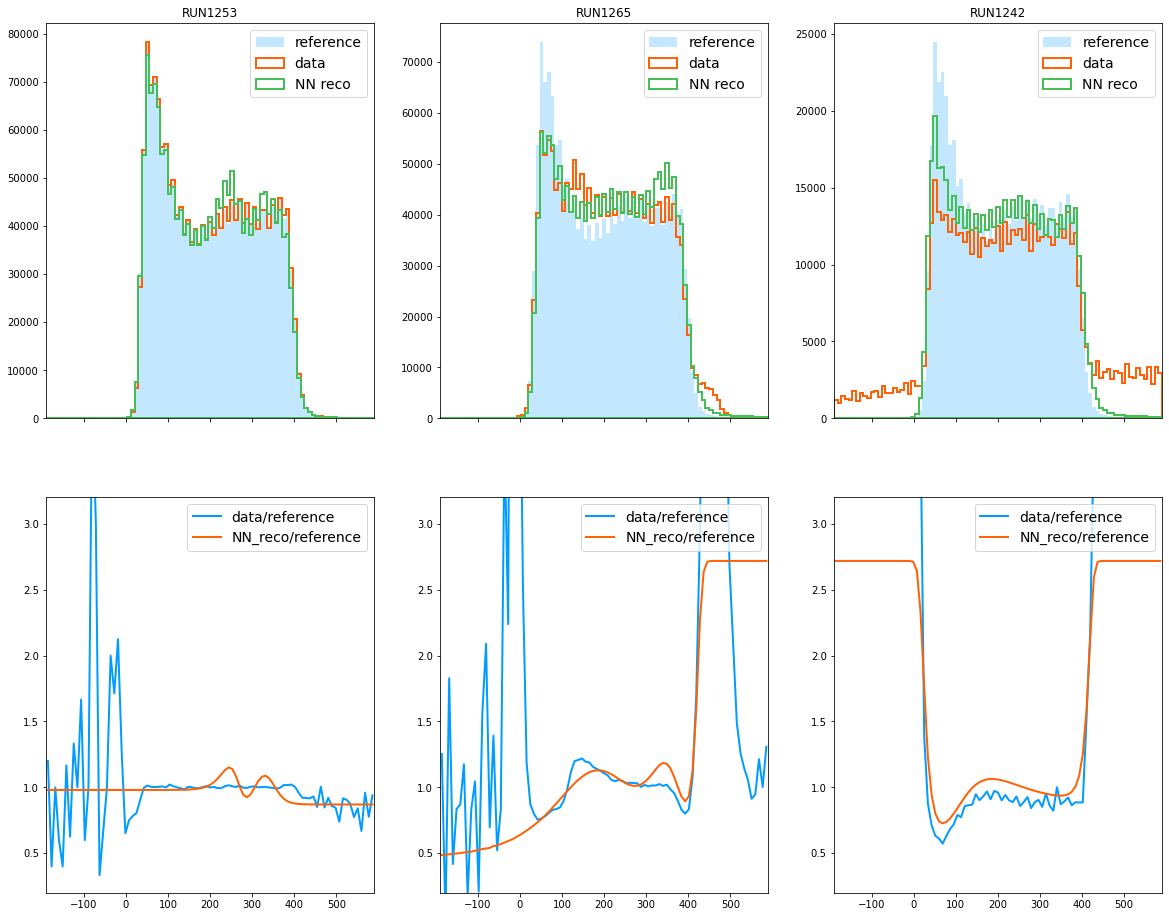

SAMPLE N: 16


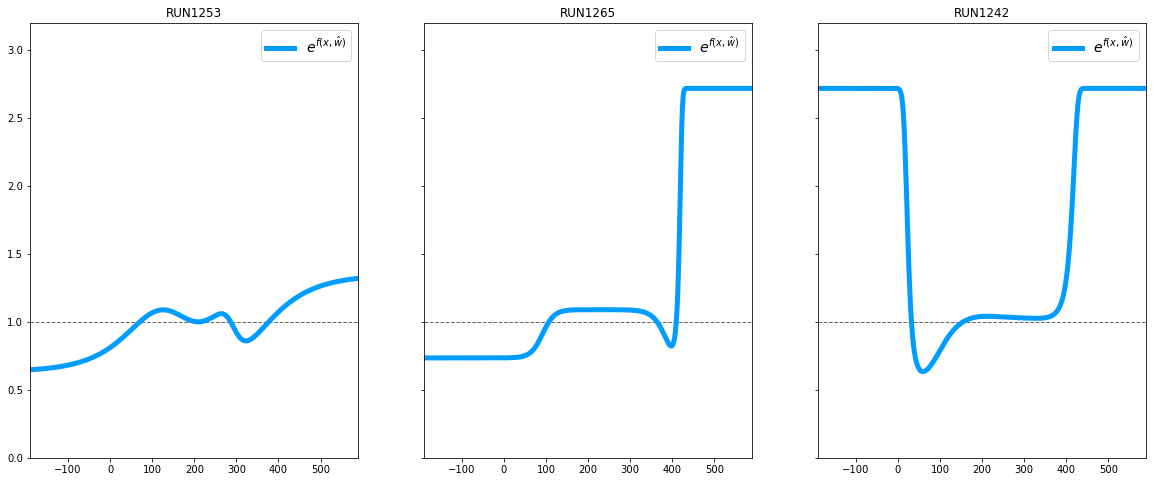

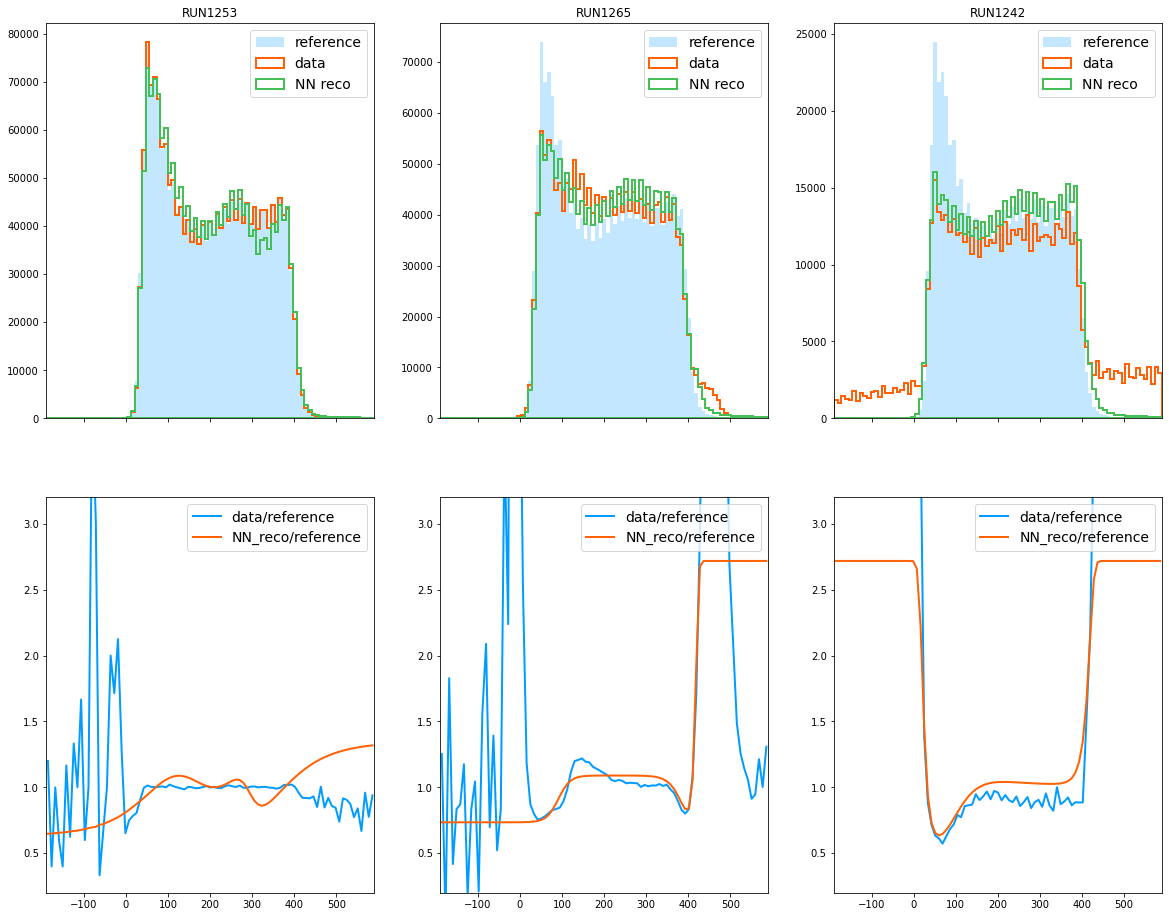

SAMPLE N: 17


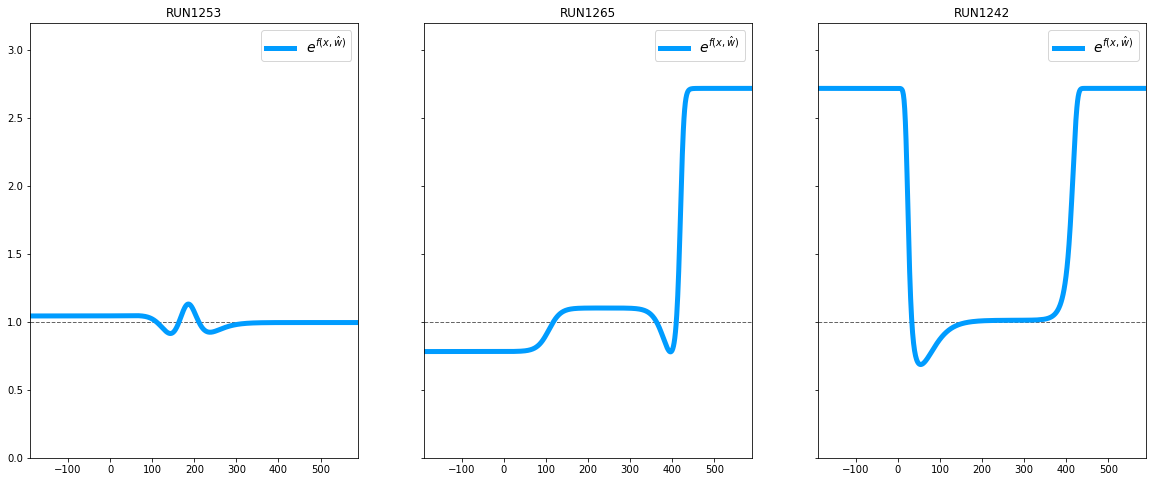

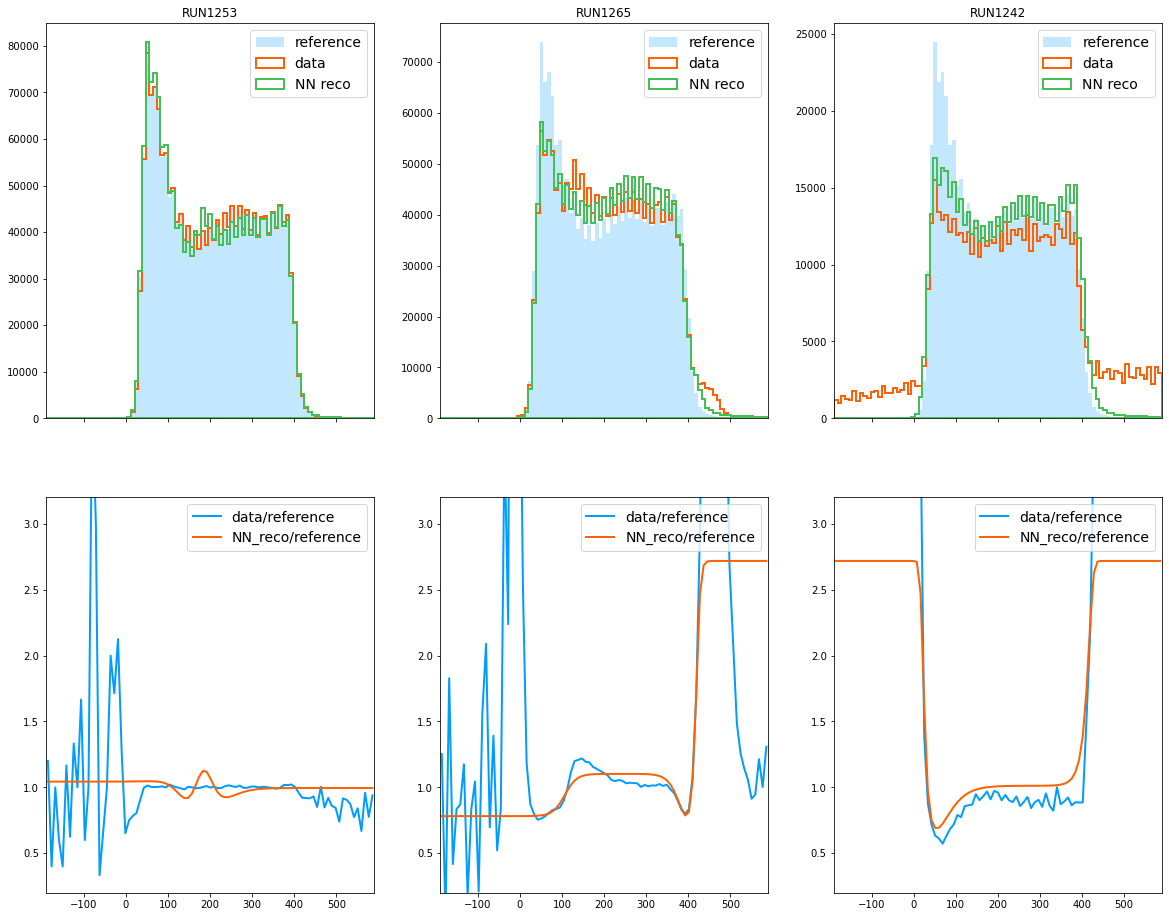

SAMPLE N: 18


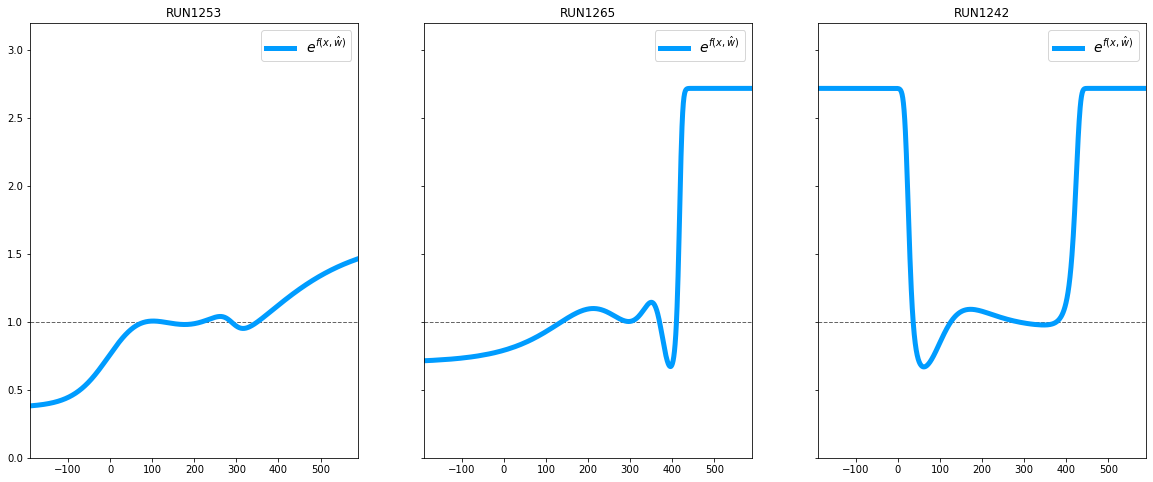

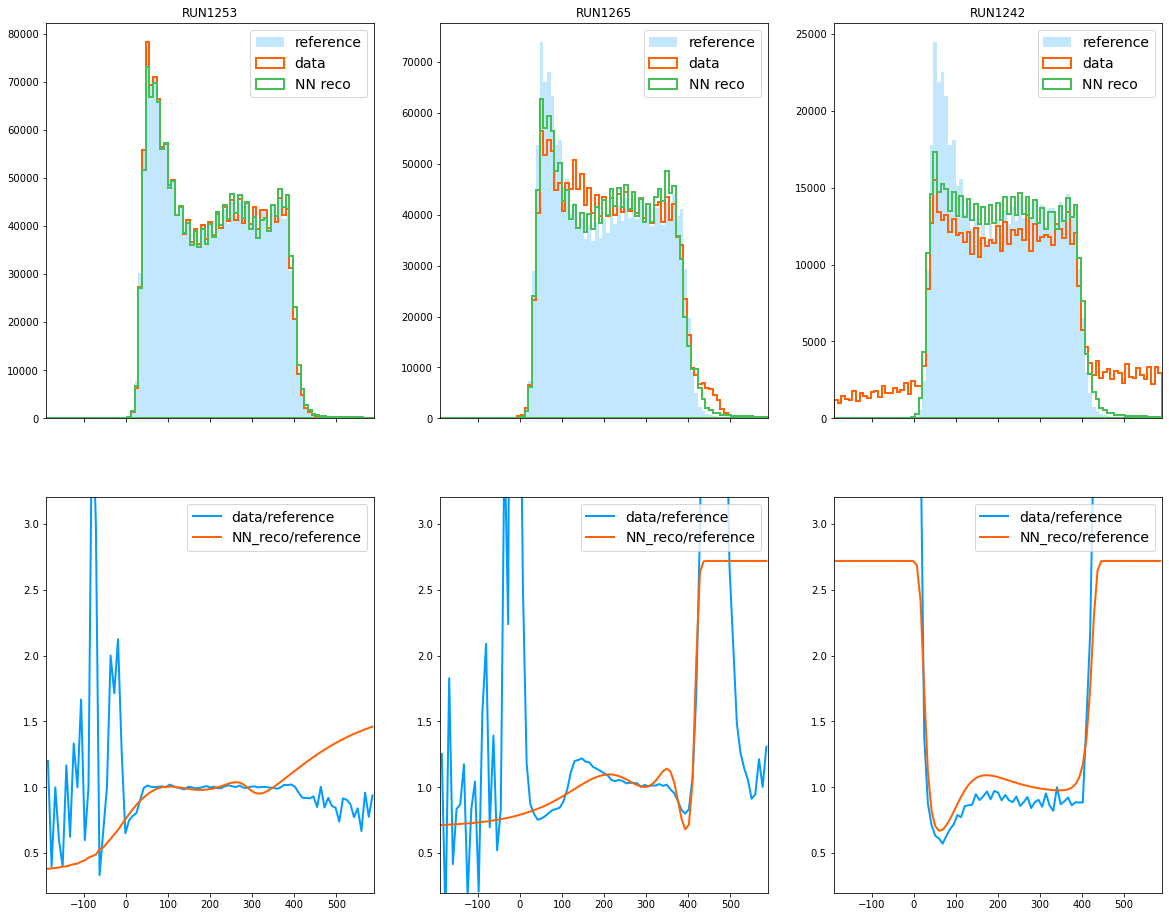

SAMPLE N: 19


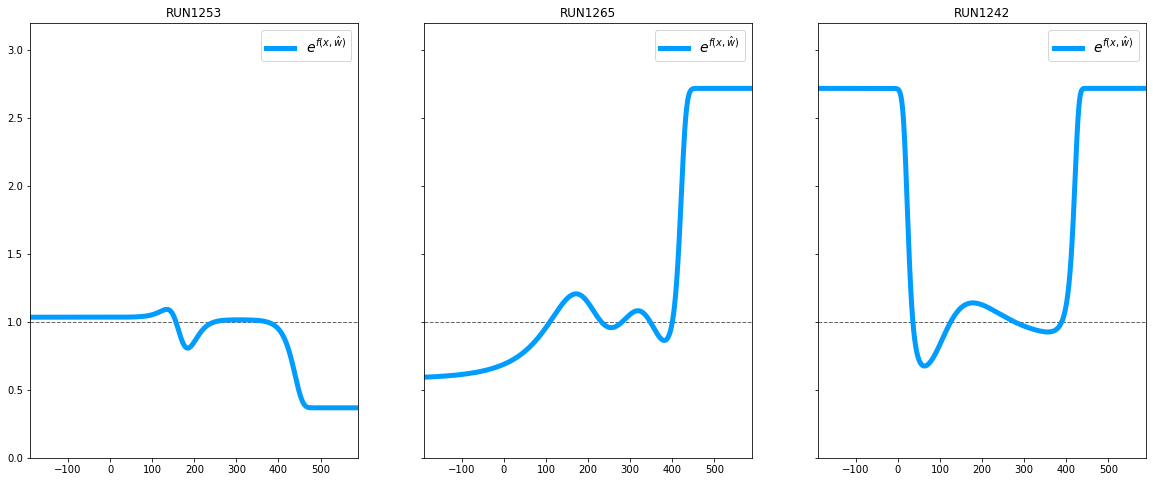

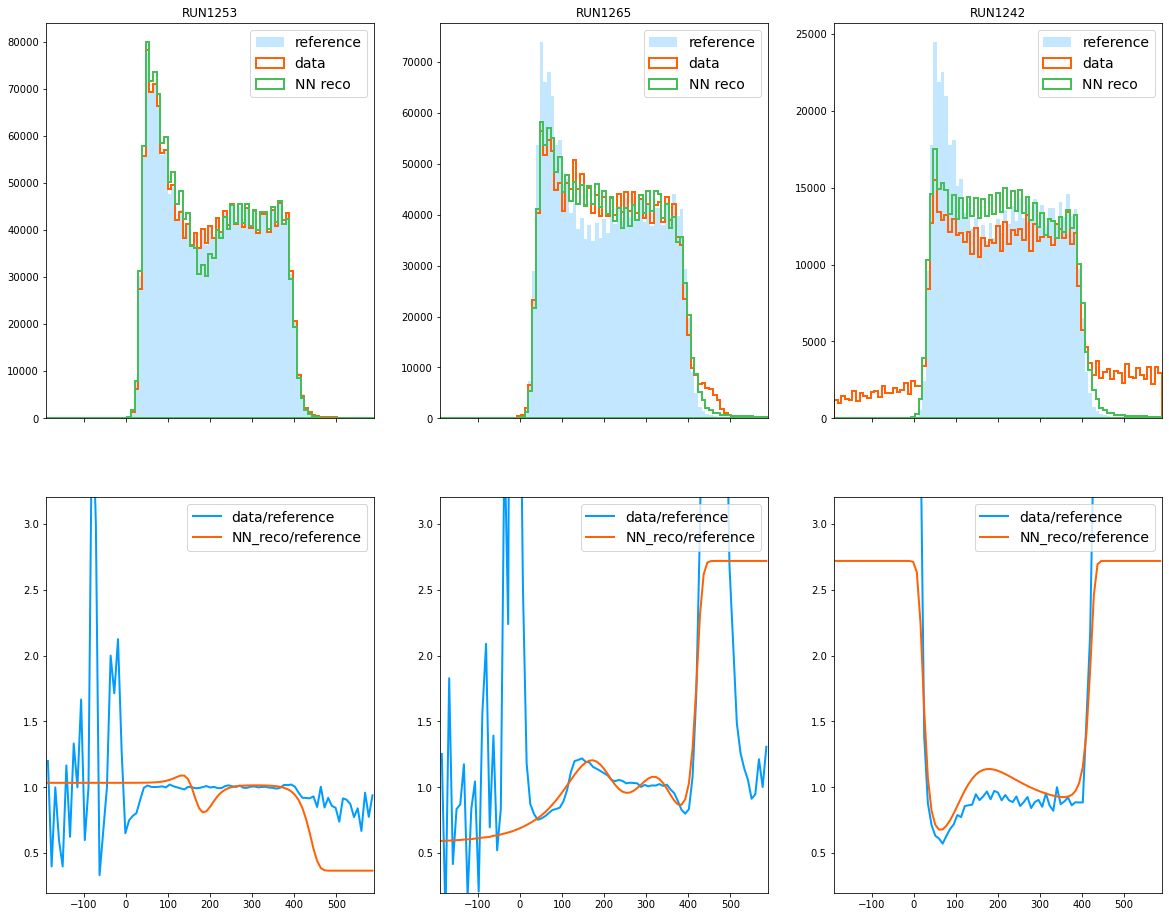

SAMPLE N: 20


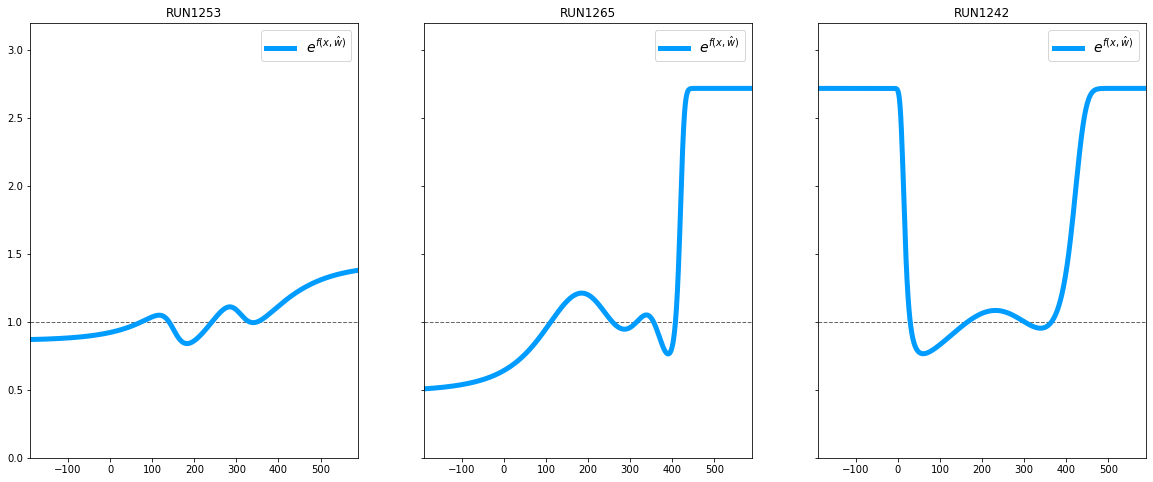

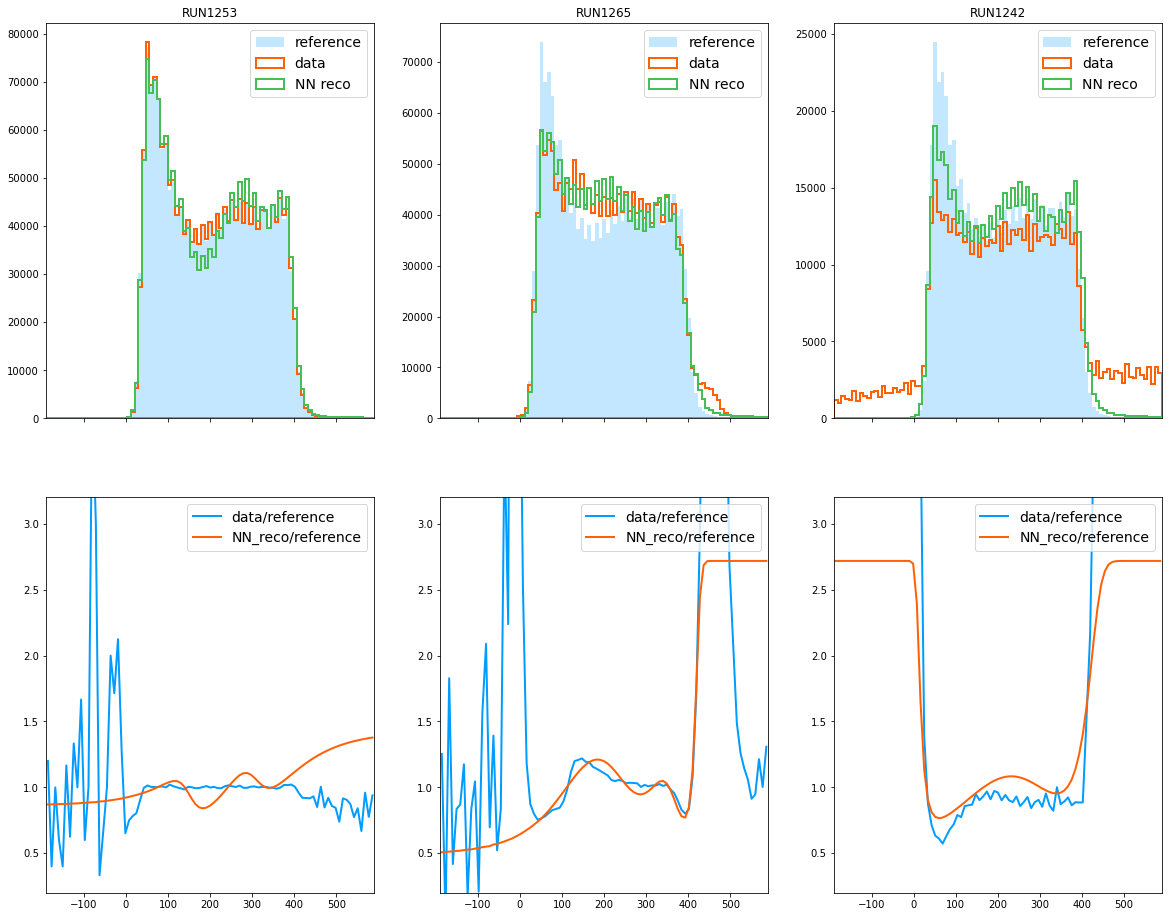

SAMPLE N: 21


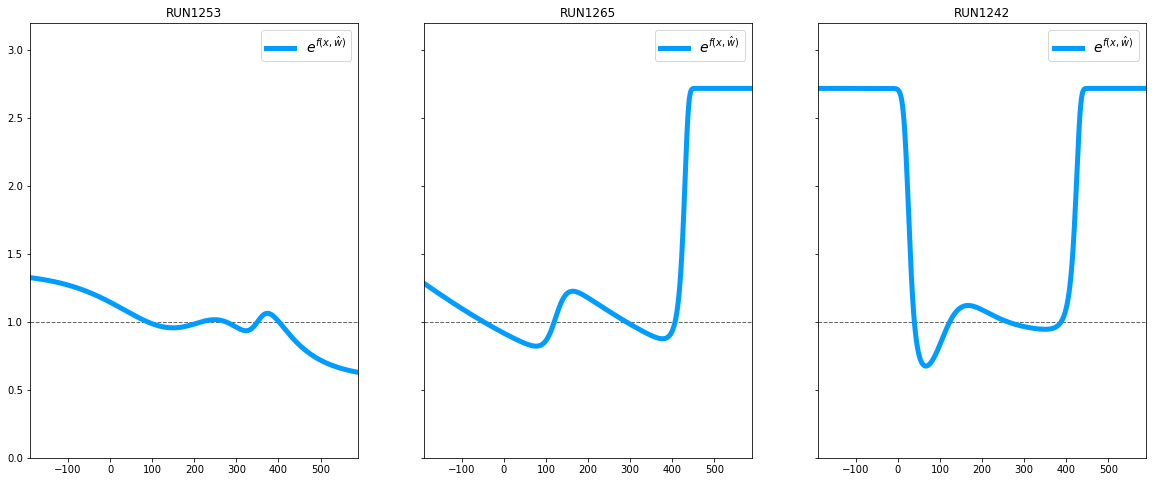

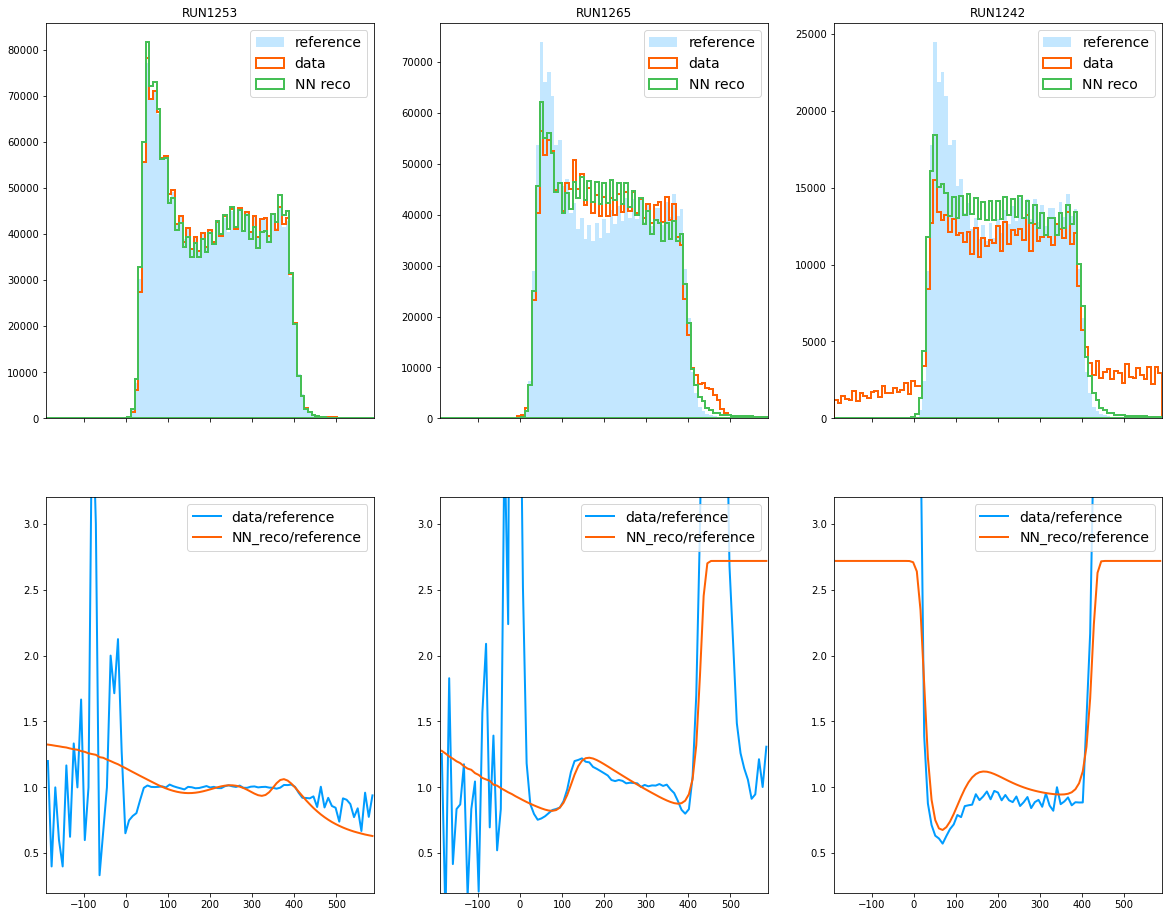

SAMPLE N: 22


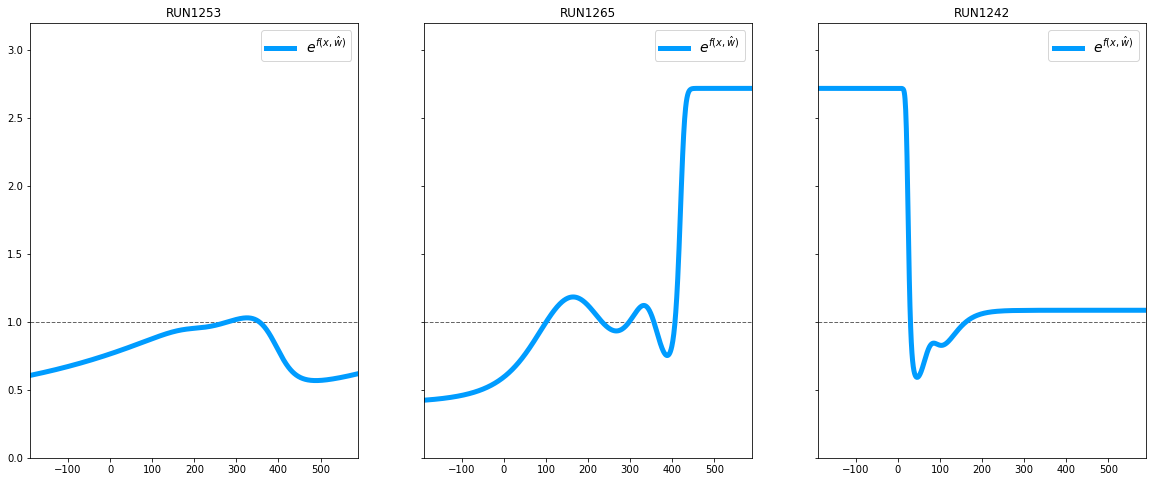

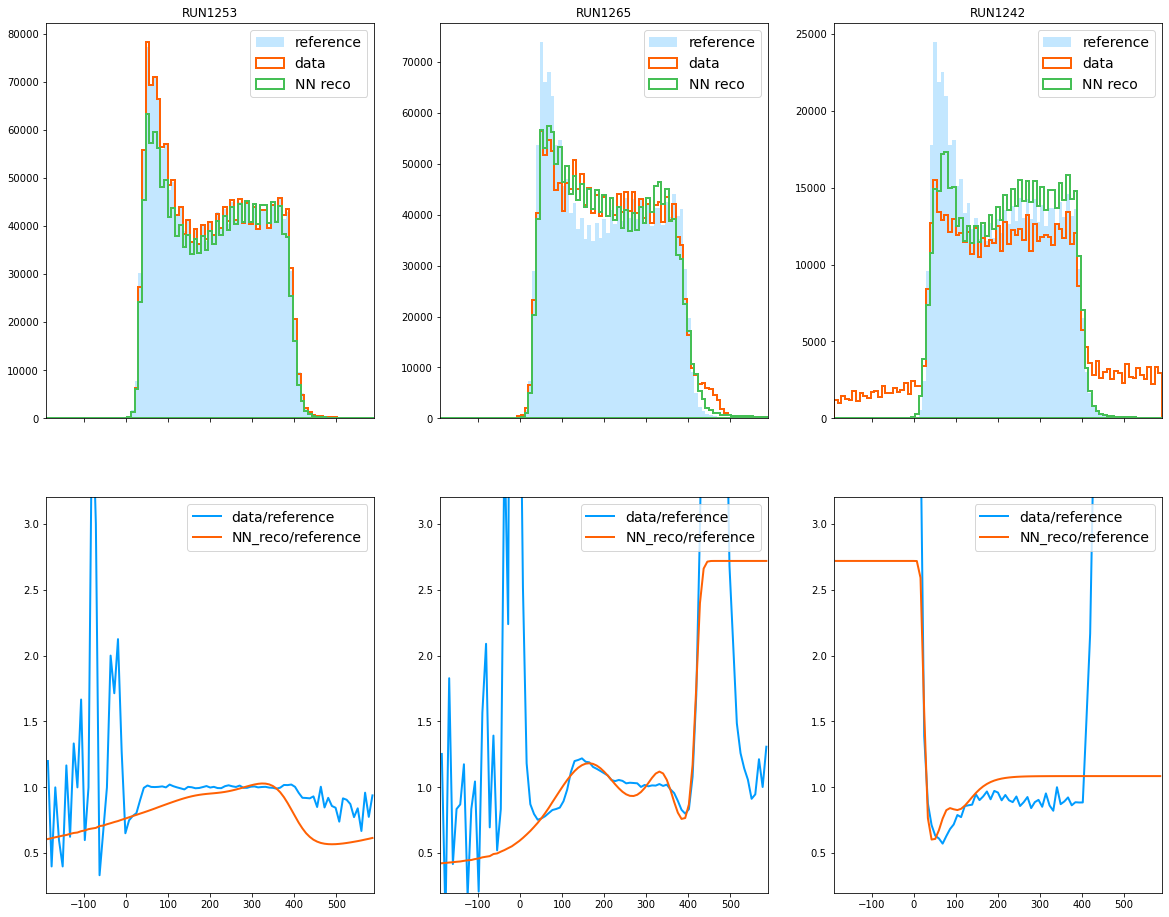

SAMPLE N: 23


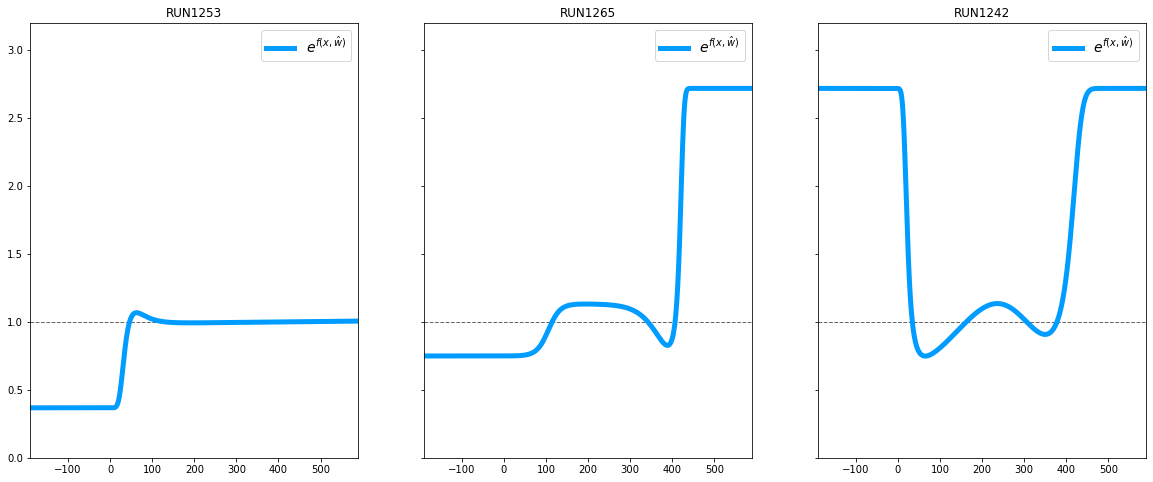

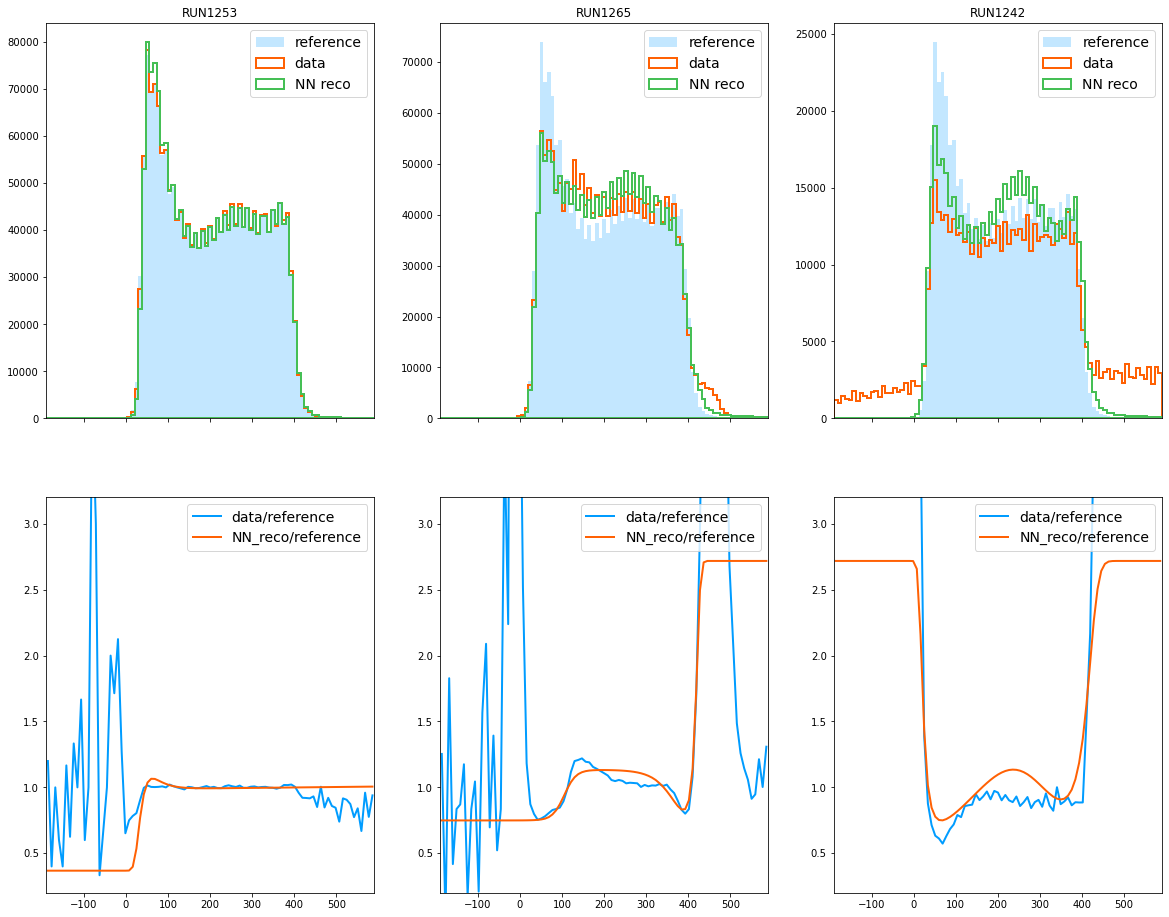

SAMPLE N: 24


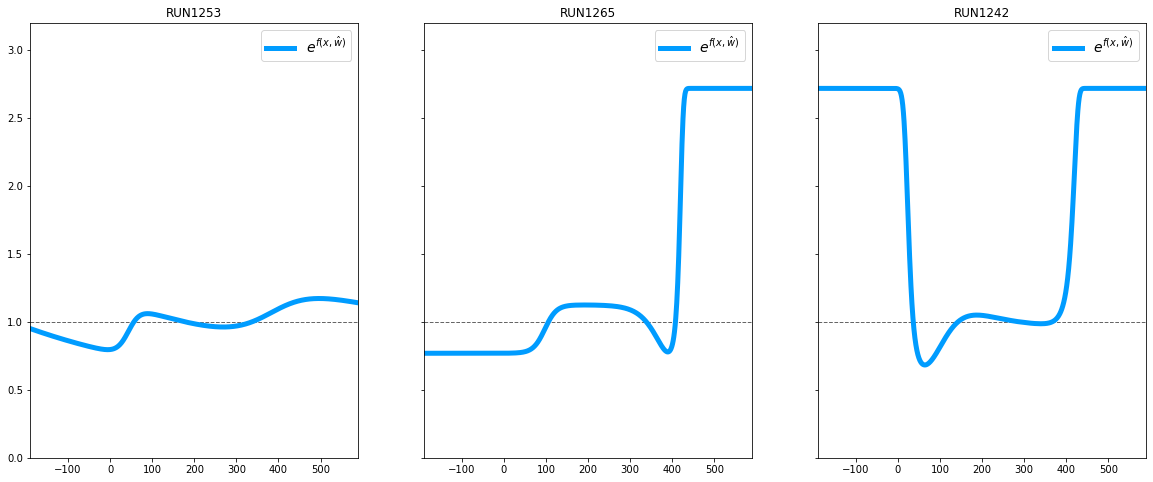

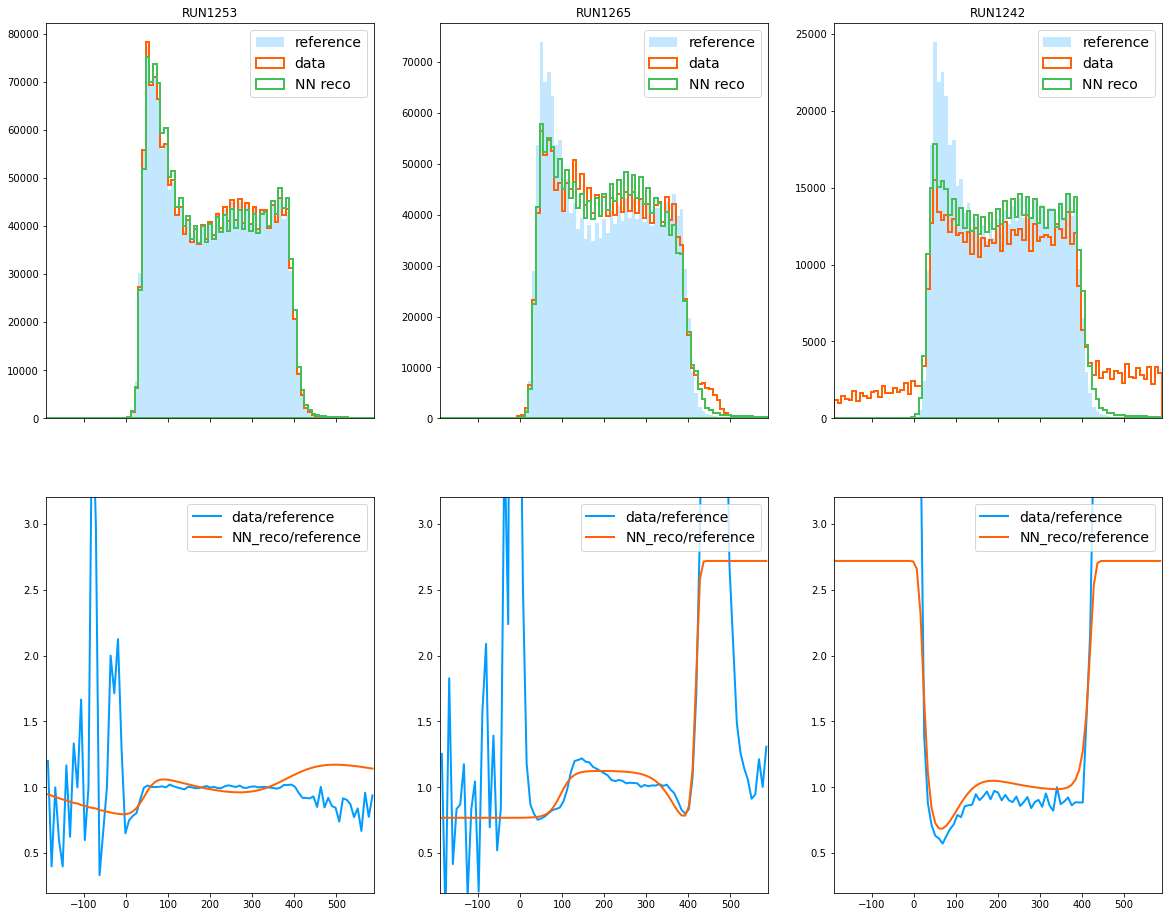

SAMPLE N: 25


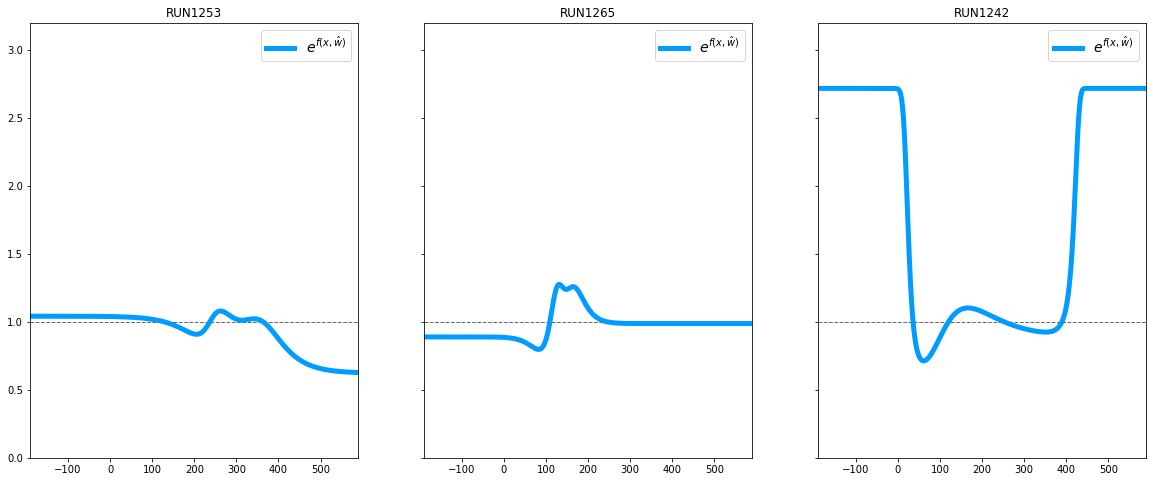

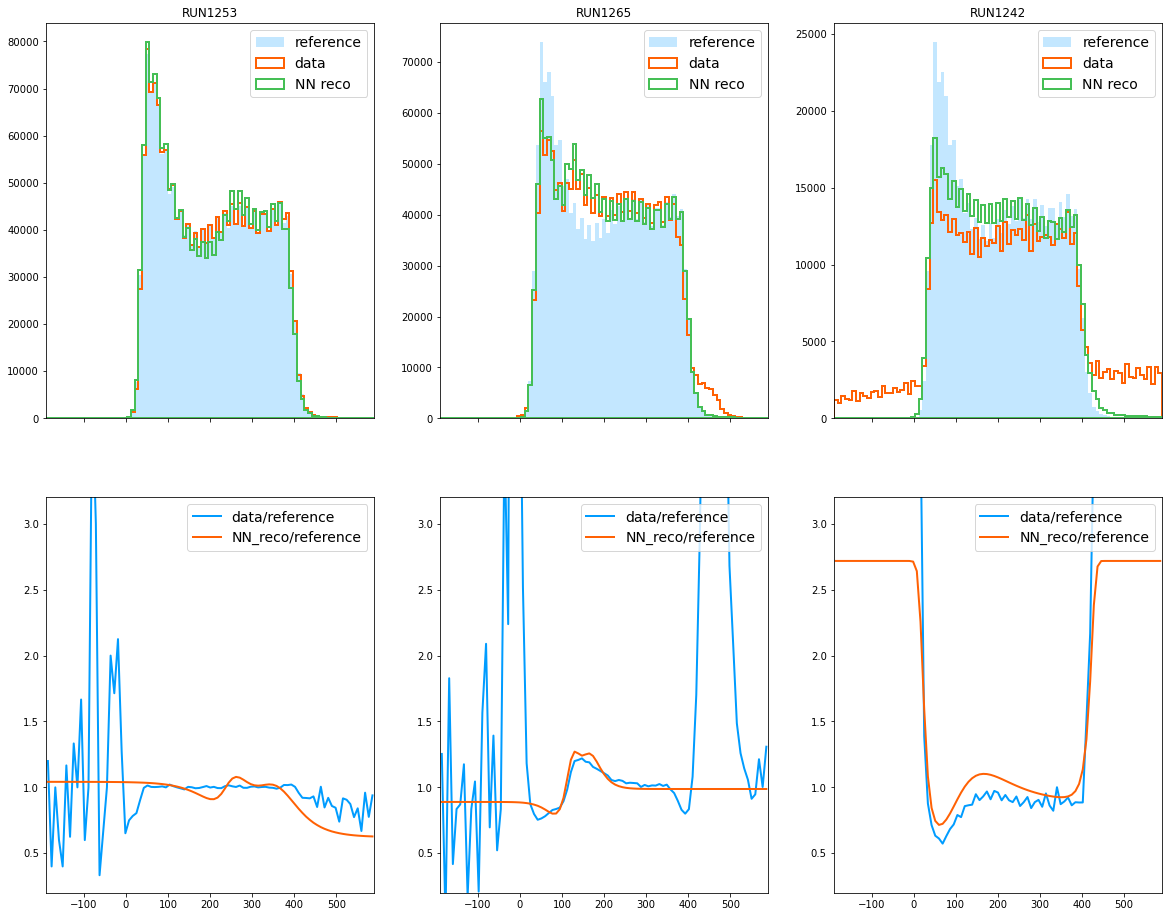

SAMPLE N: 26


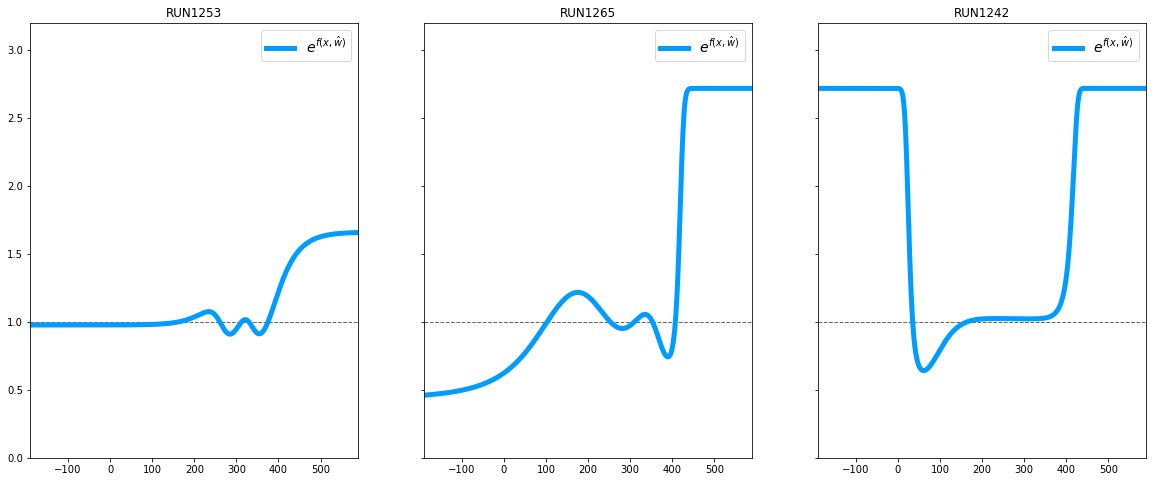

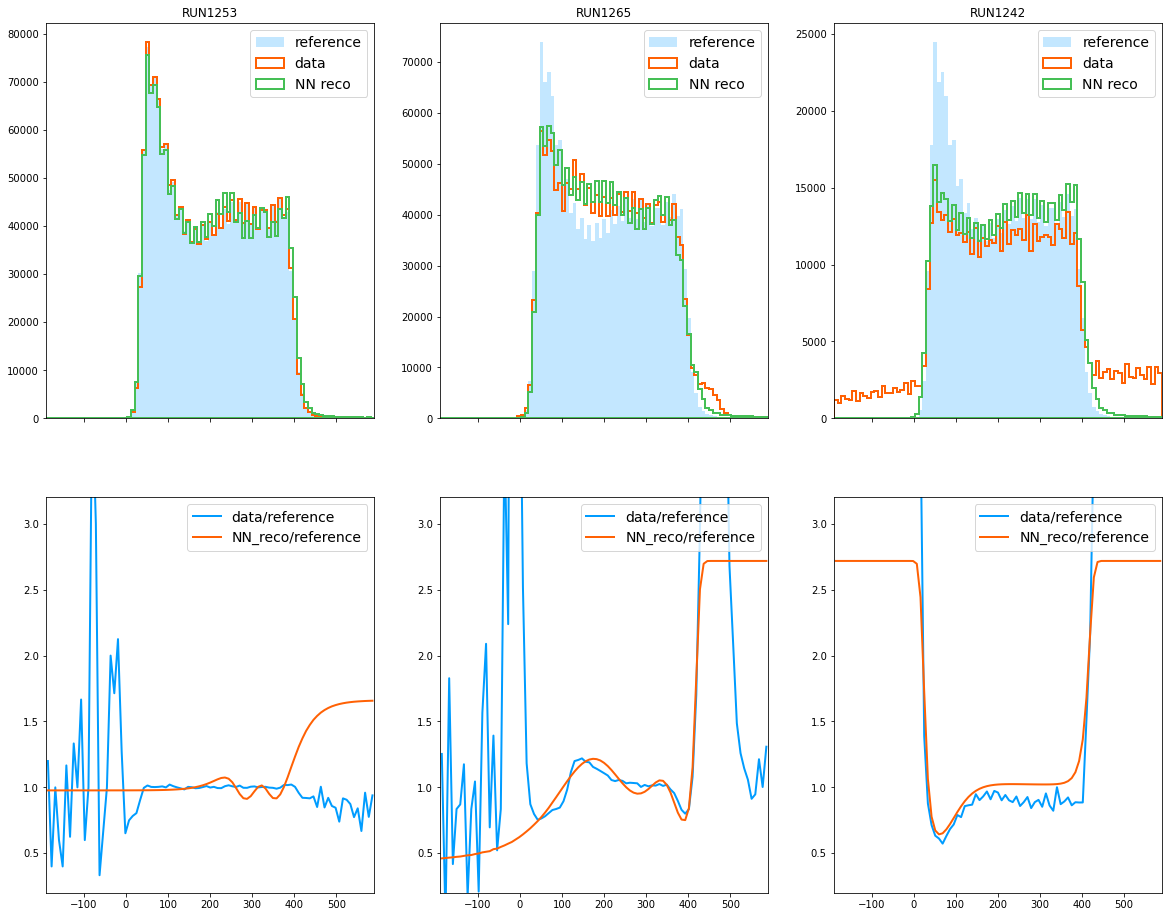

SAMPLE N: 27


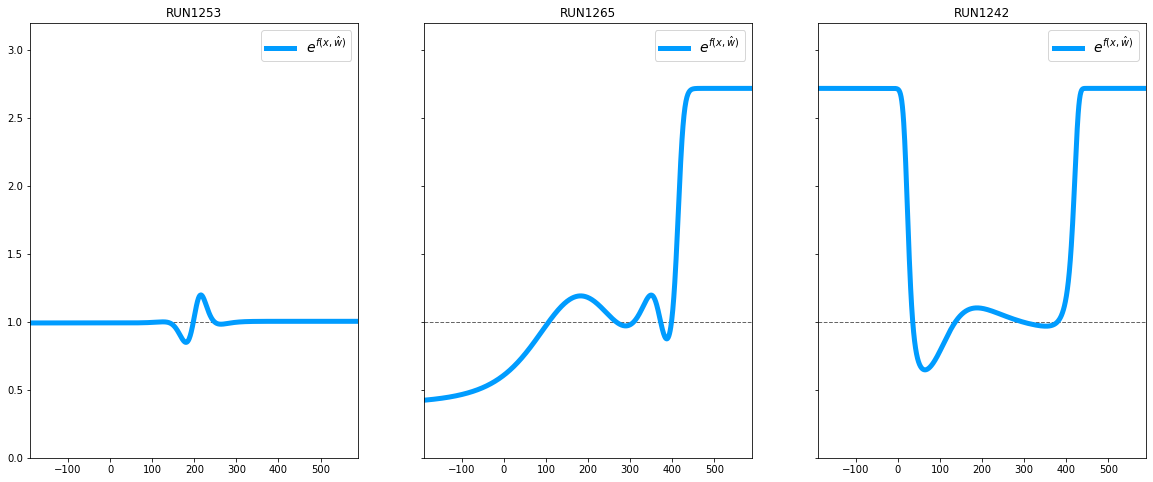

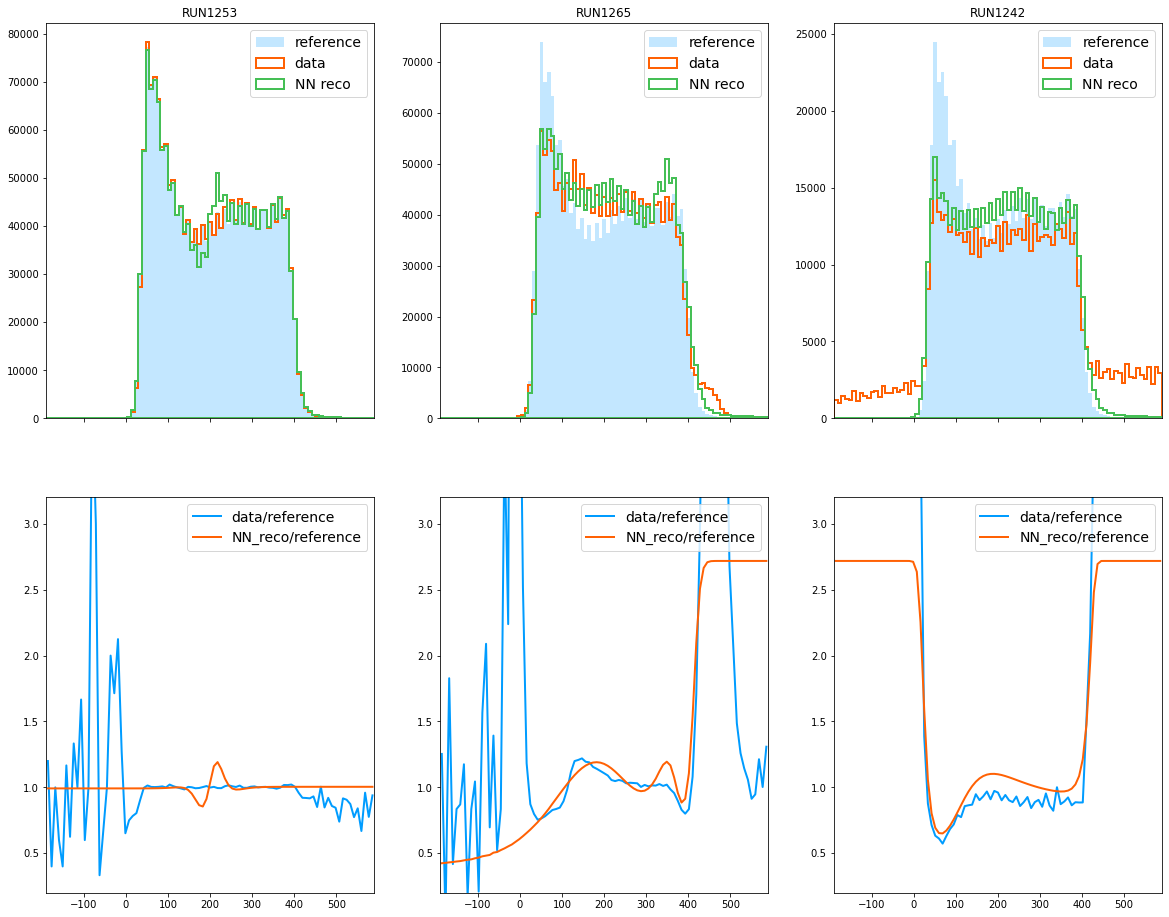

SAMPLE N: 28


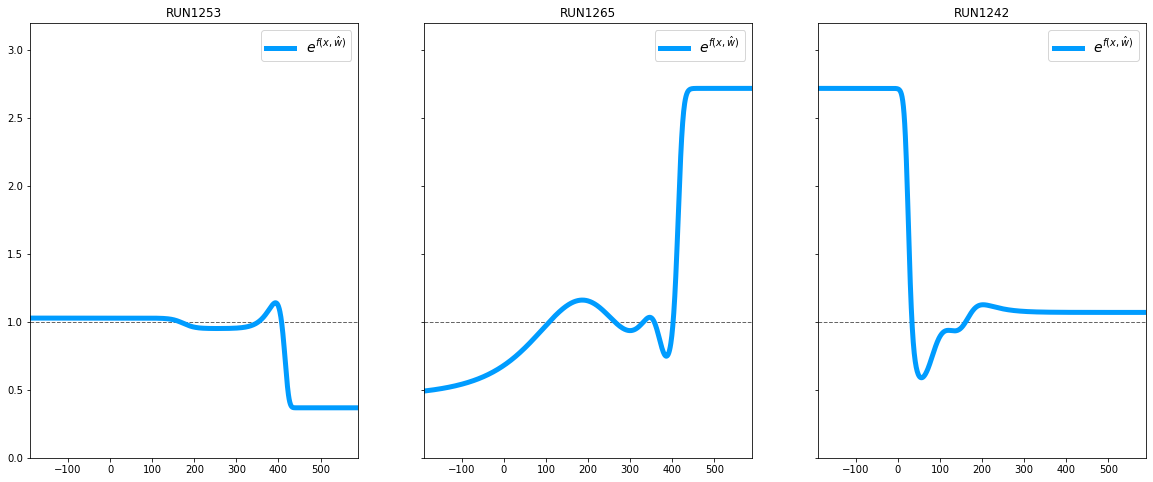

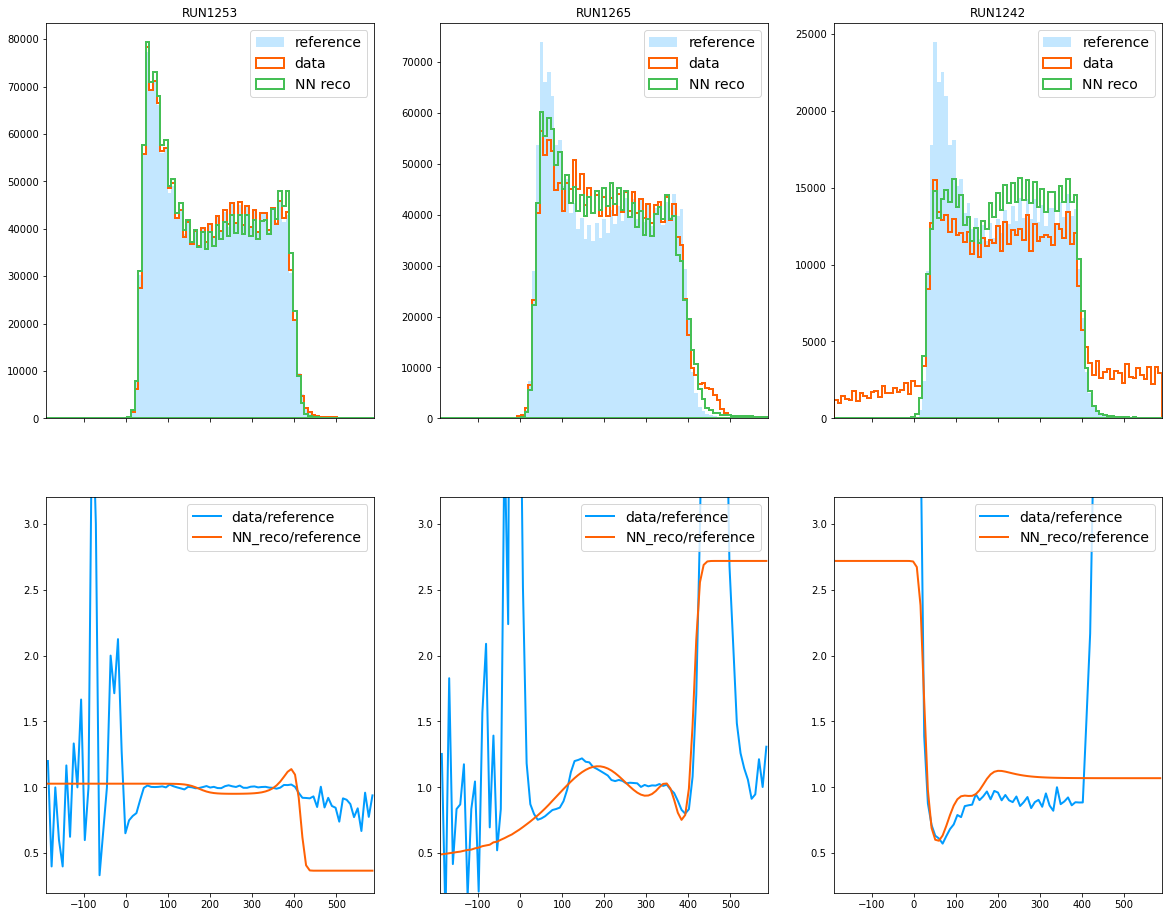

SAMPLE N: 29


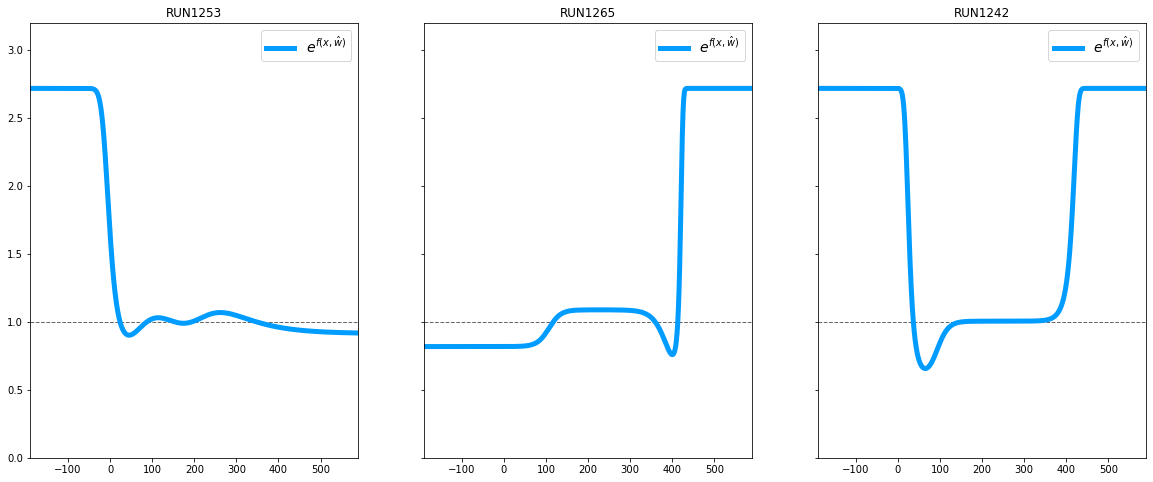

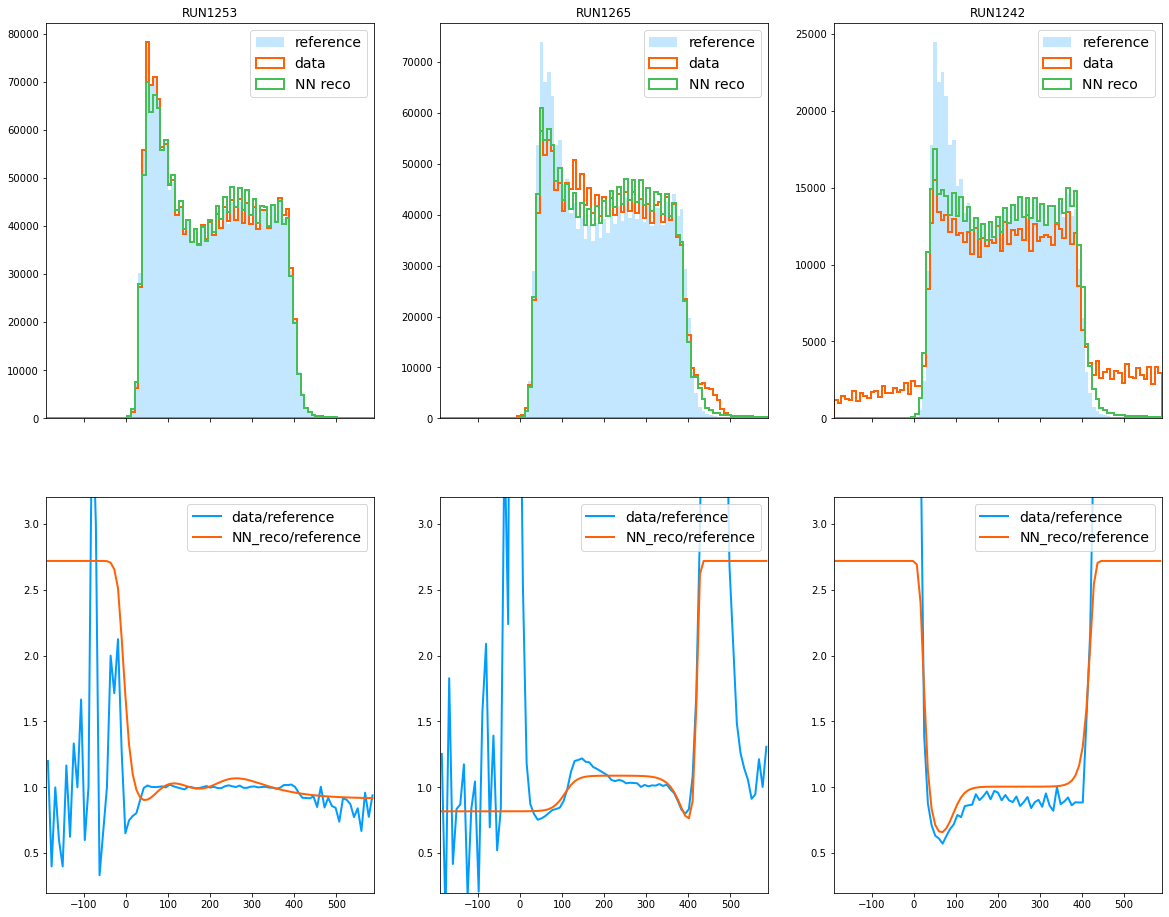

SAMPLE N: 30


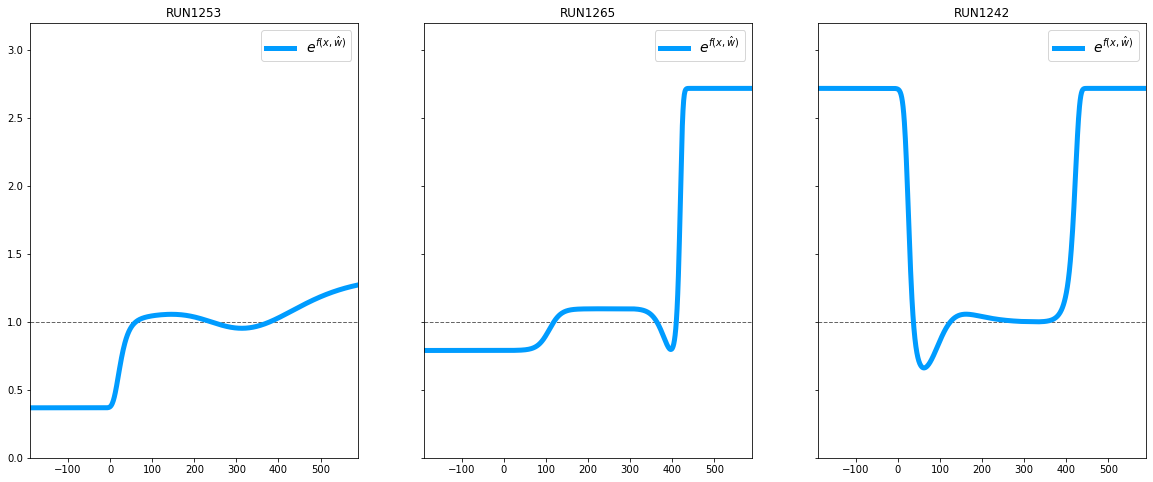

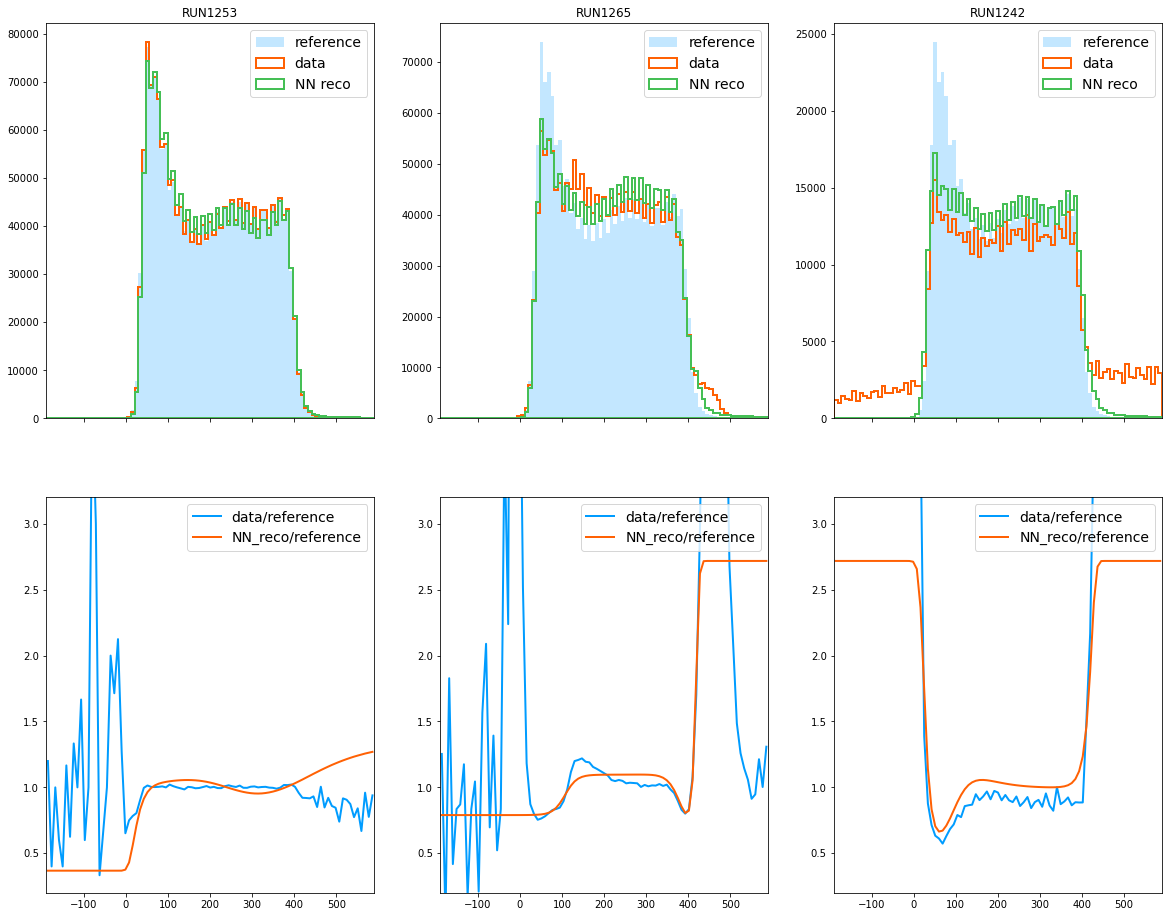

SAMPLE N: 31


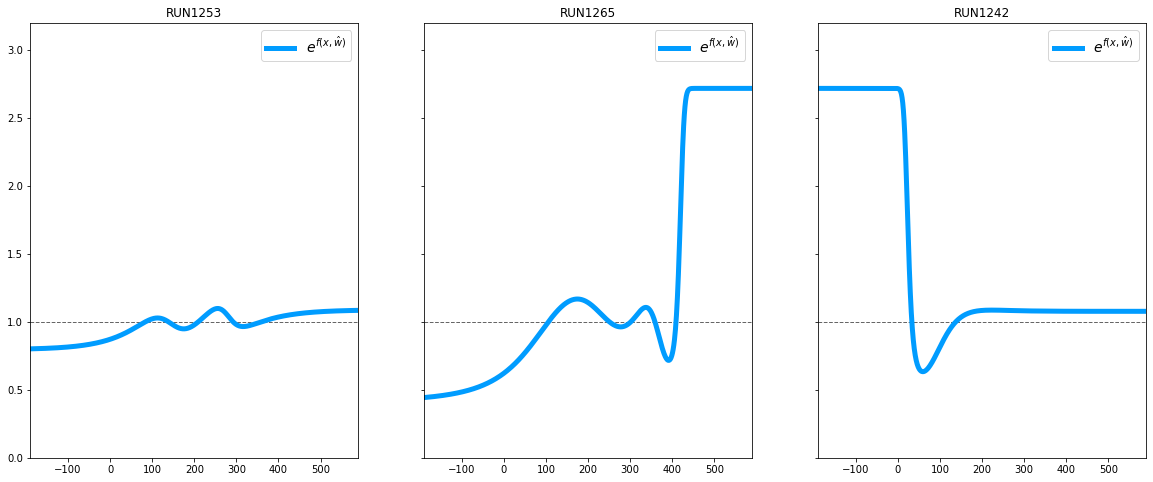

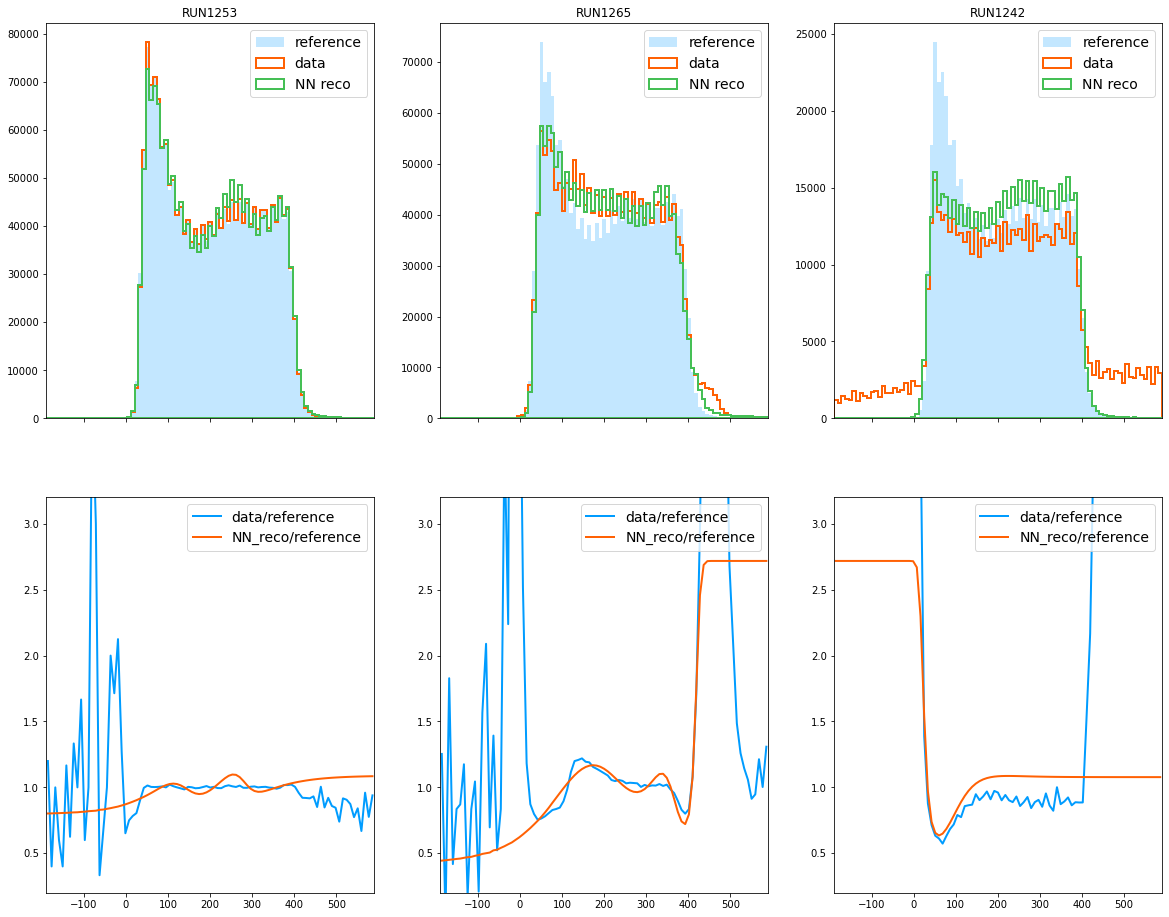

SAMPLE N: 32


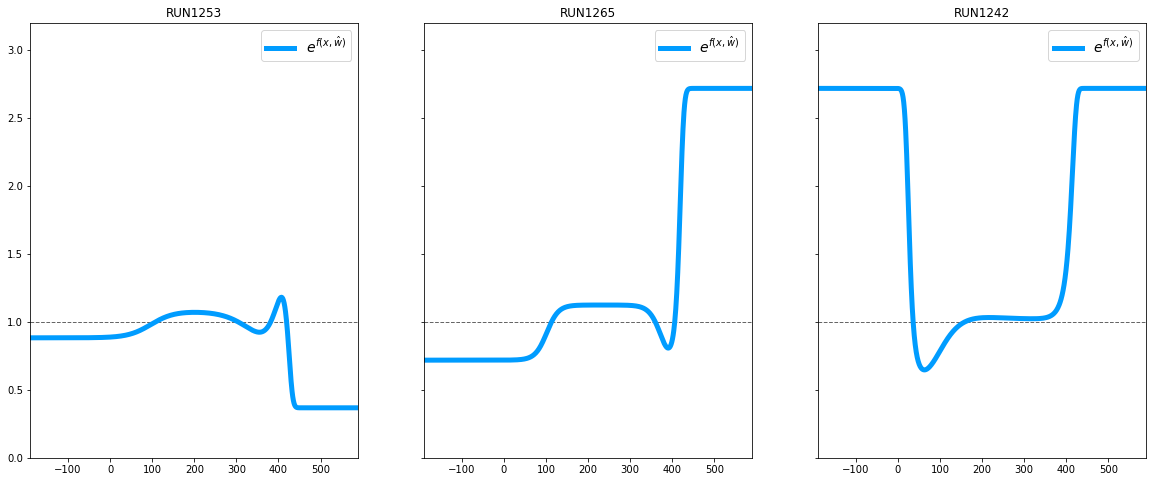

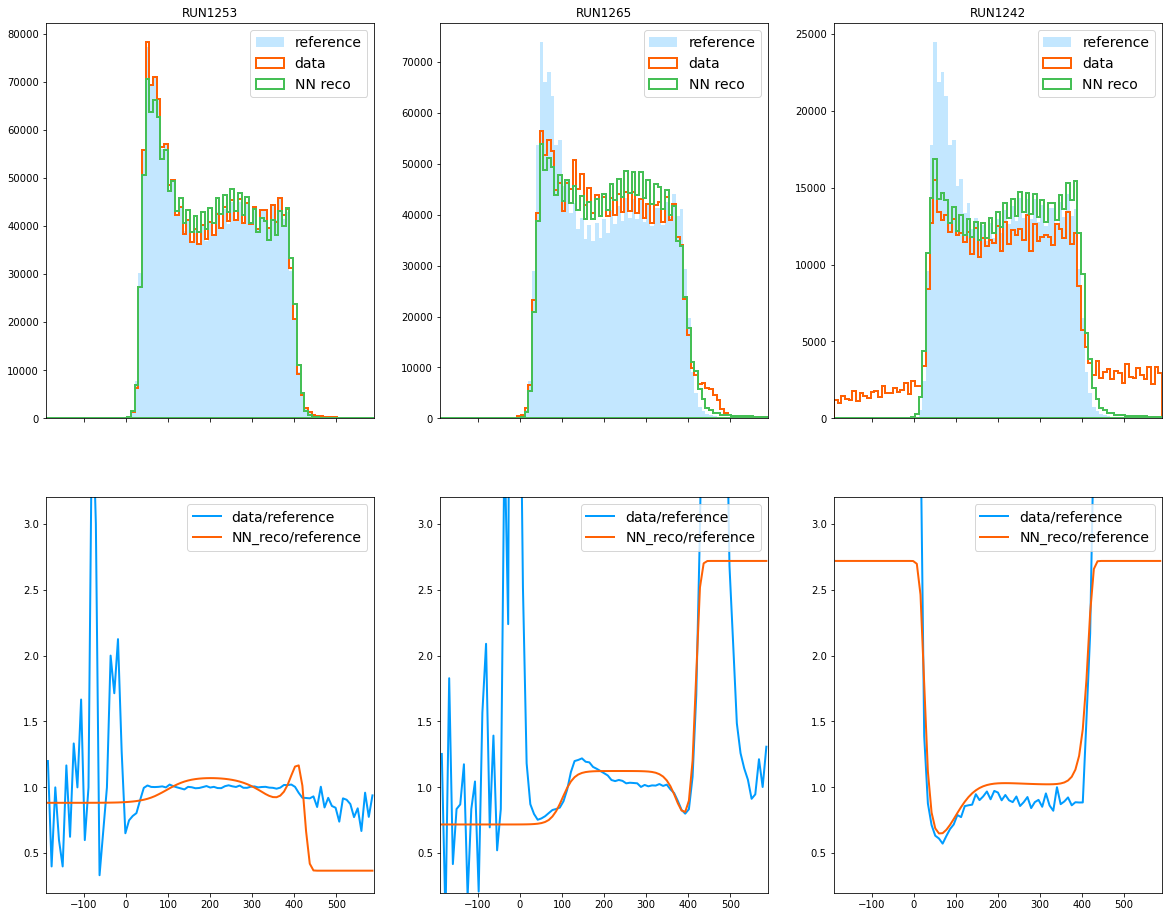

SAMPLE N: 33


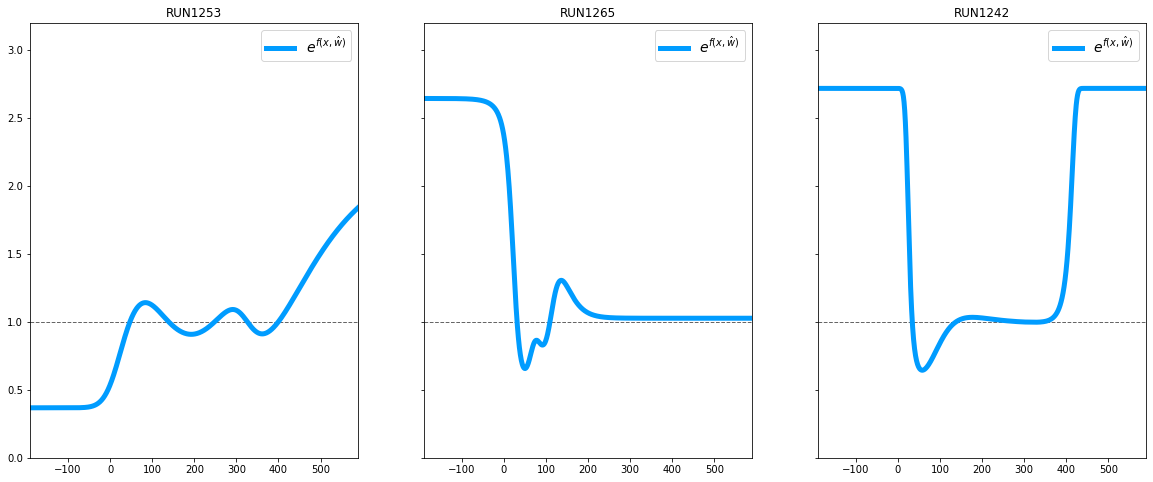

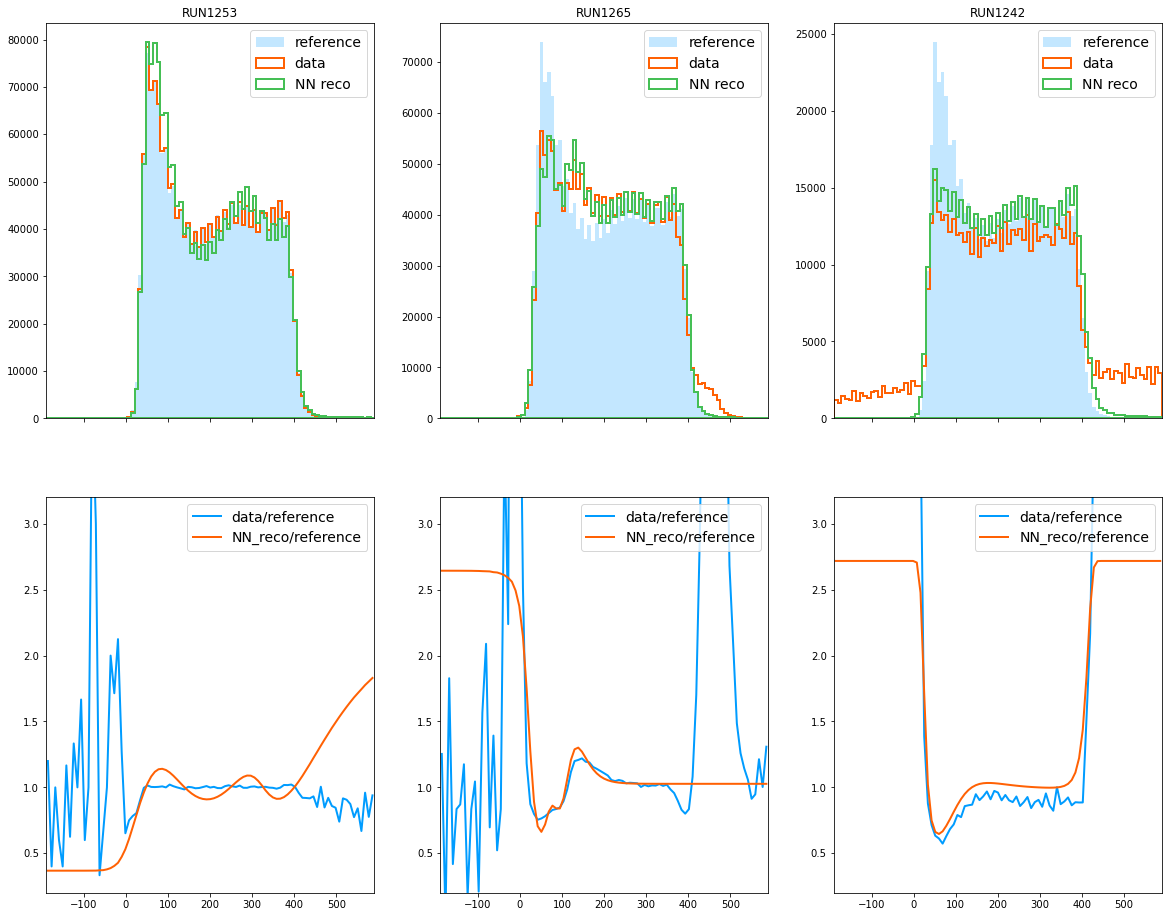

SAMPLE N: 34


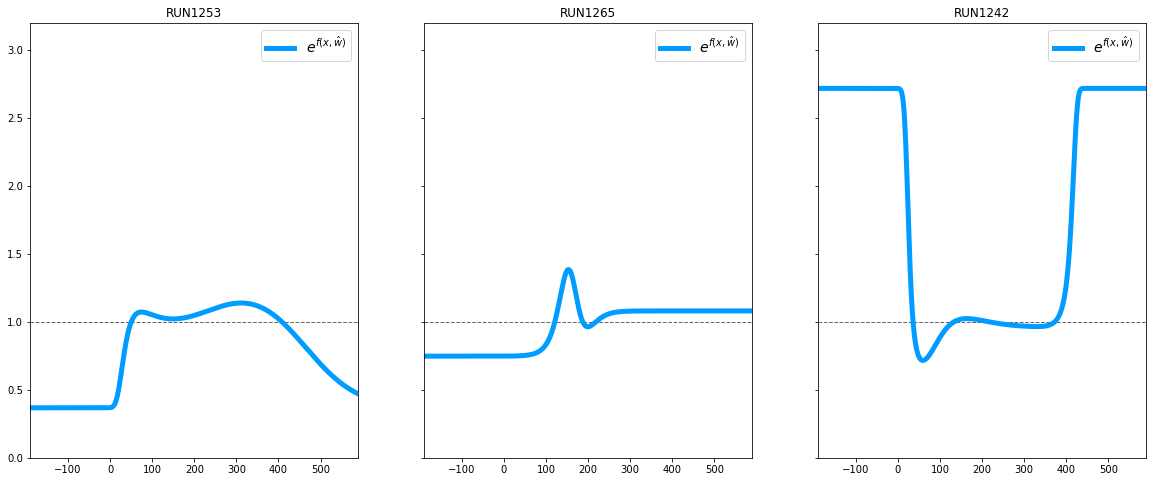

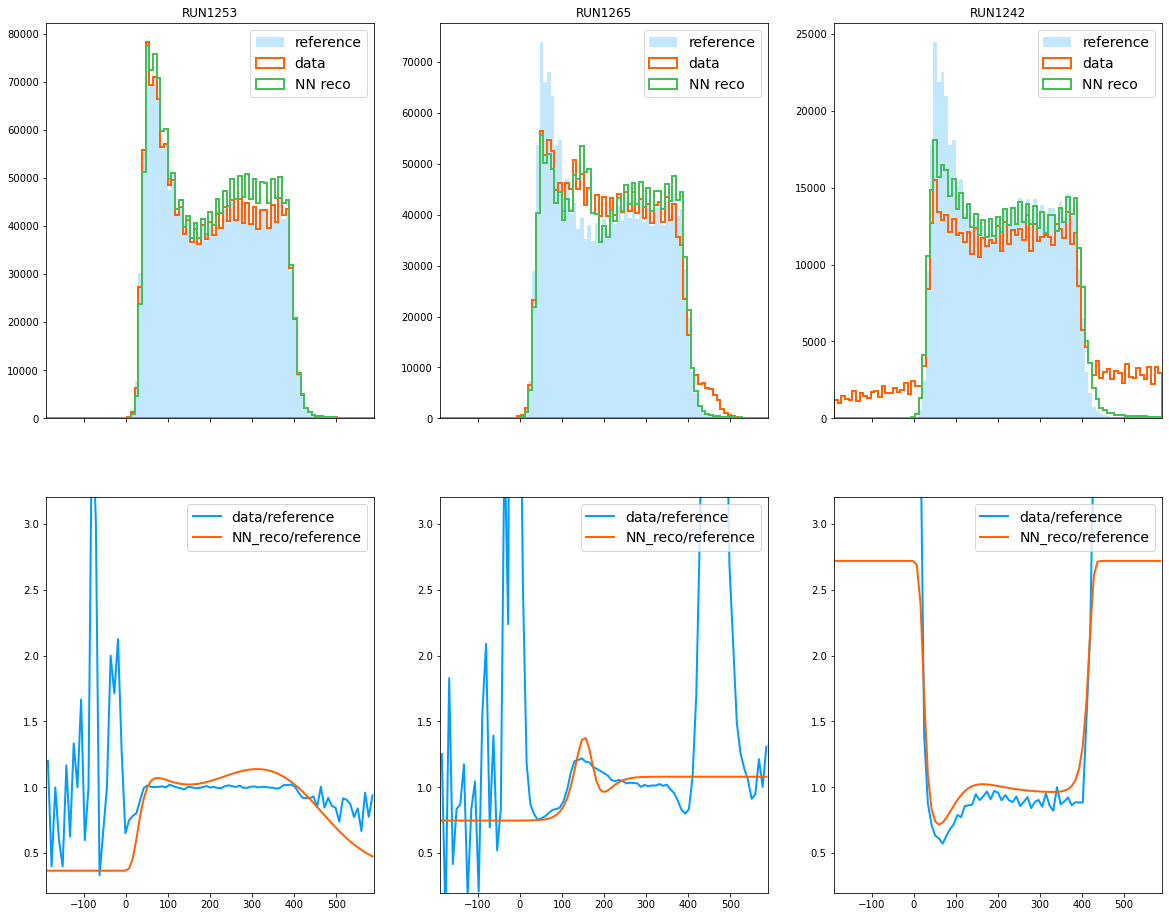

SAMPLE N: 35


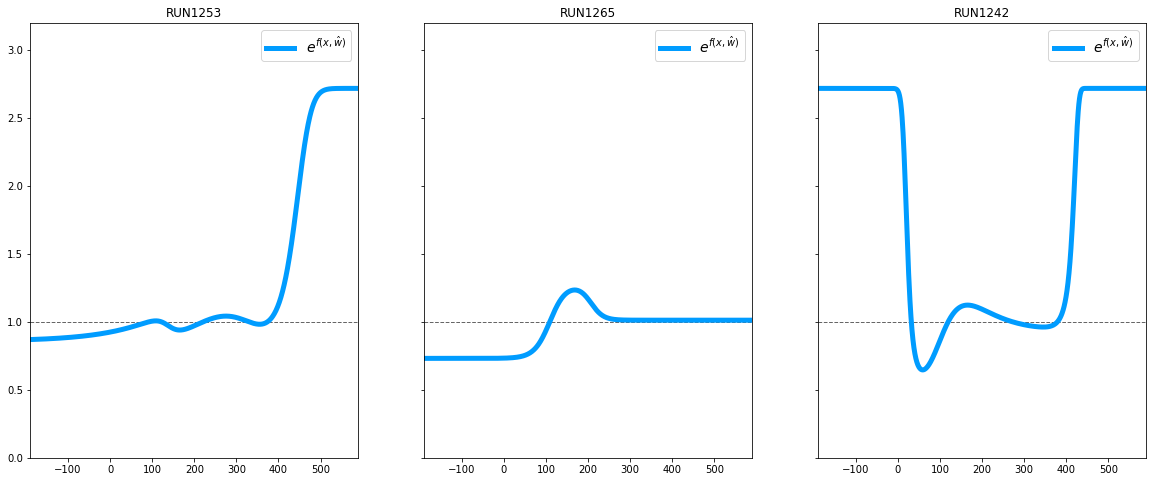

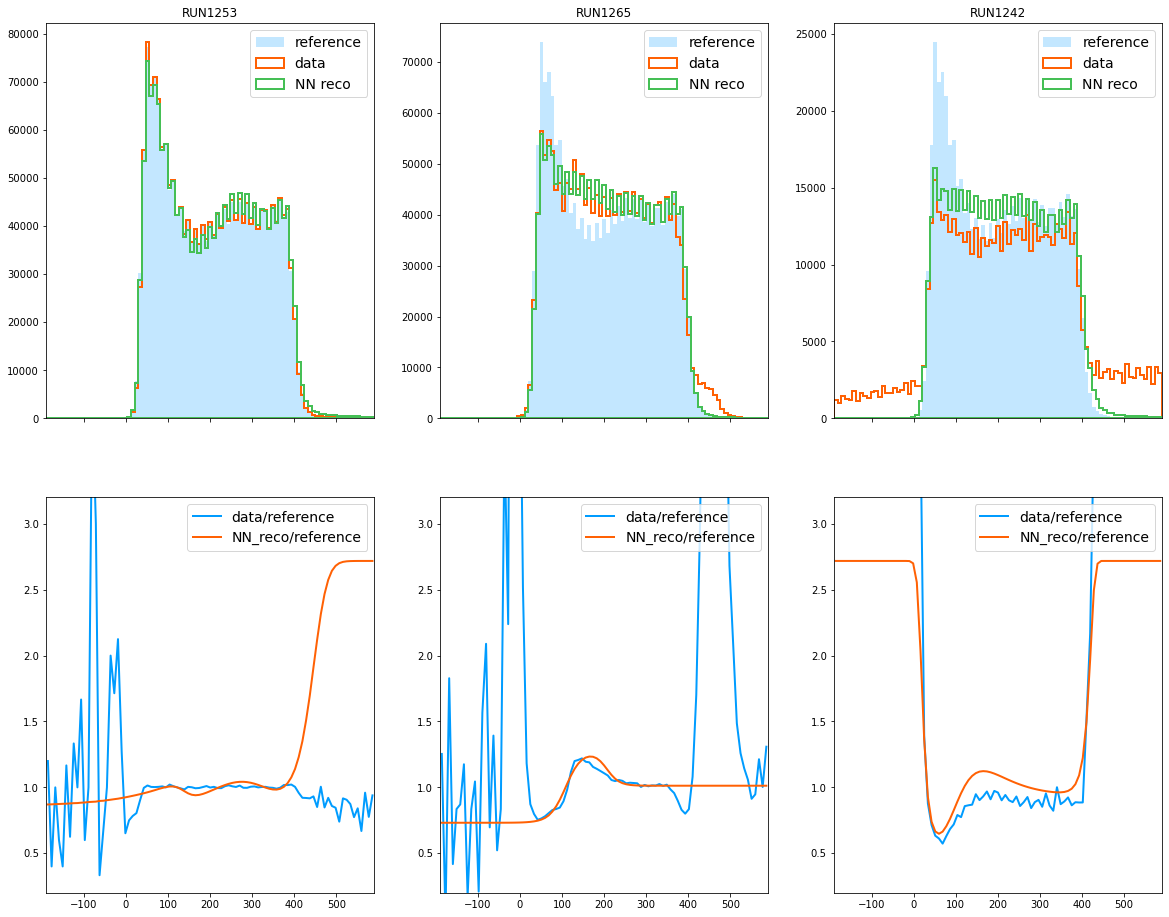

SAMPLE N: 36


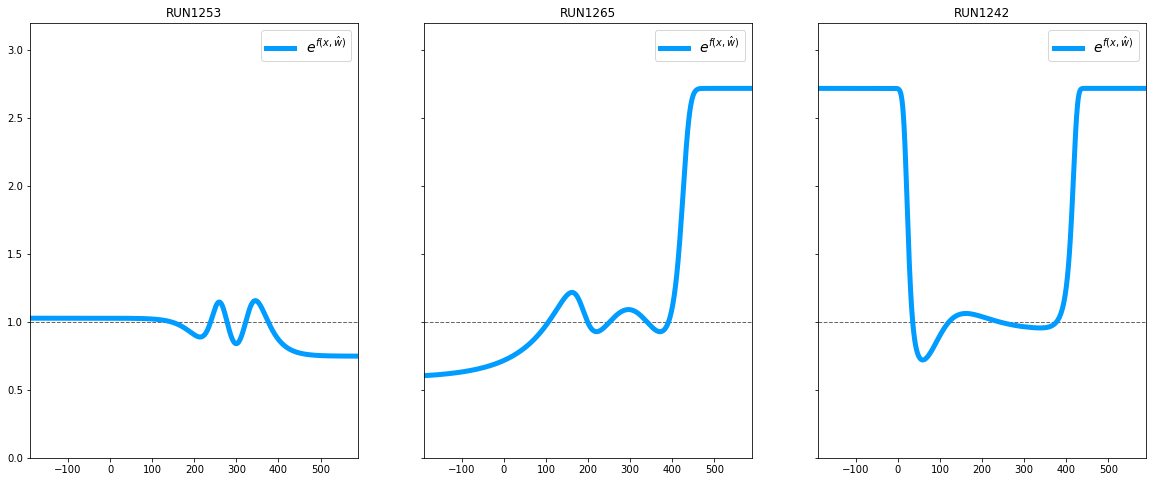

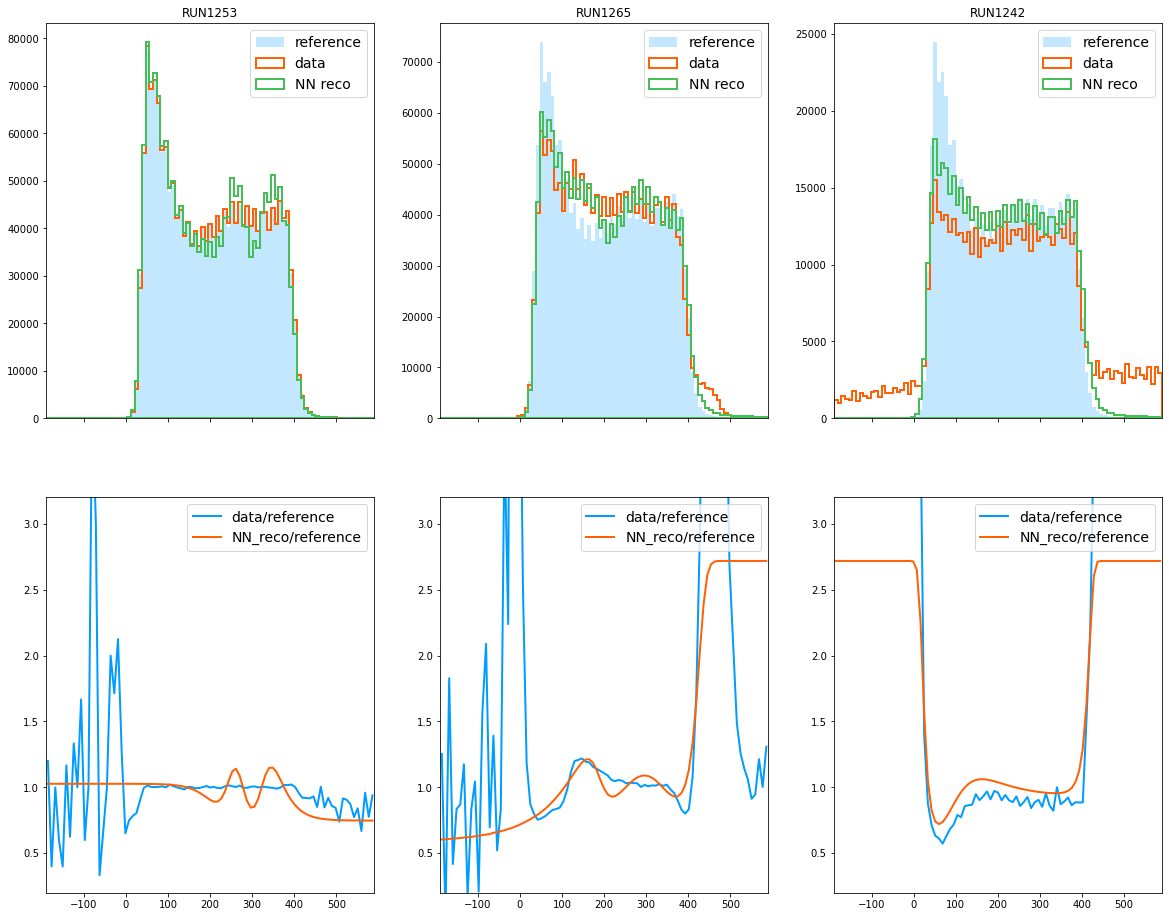

SAMPLE N: 37


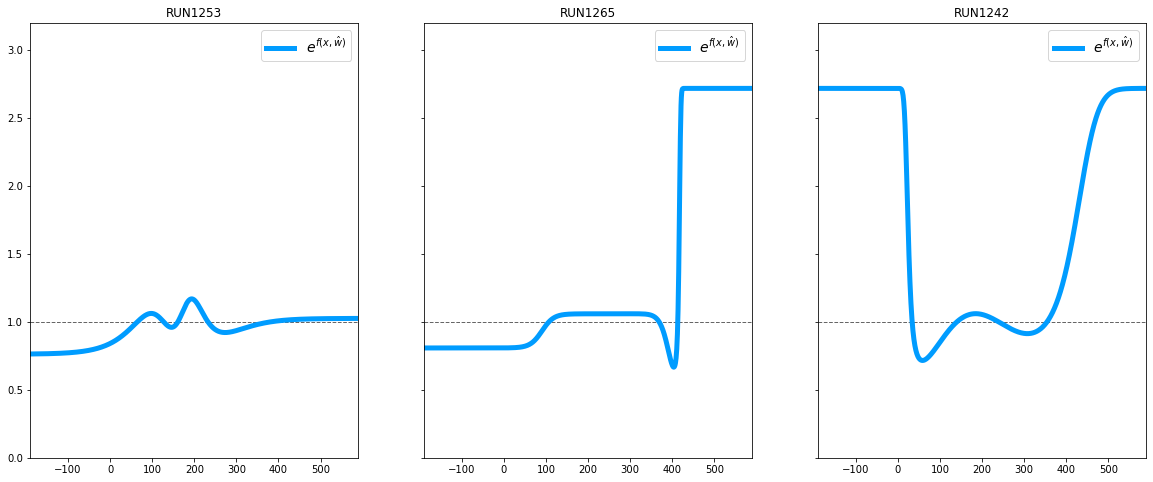

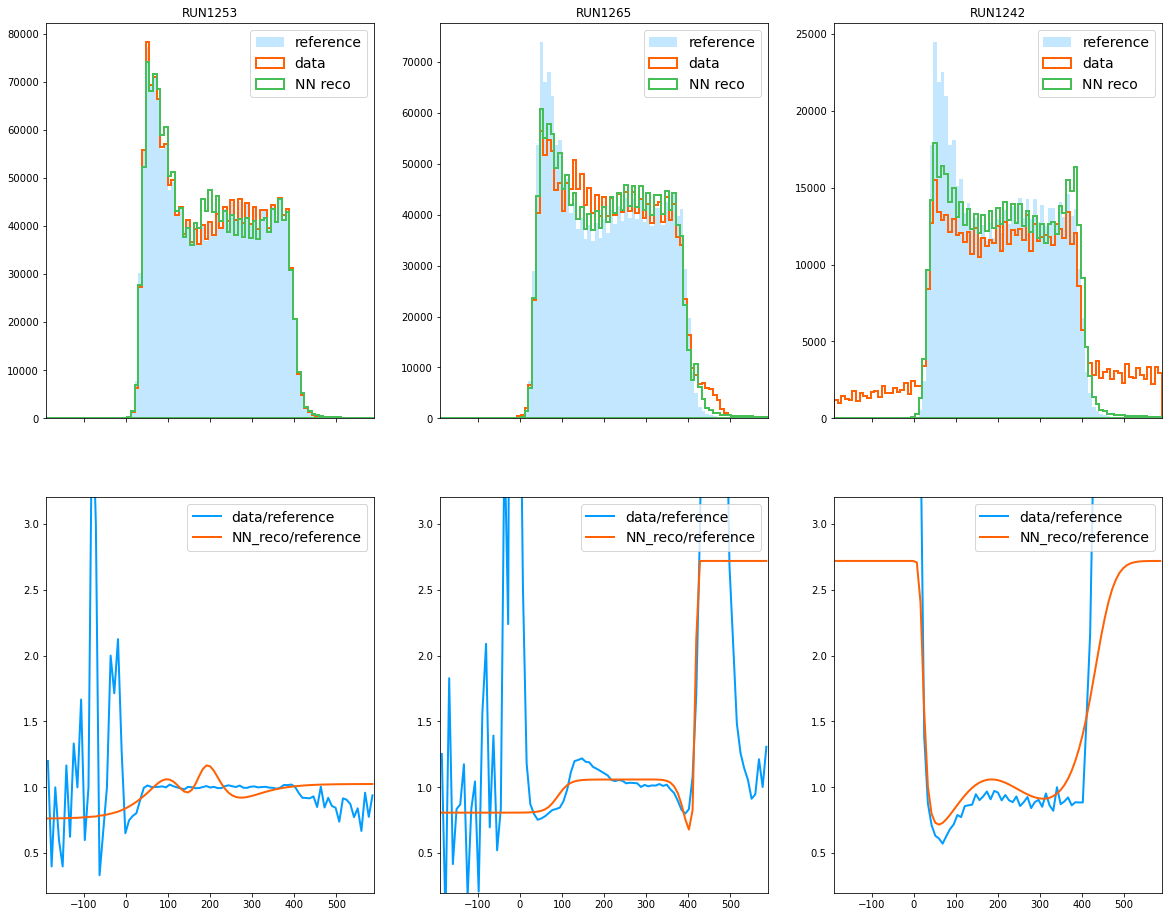

SAMPLE N: 38


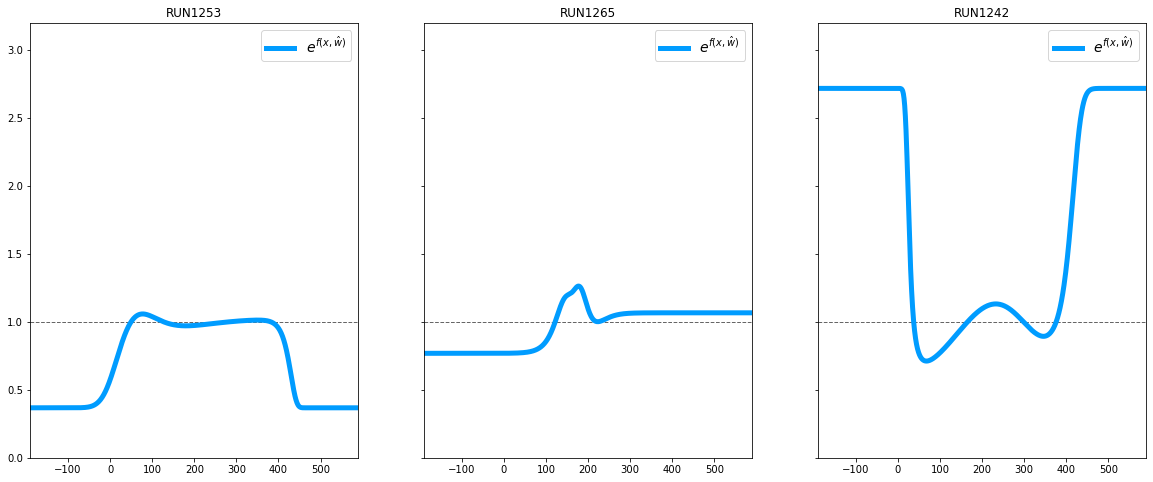

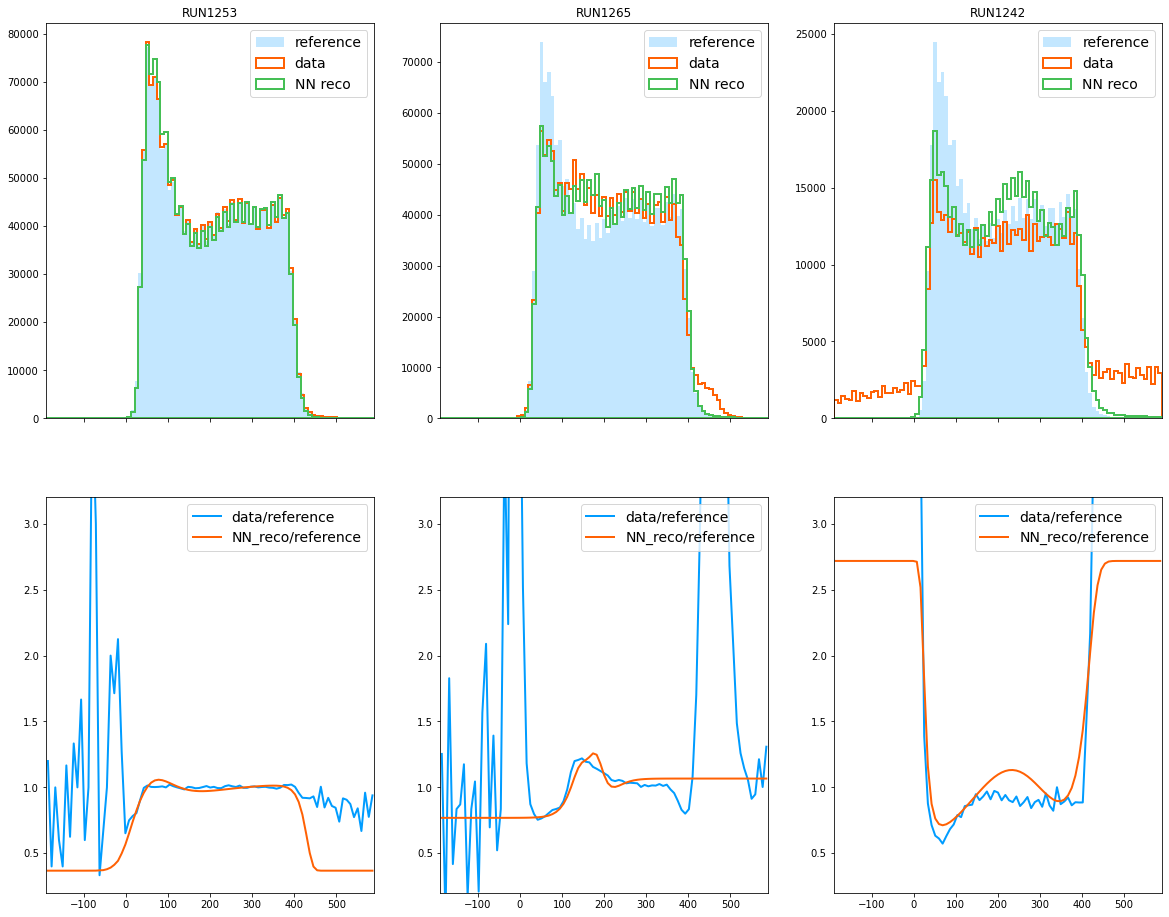

SAMPLE N: 39


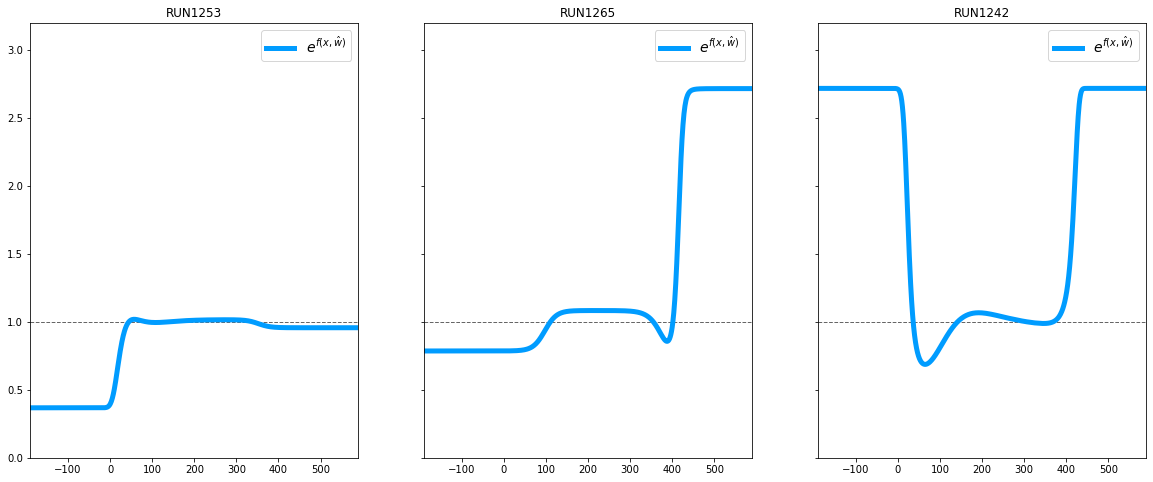

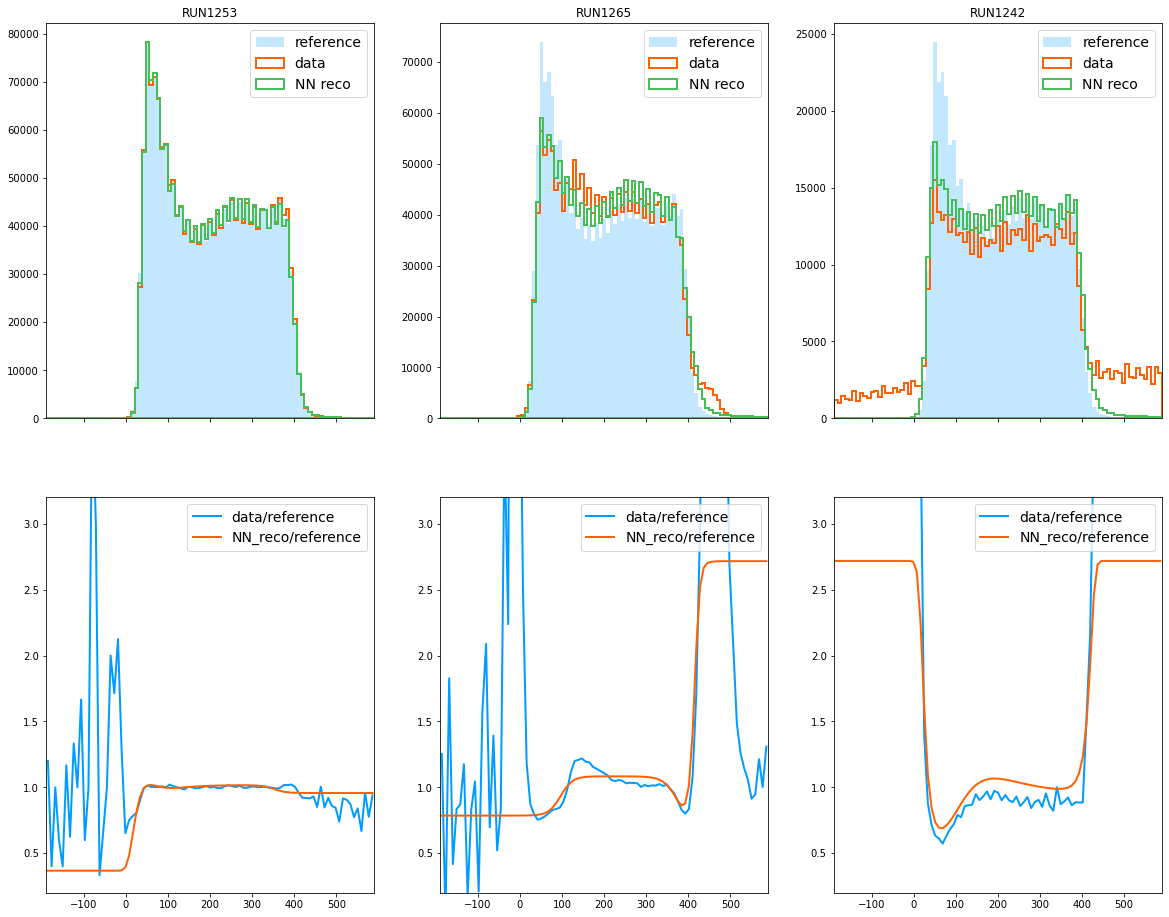

In [54]:
MAIN_PATH  = "/lustre/cmswork/nlai/DRIFT_TIME/model_testing/"
TOY_FOLDER = f"E{int(EPOCHS*1e3)}_latent{3}_layers{1}_wclip{float(WCLIP)}_ntoy{NTOYS}_ref{int(REF*1e3)}_bkg{int(BKG*1e3)}_sig{0}_patience{1000}/"


for i in range(NTOYS):
    
    print(f"SAMPLE N: {i}")
    
    WEIGHTS_PATH_0 = MAIN_PATH+FOLDER_0+f"/{i}/"+TOY_FOLDER
    WEIGHTS_PATH_1 = MAIN_PATH+FOLDER_1+f"/{i}/"+TOY_FOLDER
    WEIGHTS_PATH_2 = MAIN_PATH+FOLDER_2+f"/{i}/"+TOY_FOLDER

    weights_paths  = [WEIGHTS_PATH_0, WEIGHTS_PATH_1, WEIGHTS_PATH_2]

    weights_files  = [] 
    norm_files     = []
    for w_path in weights_paths:

        weights_files.append(
            [a for a in os.listdir(w_path) if "_weights.h5" in a][0]
        )

        norm_files.append(
            [a for a in os.listdir(w_path) if "_normWalization.txt" in a][0]
        )

    means = []
    stds  = []
    for i in [0, 1, 2]:
        with open(weights_paths[i]+norm_files[i], "r") as f_0:
            normalizzazione_0 = f_0.readline()
        means.append(
            float(normalizzazione_0.split("Mean: ")[1].split(", ")[0])
        )
        stds.append(
            float(normalizzazione_0.split("Std: " )[1])
        )
        
    model_0 = NPLModel()
    model_1 = NPLModel()
    model_2 = NPLModel()
    model_0.load_weights(weights_paths[0]+weights_files[0])
    model_1.load_weights(weights_paths[1]+weights_files[1])
    model_2.load_weights(weights_paths[2]+weights_files[2])

    models = [model_0, model_1, model_2]
    
    pred_weights_0 = np.abs(flatten(np.exp(models[0].predict((df_ref-means[0])/stds[0], batch_size=df_ref.shape[0]))))
    pred_weights_1 = np.abs(flatten(np.exp(models[1].predict((df_ref-means[1])/stds[1], batch_size=df_ref.shape[0]))))
    pred_weights_2 = np.abs(flatten(np.exp(models[2].predict((df_ref-means[2])/stds[2], batch_size=df_ref.shape[0]))))

    nn_weights = [pred_weights_0, pred_weights_1, pred_weights_2]
    
    xgrid = np.linspace(-190, 590, 1000)

    fig, ax = plt.subplots(ncols=3, figsize=(20,8), sharex="all", sharey="all")

    ax[0].set_xlim(-190,590)
    ax[0].set_ylim(0,3.2)
    
    titles = ["RUN1253", "RUN1265", "RUN1242"]

    for i in [0, 1, 2]:
        
        ax[i].set_title(titles[i])

        ax[i].axhline(y=1, c="black", ls="--", lw=1, alpha=.6)

        sns.lineplot(
            x=xgrid,
            y=flatten(np.exp( models[i]((xgrid-means[i]) / stds[i]) )),
            linewidth=5,
            color="#009cff", 
            ax=ax[i],
            label=r"$e^{f(x, \hat{w})}$"
        )

        ax[i].legend(loc="upper right", fontsize=14)

    plot_name = "predicted_ratio"
    ext = "pdf"
    # fig.savefig(
    #     f"/lustre/cmswork/nlai/FALKON/plots/{plot_name}.{ext}",
    #     facecolor="white"
    # )     
    plt.show()
    
    
    fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(20,16), sharex="all")

    ax[0][0].set_xlim(-190,590)
    x = 0.5*(bins[1:]+bins[:-1])

    for i in [0, 1, 2]:
        
        ax[0][i].set_title(titles[i])
        
        # reference distribution
        ref_hist = ax[0][i].hist(
            df_ref["drift_time"], 
            bins=bins, 
            weights=w_refs[i],
            density=False,
            histtype="stepfilled", 
            linewidth=2,
            edgecolor="none", 
            facecolor="#aadeff", 
            alpha=.7, 
            label="reference"
        )

        # data distribution
        data_hist = ax[0][i].hist(
            data_df[i]["drift_time"], 
            bins=bins, 
            weights=w_data[i],
            density=False,
            histtype="stepfilled", 
            linewidth=2,
            edgecolor="#FF6104", 
            facecolor="none", 
            alpha=1, 
            label="data"
        )

        # NN reco
        nn_hist = ax[0][i].hist(
            df_ref["drift_time"], 
            bins=bins, 
            weights=nn_weights[i]*w_refs[i],
            density=False,
            histtype="stepfilled", 
            linewidth=2,
            edgecolor="#45bf55", 
            facecolor="none", 
            alpha=1, 
            label="NN reco"
        )

        ax[0][i].legend(loc="upper right", fontsize=14)


        # data/ref ratio
        ax[1][i].plot(
            x, 
            (data_hist[0])/(ref_hist[0]),
            linewidth=2,
            color="#009cff", 
            alpha=1, 
            label="data/reference"
        )

        # NN_reco/ref ratio
        ax[1][i].plot(
            x, 
            (nn_hist[0])/(ref_hist[0]),
            linewidth=2,
            color="#FF6104", 
            alpha=1, 
            label="NN_reco/reference"
        )
        ax[1][i].set_ylim(0.2, 3.2)
        ax[1][i].legend(loc="upper right", fontsize=14)

    plot_name = "nn_reco"
    ext = "pdf"
#     fig.savefig(
#         f"/lustre/cmswork/nlai/FALKON/plots/{plot_name}.{ext}",
#         facecolor="white"
#     )     
    plt.show()